In [32]:
# Analysis on cooling effects from water bodies in Copenhagen 

# changes in Land Surface Temperature (LST) is used to detect the cooling effects

#lst_case.tif: The study area extent is created through a Union and a 
#Dissolve of the lakes_and_sea dataset and the official extents of 
#the two municipalities; the City of Copenhagen and Frederiksberg. 
#The calculated LST result is converted to EPSG:25832 with Project Raster 
#and cut to the case study extent with Extract by Mask and used as template 
#for further raster processing (Environment settings for extent, cell size, 
#mask, and snap raster). 

#lakes.shp and seas.shp: The lakes (or seas respectively) are selected in 
#the lakes_and_sea dataset (Select By Attributes) and extracted to their 
#own layer (Copy Features).  

#lakes_case.tif and seas_case.tif: The lakes (or seas respectively) are 
#converted into a raster (Raster to Polygon) with the same parameters as 
#the LST for the case study area.  

#euc_lake_distV2.tif and euc_seas_distV2.tif: Euclidean Distance is used 
#to calculate the distance to the nearest lake (or sea respectively) for 
#each raster cell following the parameters as the LST for the case study area.  

#lakes_source_near.tif and seas_source_near.tif: Euclidean Allocation is 
#used to provide the id in each raster cell of the nearest lake (or nearest 
#sea polygon respectively) following the parameters as the LST for the 
#case study area.


In [ ]:
#pip install statsmodels
#pip install pandas matplotlib
#pip install numpy
#pip install scipy
#pip install geopandas
#!pip install matplotlib-scalebar
#pip...

In [39]:
# SETUP
import pandas as pd
import rasterio
from rasterio.mask import mask
import rasterio.features
from rasterio.transform import array_bounds
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.patches as mpatches
from matplotlib.cm import ScalarMappable
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.lines as mlines
import geopandas as gpd
import contextily as cx # for getting background maps
from shapely.geometry import mapping
from shapely.geometry import box # for getting bbox
from shapely.geometry import MultiPoint
from shapely.geometry import Point
from shapely.ops import voronoi_diagram
import statsmodels.api as sm  # Import statsmodels for regression
from scipy import stats  # For regression analysis
from scipy.stats import mannwhitneyu
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from libpysal.weights import DistanceBand
import seaborn as sns


In [2]:
# SETUP
# import rasters
lst = rasterio.open('landsat20180603/lst_20180603_final.tif').read(1).astype('float64') # Land surface temperature in study area Copenhagen
lakes_case = rasterio.open('analysis_input_data/lakes_case.tif').read(1).astype('float64') # lakes=1 
lake_dist = rasterio.open('analysis_input_data/lakes_euc_dist.tif').read(1).astype('float64') # distances in metres to nearest lake
lakes_source_near = rasterio.open('analysis_input_data/lakes_source_near.tif').read(1).astype('float64') # id of nearest lake
seas_case = rasterio.open('analysis_input_data/seas_case.tif').read(1).astype('float64') # sea=1
sea_dist = rasterio.open('analysis_input_data/seas_euc_dist.tif').read(1).astype('float64') # distances in metres to sea
seas_source_near = rasterio.open('analysis_input_data/seas_source_near.tif').read(1).astype('float64') # id of nearest sea polygon

imp = rasterio.open('imp2018/imp2018.tif').read(1).astype('float64') # id of nearest sea polygon
mndwi = rasterio.open('landsat20180603/mndwi_20180603.tif').read(1).astype('float64') # id of nearest sea polygon
ndvi = rasterio.open('landsat20180603/ndvi_20180603.tif').read(1).astype('float64') # id of nearest sea polygon
herb_perc = rasterio.open('analysis_input_data/herb_perc.tif').read(1).astype('float64') # herbaceous percentage 
forest_perc = rasterio.open('analysis_input_data/forest_perc.tif').read(1).astype('float64') # herbaceous percentage 



In [40]:
# SETUP
# Read the shapefile
lakes = gpd.read_file("analysis_input_data/lakes_casestudy.shp") # all lake polygons with attribute data
#lakes = gpd.read_file("lakes.shp") # all lake polygons with attribute data
print(lakes.head()) # Show the first few rows of the dataframe

# Read the shapefile
seas = gpd.read_file("analysis_input_data/seas.shp") # all sea polygons with attribute data
print(seas.head()) # Show the first few rows of the dataframe

   fid_    id objekt_typ        kommune    area_ha  perimeter       details  \
0     0  1138         Sø  Frederiksberg   0.096052         73   obs cooling   
1     0   240         Sø      København  14.834820       2288  close to sea   
2     0  1140         Sø      København   3.693557        918   obs cooling   
3     0   517         Sø      København   6.313699        625   obs cooling   
4     0   516         Sø      København   0.804220        389   obs cooling   

   obs_dist    obs_lst    est_dist    est_lst   cool_trend  herbCross  \
0       315  27.794376  171.010603  25.908302     positive        NaN   
1       165  28.605614  242.849081  28.548786  seaPositive        NaN   
2       255  28.224209  223.030366  26.633807     positive        NaN   
3        75  24.103312  230.672440  26.776500     positive        NaN   
4       135  26.649478  201.300379  27.251340     positive        NaN   

   herbCoolCr  woodCoolCr  vegOverlap            vegExplain  \
0         NaN         N

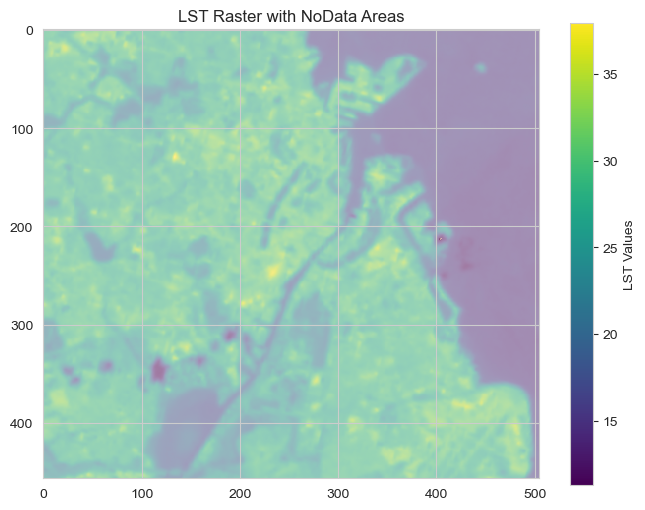

In [41]:
# SETUP
# Set NoData in LST
min_value = np.nanmin(lst)  # Find minimum value (excluding NaNs)
# Set min value as nodata
lst[lst == min_value] = np.nan
#src.nodata = min_value  # Update nodata in metadata

# Create nodata mask
nodata_mask = np.isnan(lst)

# Plot raster and nodata areas
fig, ax = plt.subplots(figsize=(8, 6))
cax = ax.imshow(lst, cmap="viridis", interpolation="none")
plt.colorbar(cax, label="LST Values")

# Overlay nodata areas
ax.imshow(nodata_mask, cmap="Reds", alpha=0.5)  # Red overlay for nodata areas
ax.set_title("LST Raster with NoData Areas")
plt.show()

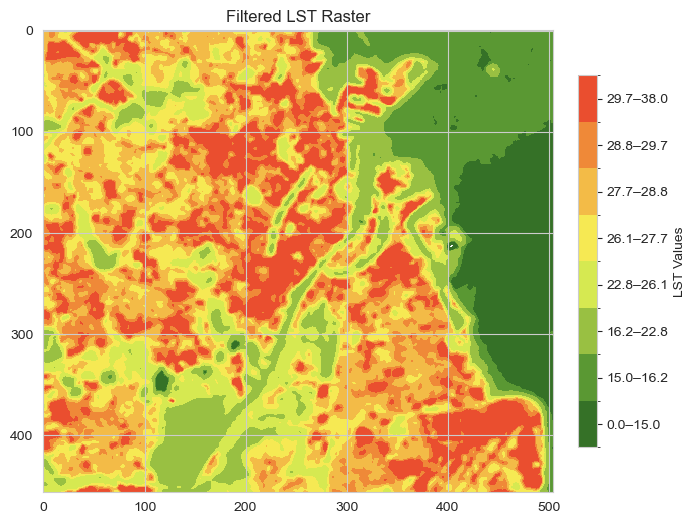

In [42]:
# LST FOR VISUALISATION
# Set NoData in LST
min_value = np.nanmin(lst)  # Find minimum value (excluding NaNs)
# Set min value as nodata
lst[lst == min_value] = np.nan
#src.nodata = min_value  # Update nodata in metadata

# Create nodata mask
nodata_mask = np.isnan(lst)

# Define class edges and colors
lst_new_colorbins_lst = [0, 15.0, 16.2, 22.8, 26.1, 27.7, 28.8, 29.7, 38.0]
lst_new_colors_lst = ["#357127", "#5A9833", "#99C042", "#D6E951", "#F6E953", "#F3BB47", "#EF8938", "#EA4E2F"]
lst_new_classes_lst = np.digitize(lst, lst_new_colorbins_lst, right=False) - 1
lst_new_classes_lst[np.isnan(lst)] = -1  # mark NoData as -1
lst_plot_new_lst = np.ma.masked_where(lst_new_classes_lst < 0, lst_new_classes_lst)
# Create colormap
lst_new_cmap_lst = ListedColormap(lst_new_colors_lst)
norm_lst = BoundaryNorm(lst_new_colorbins_lst, lst_new_cmap_lst.N)

# Plot the filtered raster
fig, ax = plt.subplots(figsize=(8,6))
cax = ax.imshow(
    lst,
    cmap=lst_new_cmap_lst,
    norm=norm_lst,
    interpolation="none"
)

cbar = fig.colorbar(cax, ax=ax, fraction=0.03, pad=0.04)
cbar.set_label("LST Values")
cbar.set_ticks([(lst_new_colorbins_lst[i]+lst_new_colorbins_lst[i+1])/2 for i in range(len(lst_new_colorbins_lst)-1)])
cbar.set_ticklabels([f"{lst_new_colorbins_lst[i]:.1f}–{lst_new_colorbins_lst[i+1]:.1f}" for i in range(len(lst_new_colorbins_lst)-1)])

ax.set_title("Filtered LST Raster")
plt.show()

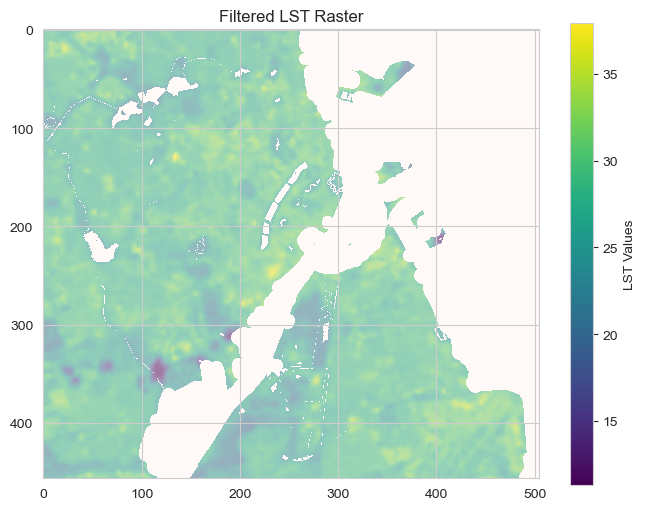

mean of LST is  24.8428706720635
min of LST is  11.306781585614756
max of LST is  37.954989325660094
mean of LST is  28.065271140801677
min of LST is  11.306781585614756
max of LST is  37.954989325660094


In [43]:
# Statistics of LST heatwave dataset 
stat_lst_mask = ~np.isnan(lake_dist) & ~np.isnan(lst) & (seas_case != 1) & (sea_dist > 195) & (lakes_case != 1)
stat_lst_raster = lst.copy()
stat_lst_raster[~stat_lst_mask] = np.nan  # set unselected pixels to NaN
#stat_lst = lst[stat_lst_mask]

# Plot the filtered raster
fig, ax = plt.subplots(figsize=(8,6))
cax = ax.imshow(stat_lst_raster, cmap="viridis", interpolation="none")
plt.colorbar(cax, label="LST Values")

# Optional: overlay NoData areas in red
ax.imshow(np.isnan(stat_lst_mask), cmap="Reds", alpha=0.5)

ax.set_title("Filtered LST Raster")
plt.show()

print("mean of LST is ", np.nanmean(lst))
print("min of LST is ", np.nanmin(lst))
print("max of LST is ", np.nanmax(lst))
print("mean of LST is ", np.nanmean(stat_lst_raster))
print("min of LST is ", np.nanmin(stat_lst_raster))
print("max of LST is ", np.nanmax(stat_lst_raster))


In [44]:
# SETUP
# Apply NoData mask from lst to all the other rasters
lake_dist[nodata_mask] = np.nan  # Set NoData where lst had NoData
lakes_source_near[nodata_mask] = np.nan  # Set NoData where lst had NoData
lakes_case[nodata_mask] = np.nan  # Set NoData where lst had NoData
sea_dist[nodata_mask] = np.nan  # Set NoData where lst had NoData
seas_source_near[nodata_mask] = np.nan  # Set NoData where lst had NoData
seas_case[nodata_mask] = np.nan  # Set NoData where lst had NoData
imp[nodata_mask] = np.nan  # Set NoData where lst had NoData
mndwi[nodata_mask] = np.nan  # Set NoData where lst had NoData
ndvi[nodata_mask] = np.nan  # Set NoData where lst had NoData
herb_perc[nodata_mask] = np.nan  # Set NoData where lst had NoData
forest_perc[nodata_mask] = np.nan  # Set NoData where lst had NoData

In [45]:
# CALCULATE OBSERVED TURNING DISTANCES AND ADD AS COLUMN 
### Analysis 6B: Mean LST increase at turning point from bin 30-60 as a function of lake size 
# Define distance bins (0-30, 30-60, ..., 390-420)
bins = np.arange(30, 450, 30)  # Bins: [0, 30, 60, ..., 420] #450
bin_labels = bins[:-1] + 15  # Midpoints of each bin for plotting

# Get all unique lake IDs from the filtered lakes, ignoring NaNs
unique_ids = lakes['id']

# Create a new column filled with NaNs
lakes['obs_zone'] = np.nan

# Iterate through each unique lake ID from the filtered lakes
for lake_id in unique_ids:

    base_mask = (lakes_source_near == lake_id) & ~np.isnan(lake_dist) & ~np.isnan(lst) & (seas_case != 1) & (sea_dist > 195) & (lake_dist < 400)

    if np.sum(base_mask) == 0:
        continue

    lst_at_30_60_mask = base_mask & (lake_dist >= 30) & (lake_dist < 60)
    lst_at_30_60 = np.mean(lst[lst_at_30_60_mask]) if np.any(lst_at_30_60_mask) else np.nan

    mask = base_mask & ~((lake_dist >= 30) & (lake_dist < 60))
    if np.sum(mask) == 0:
        continue

    raster1_vals = lake_dist[mask]
    raster2_vals = lst[mask]

    #values less than 30 has been assigned an index of 0 which here gets converted to -1 after subtracting 1
    # bin 0-30 is not part of this due to the bin start of 30 higher up in the code
    bin_indices = np.digitize(raster1_vals, bins, right=False) - 1  # Ensures 0-30m bin works correctly

    # Compute mean LST for each distance bin
    mean_lst_values = [np.mean(raster2_vals[bin_indices == i]) if np.any(bin_indices == i) else np.nan for i in range(len(bin_labels))]

    # Set ΔLST to zero for the 30-60 bin (reference)
    # For each bin, the ΔLST between bin and 30-60m-lst is calculated (plus if cooling; minus if not cooling)  
    delta_lst = [0 if bin_labels[i] == 45 else (val - lst_at_30_60 if not np.isnan(val) else np.nan) for i, val in enumerate(mean_lst_values)]

    turning_point_index = -1  # Default to -1 if no valid turning point is found
    turn_mean_lst_values = -9999 # Default to mark not existing 

    # Find indices for 45m (reference) and 75m bins
    try:
        index_45 = np.where(bin_labels == 45)[0][0]  # Extract scalar index 0
        index_75 = np.where(bin_labels == 75)[0][0]  # Extract scalar index 1

        # Compute the change in ΔLST between 45m and 75m bins
        if not np.isnan(lst_at_30_60) and not np.isnan(delta_lst[index_75]):
            if (delta_lst[index_75] > delta_lst[index_45]):
                turning_point_index = index_75
                turn_mean_lst_values =  delta_lst[1] #mean_lst_values[1] #take LST at bin 60-90m
                for i in range(1, len(delta_lst)): 
                    if np.isnan(delta_lst[i]):
                        break
                    if delta_lst[i] < delta_lst[i - 1]:  
                        break  
                    turning_point_index = i 
                    turn_mean_lst_values = delta_lst[i] #replace LST at bin 60-90m with larger (and thus real) turning point) 
        else:
            continue  # Skip plotting if NaN values exist
    except IndexError:
        continue  # Skip plotting if bins are missing

    if turning_point_index > 0 and not np.isnan(turn_mean_lst_values) and turn_mean_lst_values != -9999:
        turning_point_distance = bin_labels[turning_point_index]
        lakes.loc[lakes['id'] == lake_id, 'obs_zone'] = turning_point_distance
        # add turn_mean_lst_values to lakes_positive['obs_cooldif']

#print(lakes['obs_zone'].unique())
#print(lakes[lakes['obs_zone'].notna()]['obs_zone'].unique())


In [46]:
# BUFFER LAKE POLYGONS BASED ON OBSERVED DISTANCES
# Subset lakes where obs_dist > 0
lakes_positive = lakes[lakes['obs_zone'] > 0].copy() #obs_dist
lakes_positive = lakes_positive[lakes_positive['details'] == "obs cooling"].copy()

# Create a new geometry column with buffered polygons
lakes_positive['geometry_buffered_obs'] = lakes_positive.geometry.buffer(lakes_positive['obs_zone']) #obs_dist

In [47]:
# CALCULATE OBSERVED TURNING POINT EFFECTS AND ADD AS COLUMN 
### Analysis 6B: Mean LST increase at turning point from bin 30-60 as a function of lake size 
# Define distance bins (0-30, 30-60, ..., 390-420)
bins = np.arange(30, 450, 30)  # Bins: [0, 30, 60, ..., 420] #450
bin_labels = bins[:-1] + 15  # Midpoints of each bin for plotting

# Get all unique lake IDs from the filtered lakes, ignoring NaNs
unique_ids = lakes_positive['id']

# Create a new column filled with NaNs
lakes_positive['obs_cooldif'] = np.nan

# Iterate through each unique lake ID from the filtered lakes
for lake_id in unique_ids:

    base_mask = (lakes_source_near == lake_id) & ~np.isnan(lake_dist) & ~np.isnan(lst) & (seas_case != 1) & (sea_dist > 195) & (lake_dist < 400)

    if np.sum(base_mask) == 0:
        continue

    lst_at_30_60_mask = base_mask & (lake_dist >= 30) & (lake_dist < 60)
    lst_at_30_60 = np.mean(lst[lst_at_30_60_mask]) if np.any(lst_at_30_60_mask) else np.nan

    mask = base_mask & ~((lake_dist >= 30) & (lake_dist < 60))
    if np.sum(mask) == 0:
        continue

    raster1_vals = lake_dist[mask]
    raster2_vals = lst[mask]

    #values less than 30 has been assigned an index of 0 which here gets converted to -1 after subtracting 1
    # bin 0-30 is not part of this due to the bin start of 30 higher up in the code
    bin_indices = np.digitize(raster1_vals, bins, right=False) - 1  # Ensures 0-30m bin works correctly

    # Compute mean LST for each distance bin
    mean_lst_values = [np.mean(raster2_vals[bin_indices == i]) if np.any(bin_indices == i) else np.nan for i in range(len(bin_labels))]

    # Set ΔLST to zero for the 30-60 bin (reference)
    # For each bin, the ΔLST between bin and 30-60m-lst is calculated (plus if cooling; minus if not cooling)  
    delta_lst = [0 if bin_labels[i] == 45 else (val - lst_at_30_60 if not np.isnan(val) else np.nan) for i, val in enumerate(mean_lst_values)]
    #print(delta_lst)

    turning_point_index = -1  # Default to -1 if no valid turning point is found
    turn_mean_lst_values = -9999 # Default to mark not existing 

    # Find indices for 45m (reference) and 75m bins
    try:
        index_45 = np.where(bin_labels == 45)[0][0]  # Extract scalar index 0
        index_75 = np.where(bin_labels == 75)[0][0]  # Extract scalar index 1

        # Compute the change in ΔLST between 45m and 75m bins
        if not np.isnan(lst_at_30_60) and not np.isnan(delta_lst[index_75]):
            if (delta_lst[index_75] > delta_lst[index_45]):
                turning_point_index = index_75
                turn_mean_lst_values =  delta_lst[1] #mean_lst_values[1] #take LST at bin 60-90m
                for i in range(1, len(delta_lst)): 
                    if np.isnan(delta_lst[i]):
                        break
                    if delta_lst[i] < delta_lst[i - 1]:  
                        break  
                    turning_point_index = i 
                    turn_mean_lst_values = delta_lst[i] #replace LST at bin 60-90m with larger (and thus real) turning point) 
        else:
            continue  # Skip plotting if NaN values exist
    except IndexError:
        continue  # Skip plotting if bins are missing

    if turning_point_index > 0 and not np.isnan(turn_mean_lst_values):
        lakes_positive.loc[lakes_positive['id'] == lake_id, 'obs_cooldif'] = turn_mean_lst_values
        # add turn_mean_lst_values to lakes_positive['obs_cooldif']

#print(lakes_positive['obs_cooldif'].unique())
#print(lakes_positive[lakes_positive['obs_cooldif'].notna()]['obs_cooldif'].unique())

# only include polygons with observed cooling effects: 
lakes_positive = lakes_positive[lakes_positive['obs_cooldif'].notna()].copy()



mean of LST is  26.880184920686787
min of LST is  14.37412141629669
max of LST is  35.018600542090205


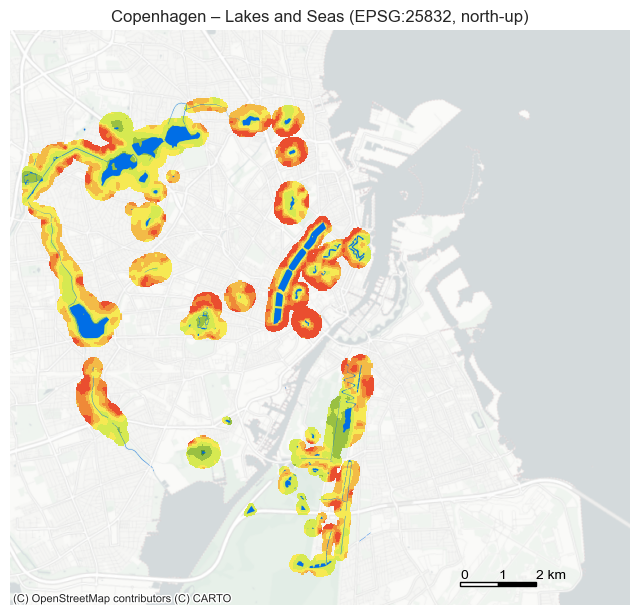

In [48]:
# MAP LST IN OBSERVED TURNING POINT DISTANCES 
from rasterio.transform import array_bounds

# Calculate and map LST in observed turning point zones
with rasterio.open('landsat20180603/lst_20180603_final.tif') as src:
    lst_transform = src.transform

# Make mask (True outside lakes, False inside)
mask_arr = rasterio.features.geometry_mask(
    lakes_positive['geometry_buffered_obs'].apply(mapping),  # use buffered geometry
    invert=True,                             # keep values inside lakes
    transform=lst_transform,
    out_shape=lst.shape
)

# Apply mask
lst_masked = np.where(mask_arr, lst, np.nan)

print("mean of LST is ", np.nanmean(lst_masked))
print("min of LST is ", np.nanmin(lst_masked))
print("max of LST is ", np.nanmax(lst_masked))

# Define class edges and colors
lst_colorbins = [0, 15.0, 16.2, 22.8, 26.1, 27.7, 28.8, 29.7, 38.0]
lst_colors = ["#357127", "#5A9833", "#99C042", "#D6E951", "#F6E953", "#F3BB47", "#EF8938", "#EA4E2F"]

# Classify LST
lst_classes = np.digitize(lst_masked, lst_colorbins, right=False) - 1
lst_classes[np.isnan(lst_masked)] = -1  # mark NoData as -1

# Create masked array: NoData (-1) becomes invisible
lst_plot_masked = np.ma.masked_where(lst_classes < 0, lst_classes)

# Create colormap
lst_cmap = ListedColormap(lst_colors)

# Map over all seas and lakes 
lake_color = "#006EE6"

# Original Copenhagen bbox in WGS84
bbox_wgs84 = box(12.45, 55.61, 12.70, 55.74)

# Project to EPSG:25832
gdf = gpd.GeoDataFrame(geometry=[bbox_wgs84], crs="EPSG:4326").to_crs(epsg=25832)

minx, miny, maxx, maxy = gdf.total_bounds

# Scale bar position (bottom-right)
x_start = maxx - 2000*2 - 500  # shift from edge, in meters
y_start = miny + 500           # shift from bottom, in meters

bar_length = 1000  # 1 km per segment

fig, ax = plt.subplots(figsize=(8, 8))

# Set map extent
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

# --- Basemap: Stamen TonerLite, semi-transparent ---
cx.add_basemap(
    ax,
    source=cx.providers.CartoDB.PositronNoLabels,
    crs="EPSG:25832",  # important: reproject tiles to match axes
    alpha=1.0           # dim basemap, polygons stay vivid
)

# prepare for LST
height, width = lst_plot_masked.shape
xmin2, ymin2, xmax2, ymax2 = array_bounds(height, width, lst_transform)
extent = (xmin2, xmax2, ymin2, ymax2)

# --- LST
cax = ax.imshow(
    lst_plot_masked,
    cmap=lst_cmap,
    interpolation="none",
    extent=extent,
    origin="upper",
    zorder=1
)

# --- Lakes (full color, north-up) ---
lakes[lakes['details'] == "obs cooling"].plot(
    ax=ax,
    facecolor=lake_color,
    edgecolor="none",
    alpha=1.0,
    zorder=2
    )

# --- Draw striped scale bar: 2 segments (1 km white + 1 km black) ---
scale_colors = ["white", "black"]
for i, color in enumerate(scale_colors):
    rect = patches.Rectangle(
        (x_start + i*bar_length, y_start),  # lower-left corner
        bar_length,                          # width
        100,                                 # height of bar (meters)
        facecolor=color,
        edgecolor="black"
    )
    ax.add_patch(rect)

# Add text labels without repeating "km"
ax.text(x_start, y_start + 120, "0", color="black", fontsize=10, va='bottom')
ax.text(x_start + bar_length, y_start + 120, "1", color="black", fontsize=10, va='bottom')
ax.text(x_start + 2*bar_length, y_start + 120, "2 km", color="black", fontsize=10, va='bottom')

# Optional: remove axes
ax.set_axis_off()
plt.title("Copenhagen – Lakes and Seas (EPSG:25832, north-up)")
plt.show()

fig.savefig(
    "map_obs_lst_zones20180603.png",  # file name
    dpi=300,                       # resolution
    bbox_inches="tight",           # remove extra white space
    transparent=False               # set True if you want transparent background
)

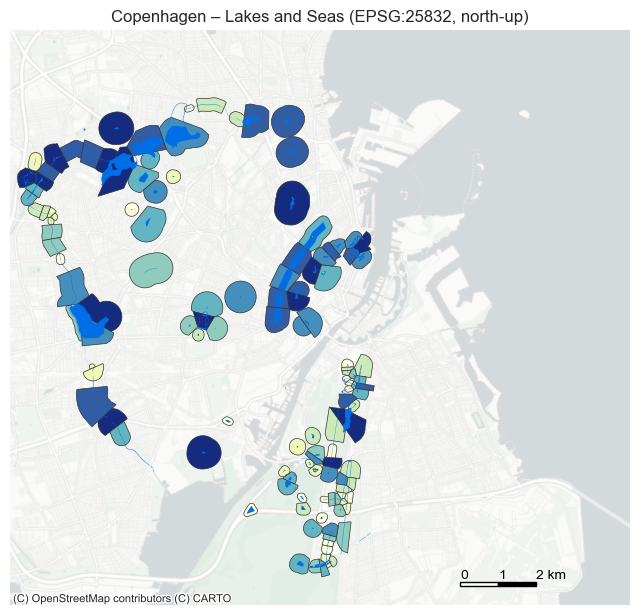

In [49]:
# MAP OBSERVED COOLING EFFECTS
# Create a new geometry column with buffered polygons
#lakes_positive['geometry_buffered_obs'] = lakes_positive.geometry.buffer(lakes_positive['obs_zone']) #obs_dist
centroids = lakes_positive.geometry.centroid

# Create Voronoi diagram with envelope = union of buffered polygons
vor_obs = voronoi_diagram(
    MultiPoint(list(centroids)),
    envelope=lakes_positive['geometry_buffered_obs'].union_all()  # use union_all() instead of unary_union
)

# Convert Voronoi polygons to a GeoDataFrame
vor_obs_gdf = gpd.GeoDataFrame(geometry=list(vor_obs.geoms), crs=lakes_positive.crs)

# Clip each buffer to its Voronoi polygon
buffers_cut = []
# Loop over each lake buffer
for i, buffer_geom in enumerate(lakes_positive['geometry_buffered_obs']):
    centroid = lakes_positive.geometry.iloc[i].centroid  # lake centroid
    # Find the Voronoi polygon that contains this centroid
    matching_cell = vor_obs_gdf[vor_obs_gdf.geometry.contains(centroid)]
    if not matching_cell.empty:
        buffers_cut.append(buffer_geom.intersection(matching_cell.geometry.iloc[0]))
    else:
        # fallback if something went wrong
        buffers_cut.append(buffer_geom)
        
# Create a GeoDataFrame of clipped buffers
vor_obs_gdf_clipped = gpd.GeoDataFrame({
    'geometry': buffers_cut,
    'id': lakes_positive['id'],
    'obs_cooldif': lakes_positive['obs_cooldif']
}, crs=lakes_positive.crs)

# Remove empty geometries (just in case)
vor_obs_gdf_clipped = vor_obs_gdf_clipped[~vor_obs_gdf_clipped.is_empty].reset_index(drop=True)

# Number of classes
n_classes_obs_cool = 8

# Compute quantiles
bufferbins_obs_cool = vor_obs_gdf_clipped['obs_cooldif'].quantile(q=np.linspace(0, 1, n_classes_obs_cool + 1)).values

# Example colors (replace with your preferred palette)
cooling_colors = ["#FFFFDD","#EFF8B9","#CDE8B9","#91CBBC","#64B4C2","#468EBC","#335DA3","#152B7F"]

# Colormap and boundary norm
cooling_cmap = ListedColormap(cooling_colors)
cooling_norm = BoundaryNorm(bufferbins_obs_cool, ncolors=cooling_cmap.N, clip=True)

# Map over all seas and lakes 
lake_color = "#006EE6"

# Original Copenhagen bbox in WGS84
bbox_wgs84 = box(12.45, 55.61, 12.70, 55.74)

# Project to EPSG:25832
gdf = gpd.GeoDataFrame(geometry=[bbox_wgs84], crs="EPSG:4326").to_crs(epsg=25832)

minx, miny, maxx, maxy = gdf.total_bounds

# Scale bar position (bottom-right)
x_start = maxx - 2000*2 - 500  # shift from edge, in meters
y_start = miny + 500           # shift from bottom, in meters

bar_length = 1000  # 1 km per segment

fig, ax = plt.subplots(figsize=(8, 8))

# Set map extent
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

# --- Basemap: Stamen TonerLite, semi-transparent ---
cx.add_basemap(
    ax,
    source=cx.providers.CartoDB.PositronNoLabels,
    crs="EPSG:25832",  # important: reproject tiles to match axes
    alpha=1.0           # dim basemap, polygons stay vivid
)

# --- Cooling effect
vor_obs_gdf_clipped.plot(
    ax=ax,
    column='obs_cooldif',
    cmap=cooling_cmap,
    norm=cooling_norm,
    edgecolor="#343433",
    linewidth=0.5,
    alpha=1.0
)

# --- Lakes (full color, north-up) ---
lakes[lakes['details'] == "obs cooling"].plot(
    ax=ax,
    facecolor=lake_color,
    edgecolor="none",
    alpha=1.0,
    zorder=2
    )

# --- Draw striped scale bar: 2 segments (1 km white + 1 km black) ---
scale_colors = ["white", "black"]
for i, color in enumerate(scale_colors):
    rect = patches.Rectangle(
        (x_start + i*bar_length, y_start),  # lower-left corner
        bar_length,                          # width
        100,                                 # height of bar (meters)
        facecolor=color,
        edgecolor="black"
    )
    ax.add_patch(rect)

# Add text labels without repeating "km"
ax.text(x_start, y_start + 120, "0", color="black", fontsize=10, va='bottom')
ax.text(x_start + bar_length, y_start + 120, "1", color="black", fontsize=10, va='bottom')
ax.text(x_start + 2*bar_length, y_start + 120, "2 km", color="black", fontsize=10, va='bottom')

# Optional: remove axes
ax.set_axis_off()
plt.title("Copenhagen – Lakes and Seas (EPSG:25832, north-up)")
plt.show()

fig.savefig(
    "map_obs_cool_effect20180603.png",  # file name
    dpi=300,                       # resolution
    bbox_inches="tight",           # remove extra white space
    transparent=False               # set True if you want transparent background
)

In [13]:
# class-intervals: 
bufferbins_obs_cool

array([9.27219222e-03, 3.33038886e-01, 8.62647016e-01, 1.31721699e+00,
       2.09591199e+00, 2.91911205e+00, 3.78771772e+00, 4.69376457e+00,
       1.25880291e+01])

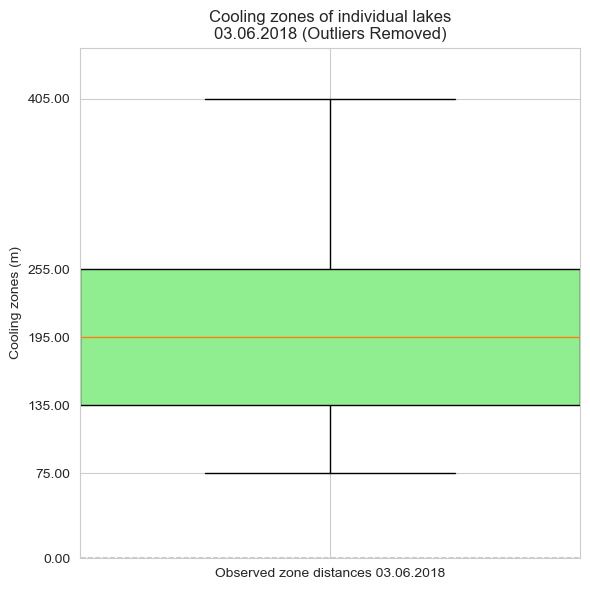

In [50]:
# Box plot over zone effects from individual lakes 
obs_zone_values = lakes_positive["obs_zone"].dropna()

# Compute quartiles
def quartiles_full(res):
    q1, median, q3 = np.percentile(res, [25, 50, 75])
    iqr = q3 - q1
    return {"q1": q1, "median": median, "q3": q3, "iqr": iqr}
stats_obs_zone = quartiles_full(obs_zone_values)

# clip outliers
def clip_whiskers(res, q1, q3):
    iqr = q3 - q1
    lower = q1 - 1.5*iqr
    upper = q3 + 1.5*iqr
    return res[(res >= lower) & (res <= upper)]
stats_obs_zone_clip = clip_whiskers(obs_zone_values, stats_obs_zone["q1"], stats_obs_zone["q3"])

# Plot boxplot
plt.figure(figsize=(6,6))
box_data = [stats_obs_zone_clip]
labels = ["Observed zone distances 03.06.2018"]

bplots = plt.boxplot(
    box_data,
    vert=True,
    showfliers=False,
    widths=0.5,
    patch_artist=True,
    tick_labels=labels
)
# Color boxes
colors = ["lightgreen", "lightblue"]
for patch, color in zip(bplots['boxes'], colors):
    patch.set_facecolor(color)
# Draw quartile lines
box_positions = [1, 2]  # x positions of boxes
for pos, stats_spec in zip(box_positions, [stats_obs_zone]):
    # Width for the median line: half the box width
    box_width = 0.5
    half_width = box_width / 2

# zero reference line
plt.axhline(0, color="black", linestyle="--", linewidth=1)

#Y limits and tics
y_min = stats_obs_zone_clip.min()
y_max = stats_obs_zone_clip.max()
plt.xlim(0.75, 1.25)

# Include Q1, median, Q3 of both boxes + zero
y_ticks = sorted(list(set([
    stats_obs_zone['q1'], stats_obs_zone['median'], stats_obs_zone['q3'],
    y_min, y_max, 0
])))
plt.ylim(0, 450) #y_min, #y_max
plt.yticks(y_ticks, [f"{y:.2f}" for y in y_ticks])

# -----------------------------
# 8. Labels and title
# -----------------------------
plt.ylabel("Cooling zones (m)") 
plt.title("Cooling zones of individual lakes\n03.06.2018 (Outliers Removed)")
plt.tight_layout()
plt.savefig("Fig20180603_boxplot_zones.png", dpi=400, bbox_inches="tight")
plt.show()


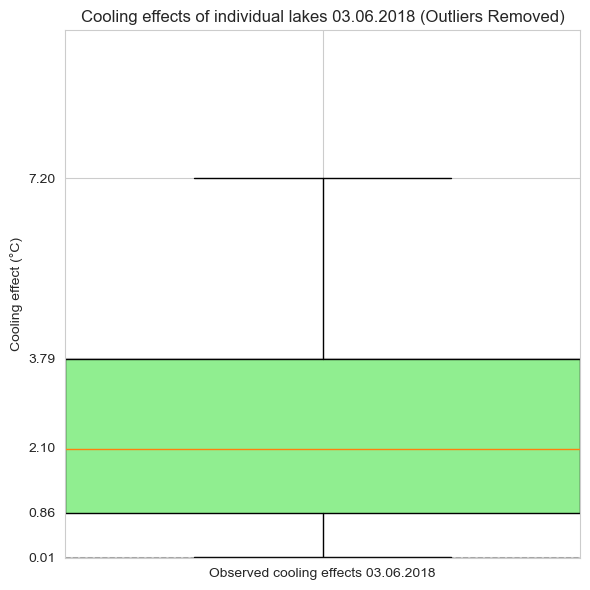

In [51]:
# Box plot over cooling effects from individual lakes
obs_zone_values = lakes_positive["obs_cooldif"].dropna()

# Compute quartiles
def quartiles_full(res):
    q1, median, q3 = np.percentile(res, [25, 50, 75])
    iqr = q3 - q1
    return {"q1": q1, "median": median, "q3": q3, "iqr": iqr}
stats_obs_zone = quartiles_full(obs_zone_values)

# clip outliers
def clip_whiskers(res, q1, q3):
    iqr = q3 - q1
    lower = q1 - 1.5*iqr
    upper = q3 + 1.5*iqr
    return res[(res >= lower) & (res <= upper)]
stats_obs_zone_clip = clip_whiskers(obs_zone_values, stats_obs_zone["q1"], stats_obs_zone["q3"])

# Plot boxplot
plt.figure(figsize=(6,6))
box_data = [stats_obs_zone_clip]
labels = ["Observed cooling effects 03.06.2018"]

bplots = plt.boxplot(
    box_data,
    vert=True,
    showfliers=False,
    widths=0.5,
    patch_artist=True, 
    tick_labels=labels
)
# Color boxes
colors = ["lightgreen", "lightblue"]
for patch, color in zip(bplots['boxes'], colors):
    patch.set_facecolor(color)
# Draw quartile lines
box_positions = [1, 2]  # x positions of boxes
for pos, stats_spec in zip(box_positions, [stats_obs_zone]):
    # Width for the median line: half the box width
    box_width = 0.5
    half_width = box_width / 2

# zero reference line
plt.axhline(0, color="black", linestyle="--", linewidth=1)

#Y limits and tics
y_min = stats_obs_zone_clip.min()
y_max = stats_obs_zone_clip.max()
plt.xlim(0.75, 1.25)

# Include Q1, median, Q3 of both boxes + zero
y_ticks = sorted(list(set([
    stats_obs_zone['q1'], stats_obs_zone['median'], stats_obs_zone['q3'],
    y_min, y_max #, 0
])))
plt.ylim(0, 10) #y_min y_max
plt.yticks(y_ticks, [f"{y:.2f}" for y in y_ticks])

# -----------------------------
# 8. Labels and title
# -----------------------------
plt.ylabel("Cooling effect (°C)") 
plt.title("Cooling effects of individual lakes 03.06.2018 (Outliers Removed)")
plt.tight_layout()
plt.savefig("Fig20180603_boxplot_cooling.png", dpi=400, bbox_inches="tight")
plt.show()


In [52]:
# Centroids
centroids = lakes_positive.geometry.centroid
coords = np.array([[p.x, p.y] for p in centroids])

# Compute pairwise distances
dist_matrix = squareform(pdist(coords))

print("Minimum non-zero distance between centroids (meters):", np.min(dist_matrix[dist_matrix>0]))
print("Maximum distance:", np.max(dist_matrix))

Minimum non-zero distance between centroids (meters): 60.136093681237526
Maximum distance: 13208.62120194824


/opt/anaconda3/lib/python3.13/site-packages/scipy/sparse/_data.py:128: RuntimeWarning: divide by zero encountered in power
  return self._with_data(data ** n)


Sum of weights: 127.0
Min neighbors: 72
Mean neighbors: 110.53543307086615
Observed Moran's I: 0.14239191238797802
Permutation p-value: 0.001


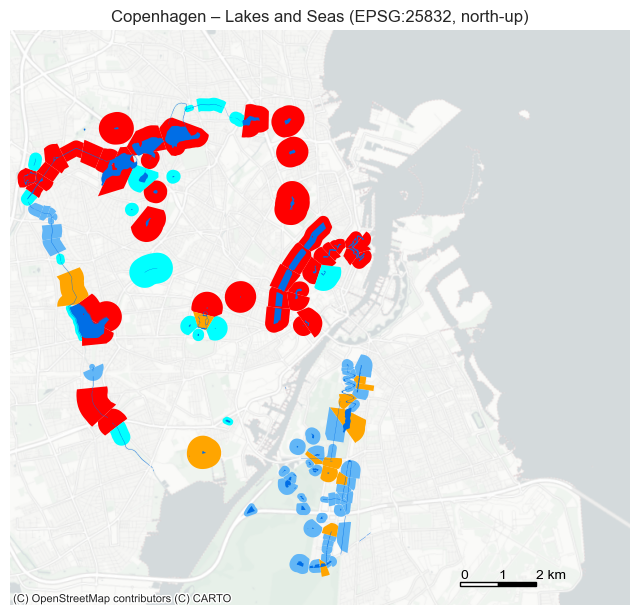

In [53]:
# MORANS I
# Use your actual geometry column to build distance-based weights 
w = DistanceBand.from_dataframe(
    lakes_positive,
    threshold=10000, # 10 km threshold, adjust if needed
    binary=False,
    alpha=-1.0,
    silence_warnings=True,
    geom_col='geometry_buffered_obs'  
)
w.transform = "r"
W = w.full()[0]
# Sanity check
print("Sum of weights:", W.sum())
print("Min neighbors:", min(w.cardinalities.values()))
print("Mean neighbors:", w.mean_neighbors)
if W.sum() == 0:
    raise ValueError("No spatial neighbors found. Increase threshold.")

# function to calculate Moran's I based on x (cooling intensity) and W (weights)  
def moran_I(x, W):
    x = np.asarray(x)
    x = x - x.mean()
    
    den = np.sum(x**2)
    W_sum = W.sum()
    
    if den == 0:
        raise ValueError("Zero variance in variable — Moran's I undefined")
    if W_sum == 0:
        raise ValueError("No spatial neighbors — Moran's I undefined")
    
    n = len(x)
    num = np.sum(W * np.outer(x, x))
    
    return (n / W_sum) * (num / den)

# compute Moran's I based on x (cooling intensity) and W (weights)  
x = lakes_positive["obs_cooldif"].values.astype(float)
I_obs = moran_I(x, W)
print("Observed Moran's I:", I_obs)

# permutation test:   
n_perm = 999
rng = np.random.default_rng(seed=42)
I_perm = np.zeros(n_perm)
for i in range(n_perm):
    x_perm = rng.permutation(x)
    I_perm[i] = moran_I(x_perm, W)
# Two-sided pseudo p-value
p_value = (np.sum(np.abs(I_perm) >= np.abs(I_obs)) + 1) / (n_perm + 1)
print("Permutation p-value:", p_value)

x_std = x - x.mean()
lag_x = W @ x_std
# Add to GeoDataFrame
lakes_positive["x_std"] = x_std
lakes_positive["lag_x"] = lag_x

def moran_quadrant(row):
    if row.x_std > 0 and row.lag_x > 0:
        return "High–High"
    elif row.x_std < 0 and row.lag_x < 0:
        return "Low–Low"
    elif row.x_std > 0 and row.lag_x < 0:
        return "High–Low"
    else:
        return "Low–High"
lakes_positive["moran_quadrant"] = lakes_positive.apply(moran_quadrant, axis=1)

# Define colors for quadrants
quadrant_colors = {
    "High–High": "red",
    "Low–Low": "#62B6F6", #"blue"
    "High–Low": "orange",
    "Low–High": "cyan"
}

#lakes_positive['geometry_buffered_obs'] = lakes_positive.geometry.buffer(lakes_positive['obs_zone']) #obs_dist
centroids = lakes_positive.geometry.centroid

# Create Voronoi diagram with envelope = union of buffered polygons
vor_obs = voronoi_diagram(
    MultiPoint(list(centroids)),
    envelope=lakes_positive['geometry_buffered_obs'].union_all()  # use union_all() instead of unary_union
)

# Convert Voronoi polygons to a GeoDataFrame
vor_obs_gdf = gpd.GeoDataFrame(geometry=list(vor_obs.geoms), crs=lakes_positive.crs)

# Clip each buffer to its Voronoi polygon
buffers_cut = []
# Loop over each lake buffer
for i, buffer_geom in enumerate(lakes_positive['geometry_buffered_obs']):
    centroid = lakes_positive.geometry.iloc[i].centroid  # lake centroid
    # Find the Voronoi polygon that contains this centroid
    matching_cell = vor_obs_gdf[vor_obs_gdf.geometry.contains(centroid)]
    if not matching_cell.empty:
        buffers_cut.append(buffer_geom.intersection(matching_cell.geometry.iloc[0]))
    else:
        # fallback if something went wrong
        buffers_cut.append(buffer_geom)
        
# Create a GeoDataFrame of clipped buffers
vor_obs_gdf_clipped = gpd.GeoDataFrame({
    'geometry': buffers_cut,
    'id': lakes_positive['id'],
    'moran_quadrant': lakes_positive['moran_quadrant']
}, crs=lakes_positive.crs)

# Remove empty geometries (just in case)
vor_obs_gdf_clipped = vor_obs_gdf_clipped[~vor_obs_gdf_clipped.is_empty].reset_index(drop=True)

# Map over all seas and lakes 
lake_color = "#006EE6"

# Original Copenhagen bbox in WGS84
bbox_wgs84 = box(12.45, 55.61, 12.70, 55.74)

# Project to EPSG:25832
gdf = gpd.GeoDataFrame(geometry=[bbox_wgs84], crs="EPSG:4326").to_crs(epsg=25832)

minx, miny, maxx, maxy = gdf.total_bounds

# Scale bar position (bottom-right)
x_start = maxx - 2000*2 - 500  # shift from edge, in meters
y_start = miny + 500           # shift from bottom, in meters

bar_length = 1000  # 1 km per segment

fig, ax = plt.subplots(figsize=(8, 8))

# Set map extent
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

# --- Basemap: Stamen TonerLite, semi-transparent ---
cx.add_basemap(
    ax,
    source=cx.providers.CartoDB.PositronNoLabels,
    crs="EPSG:25832",  # important: reproject tiles to match axes
    alpha=1.0           # dim basemap, polygons stay vivid
)

# --- Cooling effect
vor_obs_gdf_clipped.plot(
    ax=ax,
    color=vor_obs_gdf_clipped['moran_quadrant'].map(quadrant_colors),
    edgecolor="none"
)

# --- Lakes (full color, north-up) ---
lakes[lakes['details'] == "obs cooling"].plot(
    ax=ax,
    facecolor=lake_color,
    edgecolor="none",
    alpha=1.0,
    zorder=2
    )

# --- Draw striped scale bar: 2 segments (1 km white + 1 km black) ---
scale_colors = ["white", "black"]
for i, color in enumerate(scale_colors):
    rect = patches.Rectangle(
        (x_start + i*bar_length, y_start),  # lower-left corner
        bar_length,                          # width
        100,                                 # height of bar (meters)
        facecolor=color,
        edgecolor="black"
    )
    ax.add_patch(rect)

# Add text labels without repeating "km"
ax.text(x_start, y_start + 120, "0", color="black", fontsize=10, va='bottom')
ax.text(x_start + bar_length, y_start + 120, "1", color="black", fontsize=10, va='bottom')
ax.text(x_start + 2*bar_length, y_start + 120, "2 km", color="black", fontsize=10, va='bottom')

# Optional: remove axes
ax.set_axis_off()
plt.title("Copenhagen – Lakes and Seas (EPSG:25832, north-up)")
plt.show()

fig.savefig(
    "map_cooldif_morans_i_20180603.png",  # file name
    dpi=300,                       # resolution
    bbox_inches="tight",           # remove extra white space
    transparent=False               # set True if you want transparent background
)

#Red (HH) → strong cooling zones surrounded by strong cooling neighbors

#Blue (LL) → weak cooling zones surrounded by weak cooling neighbors

#Orange (HL) / Cyan (LH) → spatial outliers (opposite pattern to neighbors)

In [54]:
# Merge only the column of interest
lakes = lakes_positive.merge(
    lakes_positive[['id', 'obs_zone', 'obs_cooldif', 'moran_quadrant']],  # columns to copy
    on='id',                # join on this column
    how='left'              # keep all rows in lakes
)

In [55]:
# CALCULATION OF NEAREST EUCLIDEAN DISTANCE FROM LAKES TO OTHER WATERBODIESAND ADD AS COLUMN
lakes_for_analysis = lakes.copy()

# Nearest lake to lake
dist_matrix = lakes_for_analysis.geometry.apply(
    lambda g: lakes_for_analysis.geometry.distance(g)
)

nearest_shore_dist = (
    dist_matrix
    .replace(0, np.nan)
    .min(axis=1)
)

lakes_for_analysis["nearest_lake_shore_dist"] = nearest_shore_dist
#print(lakes_for_analysis["nearest_lake_shore_dist"])

# Nearest lake to sea 
seas_for_analysis = gpd.read_file("analysis_input_data/seas.shp") # all sea polygons with attribute data
seas_for_analysis = seas_for_analysis[seas_for_analysis.geometry.notna()].copy()

lakes_for_analysis["nearest_sea_dist"] = lakes_for_analysis.geometry.apply(
    lambda g: seas_for_analysis.geometry.distance(g).min()
)

#print(lakes_for_analysis["nearest_sea_dist"])

# Nearest lake to waterbody 
lakes_for_analysis["nearest_waterbody_dist"] = lakes_for_analysis[
    ["nearest_lake_shore_dist", "nearest_sea_dist"]
].min(axis=1)

lakes_for_analysis = lakes_for_analysis[['id', 'nearest_waterbody_dist']]
print(lakes_for_analysis)

lakes = lakes.merge(
    lakes_for_analysis,
    on='id',
    how='left'
)

       id  nearest_waterbody_dist
0    1138              204.618371
1    1140                3.213572
2     517              327.657476
3     516                8.379037
4     199              652.492608
..    ...                     ...
122  1241              163.811097
123  1239              163.811097
124  1234               16.726190
125  1235               16.726190
126  1237              199.499833

[127 rows x 2 columns]


In [56]:
# CALCULATE OTHER VARIABLES AT LAKE LEVEL (NOT BIN DIFFERENCES) AND ADD AS ATTRIBUTES:  

# We have in lakes_positive: 
# 'obs_zone': turning point distance
# 'obs_cooldif': turning point effects
# 'area_ha': lake size 
# 'perimeter': perimeter
# 'nearest_waterbody_dist': nearest distance to waterbody for all lakes 

# We now calculate: 
# 'mean_lst_400m': LST within 30-400m
# 'mean_mndwi_400m': MNDWI within 30-400m
# "mean_ndvi_400m": NDVI within 30-400m
# "mean_herbperc_400m": herb pecentage within 30-400m
# "mean_forestperc_400m": forest pecentage within 30-400m
# "imp": imperviousness 2018 within 30-400m
# "lsi": landscape shape index

### Analysis 6B: Mean LST increase at turning point from bin 30-60 as a function of lake size 
# Define distance bins (0-30, 30-60, ..., 390-420)
##bins = np.arange(30, 450, 30)  # Bins: [0, 30, 60, ..., 420]
##bin_labels = bins[:-1] + 15  # Midpoints of each bin for plotting

# Get all unique lake IDs from the filtered lakes, ignoring NaNs
unique_ids = lakes['id']

# Create a new column filled with NaNs
lakes["mean_lst_400m"] = np.nan
lakes["mean_mndwi_400m"] = np.nan
lakes["mean_ndvi_400m"] = np.nan
lakes["mean_imp_400m"] = np.nan
lakes["herbm2_400m"] = np.nan
lakes["forestm2_400m"] = np.nan
lakes["LSI"] = np.nan

# Iterate through each unique lake ID from the filtered lakes
for lake_id in unique_ids:

    base_mask = (lakes_source_near == lake_id) & (lake_dist < 400) & (lake_dist >= 30) & ~np.isnan(lake_dist) & ~np.isnan(lst) & (seas_case != 1) & (sea_dist > 195)

    if np.sum(base_mask) == 0:
        continue

    raster_mean_lst_400m_vals = lst[base_mask]
    raster_mean_mndwi_400m_vals = mndwi[base_mask]
    raster_mean_ndvi_400m_vals = ndvi[base_mask]
    raster_mean_imp_400m_vals = imp[base_mask]
    raster_herbm2_400m_vals = herb_perc[base_mask]
    raster_forestm2_400m_vals = forest_perc[base_mask]
    
    if raster_mean_lst_400m_vals.size > 0:
        # Assign ONLY to this lake_id
        lake_row = lakes["id"] == lake_id
        mean_lst   = np.nanmean(lst[base_mask])
        mean_mndwi = np.nanmean(mndwi[base_mask])
        mean_ndvi  = np.nanmean(ndvi[base_mask])
        mean_imp   = np.nanmean(imp[base_mask])
        herbm2 = ((np.nansum(raster_herbm2_400m_vals))/100*90) #90m2 has a value of 100 so to get it in m2 we do this conversion to m2
        forestm2 = ((np.nansum(raster_forestm2_400m_vals))/100*90) #90m2 has a value of 100 so to get it in m2 we do this conversion to m2
        lakes.loc[lake_row, "mean_lst_400m"] = mean_lst
        lakes.loc[lake_row, "mean_mndwi_400m"] = mean_mndwi
        lakes.loc[lake_row, "mean_ndvi_400m"] = mean_ndvi
        lakes.loc[lake_row, "mean_imp_400m"] = mean_imp
        lakes.loc[lake_row, "herbm2_400m"] = herbm2
        lakes.loc[lake_row, "forestm2_400m"] = forestm2
        # LSI (can be computed once, but safe here)
        lakes.loc[lake_row, "LSI"] = (0.25 * lakes.loc[lake_row, "perimeter"]/ np.sqrt(lakes.loc[lake_row, "area_ha"]))


In [536]:
lakes.describe()

fid_           id     area_ha    perimeter    obs_dist     obs_lst  \
count  127.0   127.000000  127.000000   127.000000  127.000000  127.000000   
mean     0.0   578.370079    6.460851   717.661417  147.047244   21.231837   
std      0.0   392.697040   19.508453   783.701223  104.026771   11.948543   
min      0.0   199.000000    0.015923    63.000000    0.000000    0.000000   
25%      0.0   279.500000    0.389032   259.000000   75.000000   23.653039   
50%      0.0   358.000000    1.226447   404.000000  165.000000   27.486907   
75%      0.0  1139.000000    2.910124   784.000000  225.000000   28.553406   
max      0.0  1241.000000  145.341691  4230.000000  345.000000   31.550044   

         est_dist     est_lst  herbCross  herbCoolCr  ...  \
count  127.000000  127.000000        9.0        20.0  ...   
mean   208.369959   27.263756        1.0         1.0  ...   
std     22.760105    1.676356        0.0         0.0  ...   
min    145.394276   16.658248        1.0         1.0  ...   
25%    190.948375   26.364077        1.0         1.0  ...   
50%    207.315665   27.364093        1.0         1.0  ...   
75%    219.630561   28.485200        1.0         1.0  ...   
max    275.378511   30.120438        1.0         1.0  ...   

       nearest_waterbody_dist  mean_lst_400m  mean_mndwi_400m  mean_ndvi_400m  \
count              127.000000     127.000000       127.000000      127.000000   
mean               106.339422      27.422570        -0.222598        0.240740   
std                194.039103       1.601941         0.089239        0.098105   
min                  3.213572      23.000520        -0.401459        0.072254   
25%                  8.068388      26.439669        -0.291318        0.149418   
50%                 17.355868      27.725308        -0.235109        0.255392   
75%                119.669678      28.519880        -0.139212        0.319014   
max               1124.300929      31.184613        -0.062006        0.452589   

       mean_imp_400m  mean_herbperc_400m  mean_forestperc_400m         LSI  \
count     127.000000               127.0                 127.0  127.000000   
mean       51.404749                 0.0                   0.0  113.029098   
std        27.138744                 0.0                   0.0   66.155988   
min         0.000000                 0.0                   0.0   52.112154   
25%        33.135752                 0.0                   0.0   67.699025   
50%        50.640368                 0.0                   0.0   89.505381   
75%        74.125725                 0.0                   0.0  125.787078   
max        98.341420                 0.0                   0.0  330.910315   

        herbm2_400m  forestm2_400m  
count    127.000000     127.000000  
mean    1372.259055     266.045669  
std     5683.405889    1524.131945  
min        0.000000       0.000000  
25%        0.000000       0.000000  
50%        0.000000       0.000000  
75%        0.000000       0.000000  
max    51088.500000   11635.200000  

[8 rows x 28 columns]

In [135]:
#df_pca.describe()


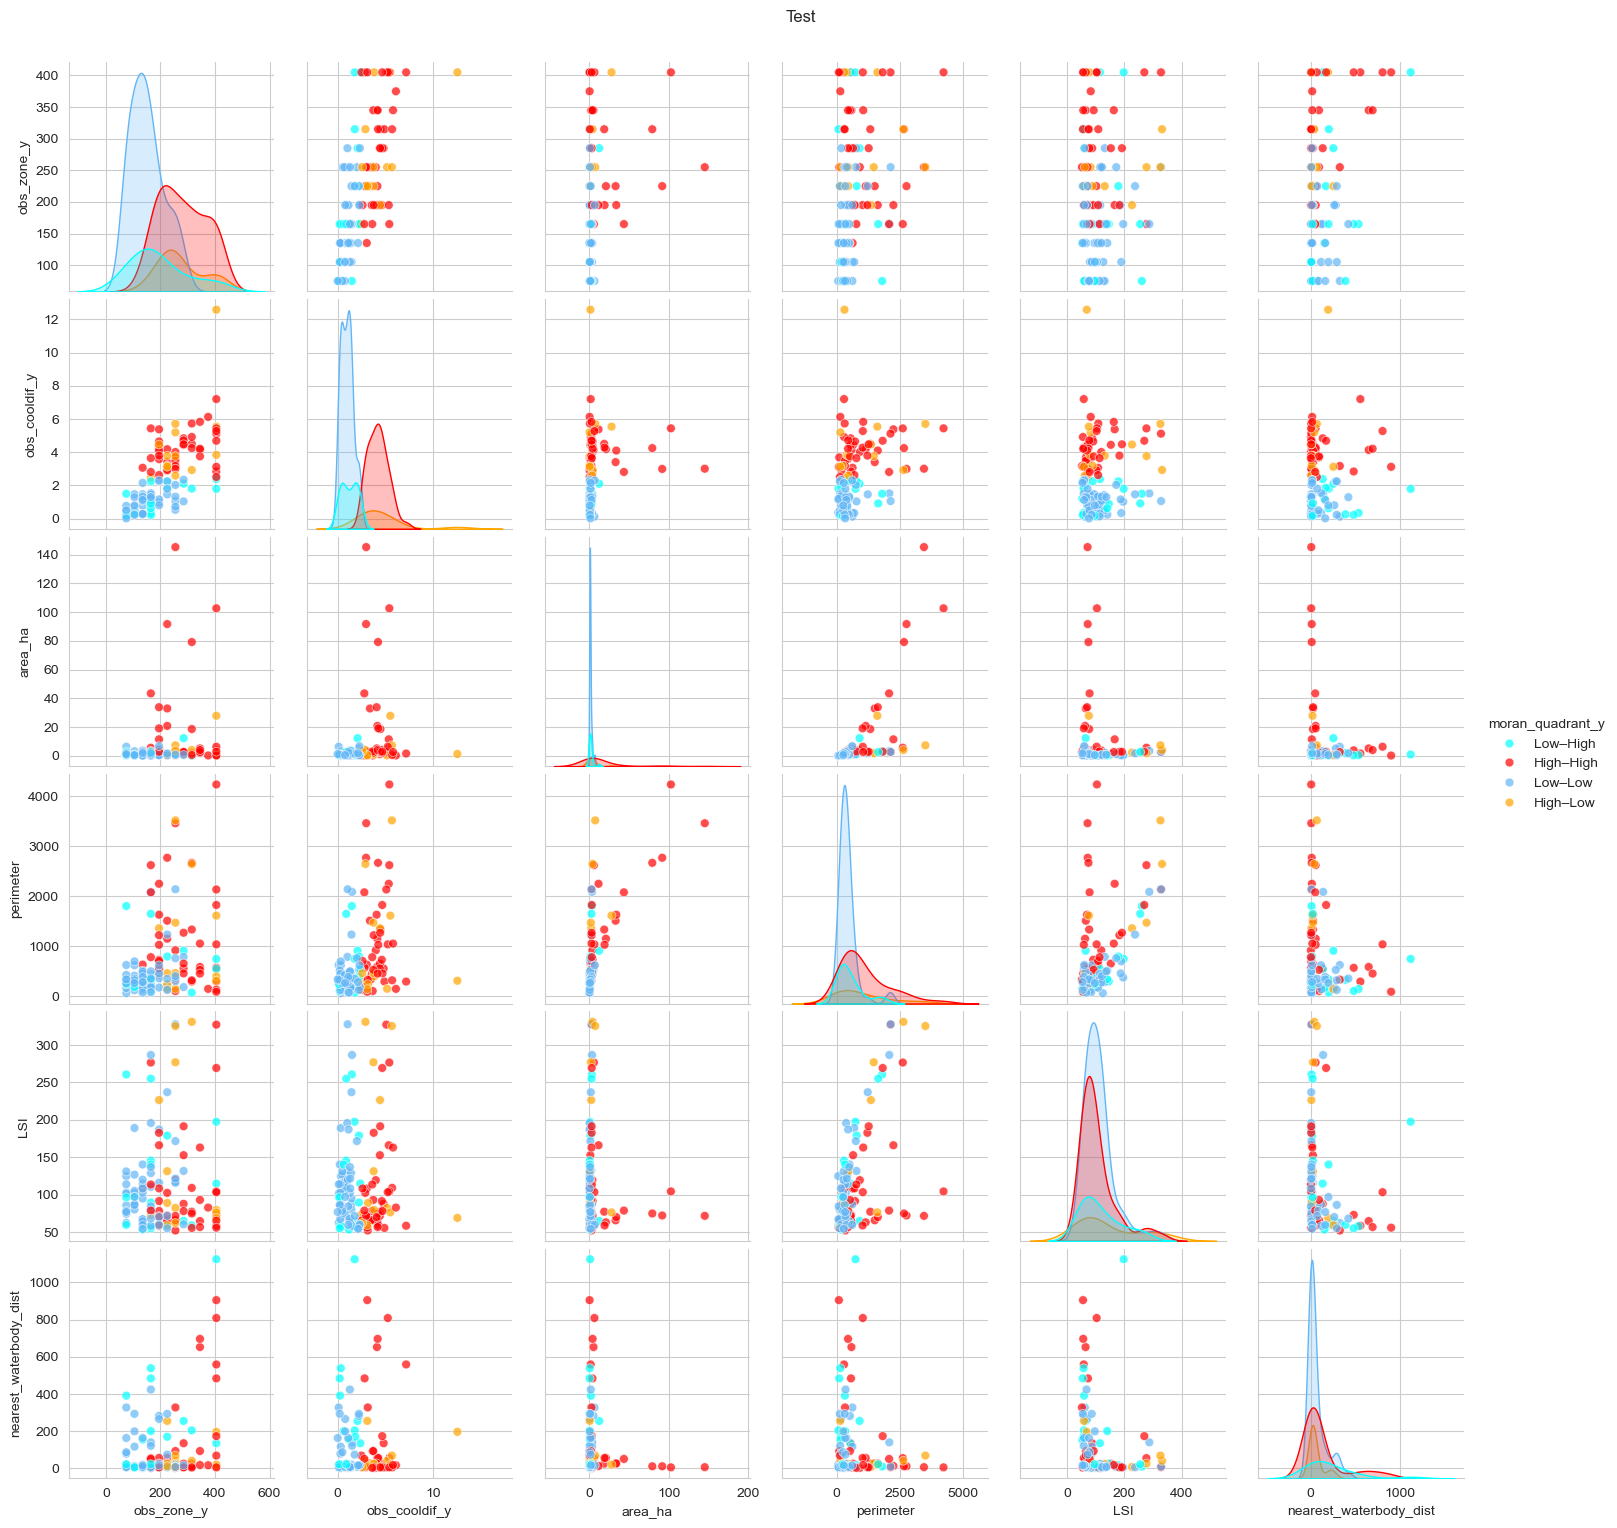

In [57]:
# Pairwise plot of potential components to correlate with observed cooling zone and cooling effect: 
# Lake characteristics 

vars_to_plot = ['obs_zone_y', # 'obs_zone_y'
                'obs_cooldif_y', #'obs_cooldif_y'
                'area_ha',
                'perimeter', 
                'LSI',
                'nearest_waterbody_dist',
                #'mean_lst_400m', 
                #'mean_mndwi_400m', 
                #'mean_ndvi_400m'
               ]

n_pairs = len(vars_to_plot) - 1

quadrant_colors = {
    "High–High": "red",
    "Low–Low": "#62B6F6",
    "High–Low": "orange",
    "Low–High": "cyan"
}

# Select numeric columns for PCA, drop rows with missing values
df_vars = lakes[vars_to_plot].dropna()

# Extract Moran quadrant for coloring
quadrant_index = lakes.loc[df_vars.index, 'moran_quadrant_y'] #'moran_quadrant_y'
colors = quadrant_index.map(quadrant_colors)


df_vars_to_plot = pd.DataFrame(
    df_vars,
    columns=vars_to_plot,
    index=df_vars.index
)

df_vars_to_plot["moran_quadrant_y"] = quadrant_index.values

plt.close("all")
#Plot
sns.set_style("whitegrid")

sns.pairplot(
    df_vars_to_plot,
    vars=vars_to_plot,
    hue="moran_quadrant_y",
    palette=quadrant_colors,
    plot_kws={"alpha": 0.7, "s": 40}
)

plt.suptitle("Test", y=1.02)
plt.savefig(
    "plot20180603_pairwise_lakedesc.png",  # file name
    dpi=300,                       # resolution
    bbox_inches="tight",           # remove extra white space
    transparent=False               # set True if you want transparent background
)
plt.show()



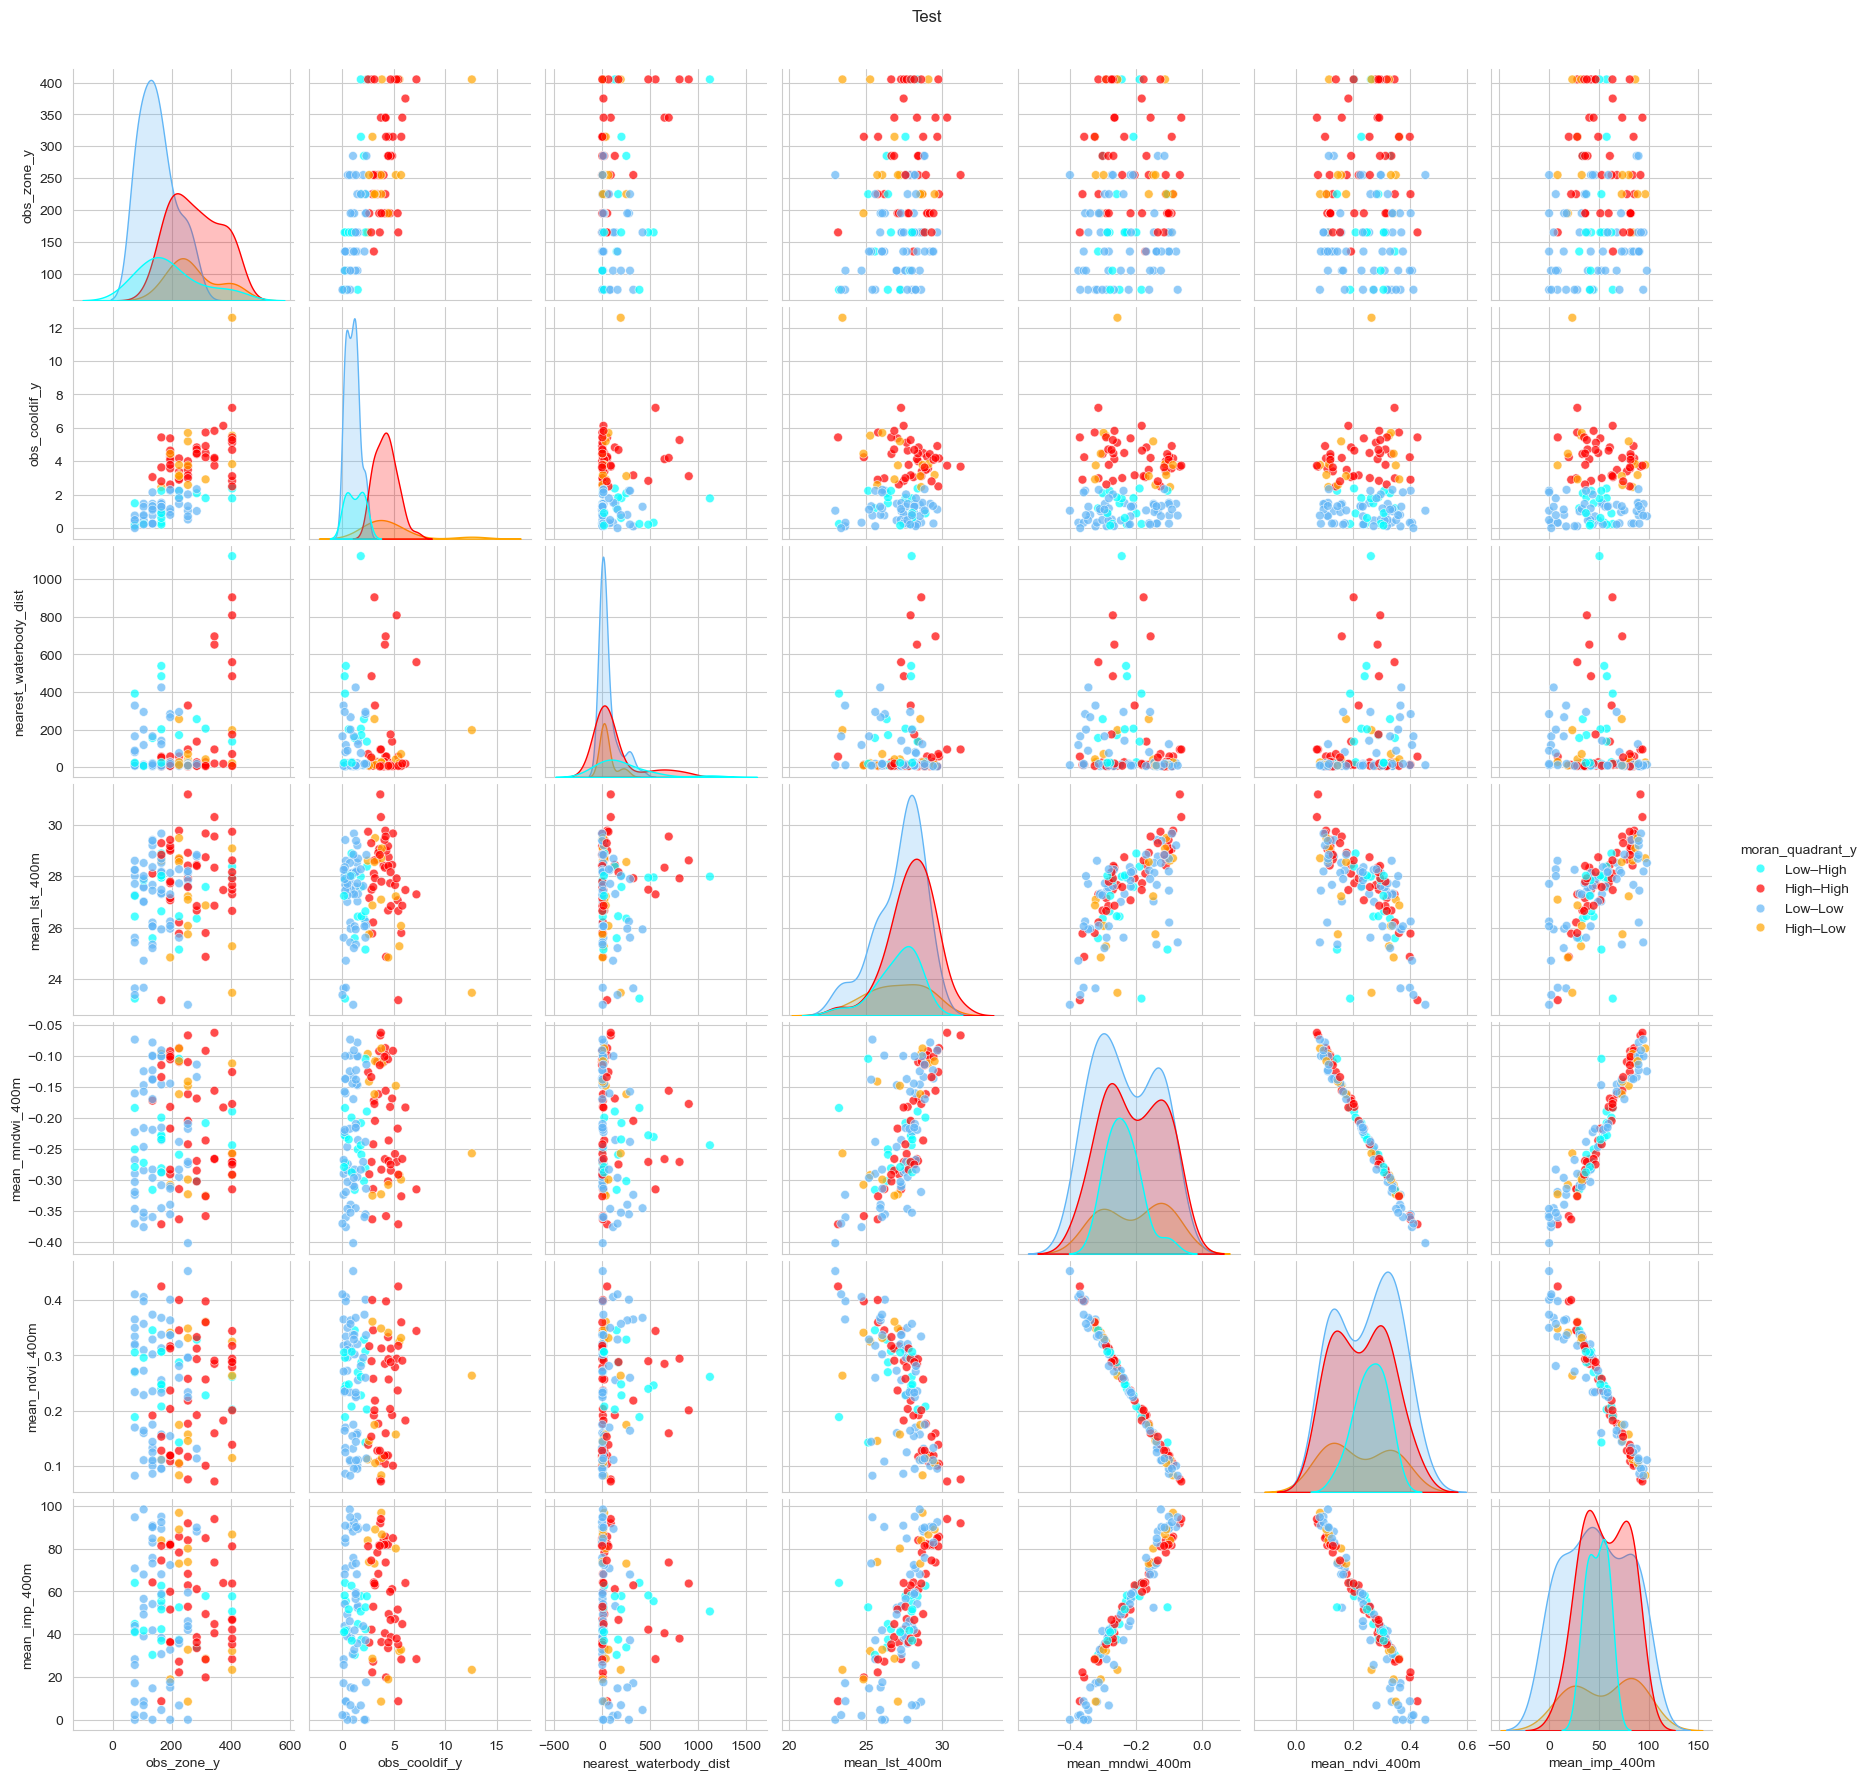

In [58]:
# Pairwise plot of potential components to correlate with observed cooling zone and cooling effect: 
# Background varialbes 

vars_to_plot = ['obs_zone_y',
                'obs_cooldif_y',
                #'area_ha',
                #'perimeter', 
                #'LSI',
                'nearest_waterbody_dist',
                'mean_lst_400m', 
                'mean_mndwi_400m', 
                'mean_ndvi_400m',
                'mean_imp_400m', 
                #'herbm2_400m',
                #'forestm2_400m'
               ]

n_pairs = len(vars_to_plot) - 1

quadrant_colors = {
    "High–High": "red",
    "Low–Low": "#62B6F6",
    "High–Low": "orange",
    "Low–High": "cyan"
}

# Select numeric columns for PCA, drop rows with missing values
df_vars = lakes[vars_to_plot].dropna()

# Extract Moran quadrant for coloring
quadrant_index = lakes.loc[df_vars.index, 'moran_quadrant_y']
colors = quadrant_index.map(quadrant_colors)


df_vars_to_plot = pd.DataFrame(
    df_vars,
    columns=vars_to_plot,
    index=df_vars.index
)

df_vars_to_plot["moran_quadrant_y"] = quadrant_index.values

plt.close("all")
# Plot
sns.set_style("whitegrid")

sns.pairplot(
    df_vars_to_plot,
    vars=vars_to_plot,
    hue="moran_quadrant_y",
    palette=quadrant_colors,
    plot_kws={"alpha": 0.7, "s": 40}
)

plt.suptitle("Test", y=1.02)
plt.savefig(
    "plot20180603_pairwise_backgroundvar.png",  # file name
    dpi=300,                       # resolution
    bbox_inches="tight",           # remove extra white space
    transparent=False               # set True if you want transparent background
)
plt.show()




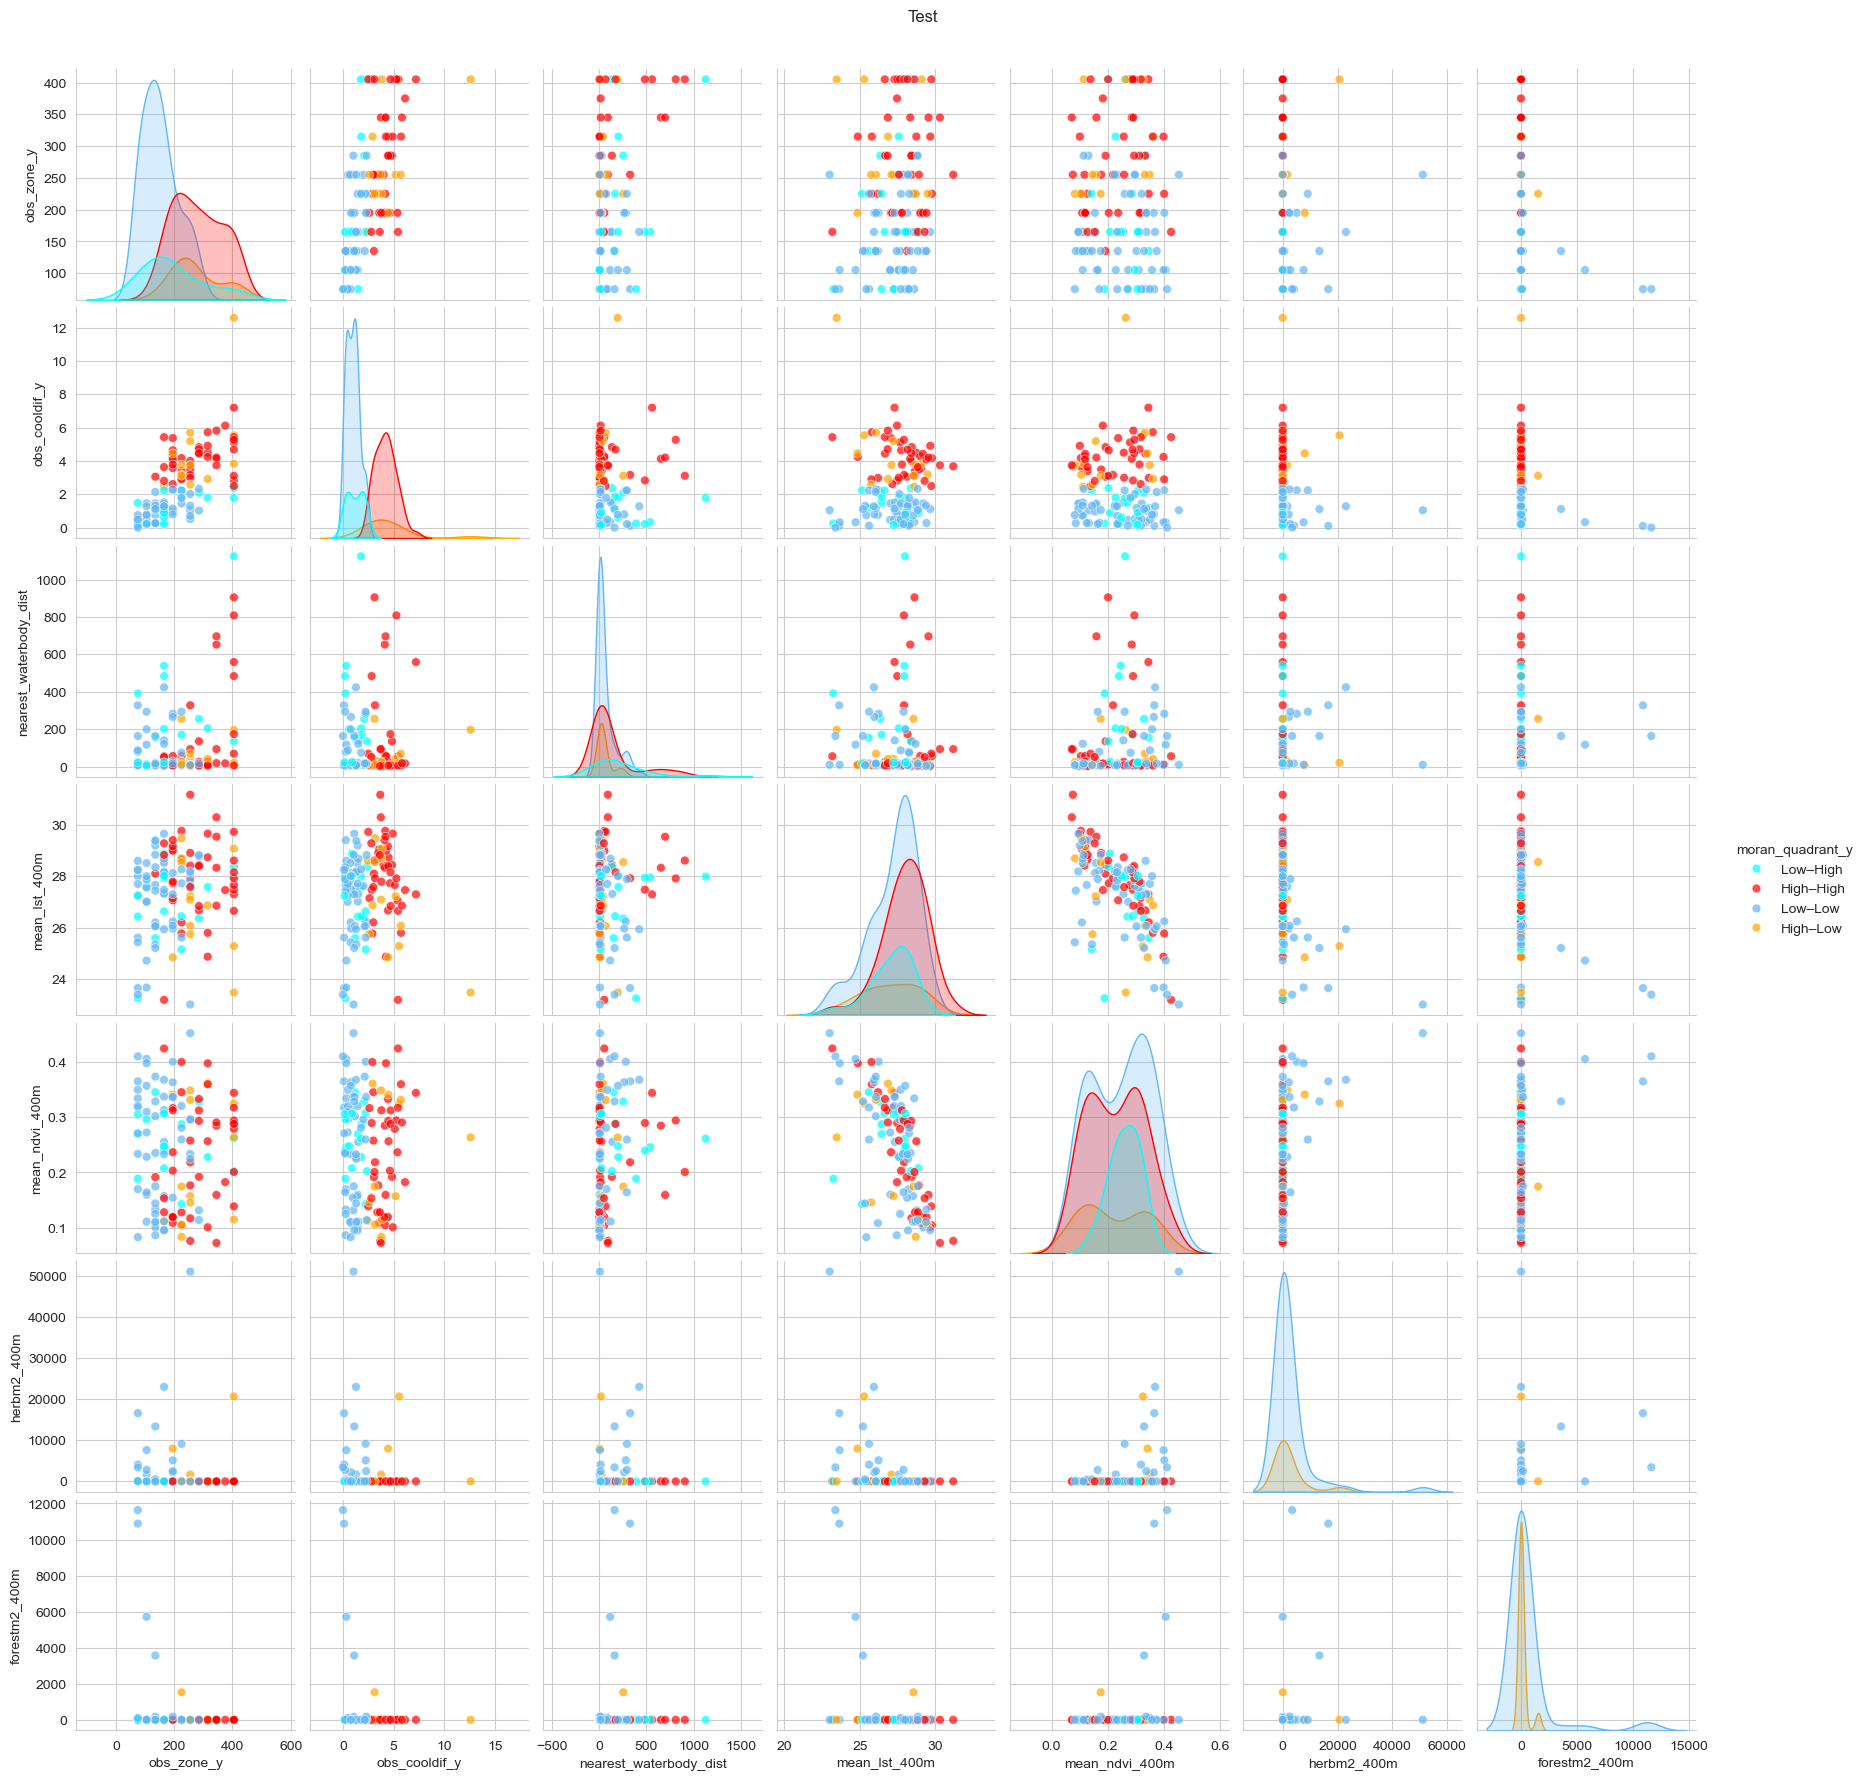

In [59]:
# Pairwise plot of potential components to correlate with observed cooling zone and cooling effect: 
# Vegetation varialbes 

vars_to_plot = ['obs_zone_y',
                'obs_cooldif_y',
                #'area_ha',
                #'perimeter', 
                #'LSI',
                'nearest_waterbody_dist',
                'mean_lst_400m', 
                #'mean_mndwi_400m', 
                'mean_ndvi_400m',
                #'mean_imp_400m', 
                'herbm2_400m',
                'forestm2_400m']

n_pairs = len(vars_to_plot) - 1

quadrant_colors = {
    "High–High": "red",
    "Low–Low": "#62B6F6",
    "High–Low": "orange",
    "Low–High": "cyan"
}

# Select numeric columns for PCA, drop rows with missing values
df_vars = lakes[vars_to_plot].dropna()

# Extract Moran quadrant for coloring
quadrant_index = lakes.loc[df_vars.index, 'moran_quadrant_y']
colors = quadrant_index.map(quadrant_colors)


df_vars_to_plot = pd.DataFrame(
    df_vars,
    columns=vars_to_plot,
    index=df_vars.index
)

df_vars_to_plot["moran_quadrant_y"] = quadrant_index.values

plt.close("all")
# Plot
sns.set_style("whitegrid")

sns.pairplot(
    df_vars_to_plot,
    vars=vars_to_plot,
    hue="moran_quadrant_y",
    palette=quadrant_colors,
    plot_kws={"alpha": 0.7, "s": 40}
)

plt.suptitle("Test", y=1.02)
plt.savefig(
    "plot20180603_pairwise_backgroundvar.png",  # file name
    dpi=300,                       # resolution
    bbox_inches="tight",           # remove extra white space
    transparent=False               # set True if you want transparent background
)
plt.show()




Explained variance by PCs: [0.44538968 0.19012008 0.12868093 0.0923155 ]


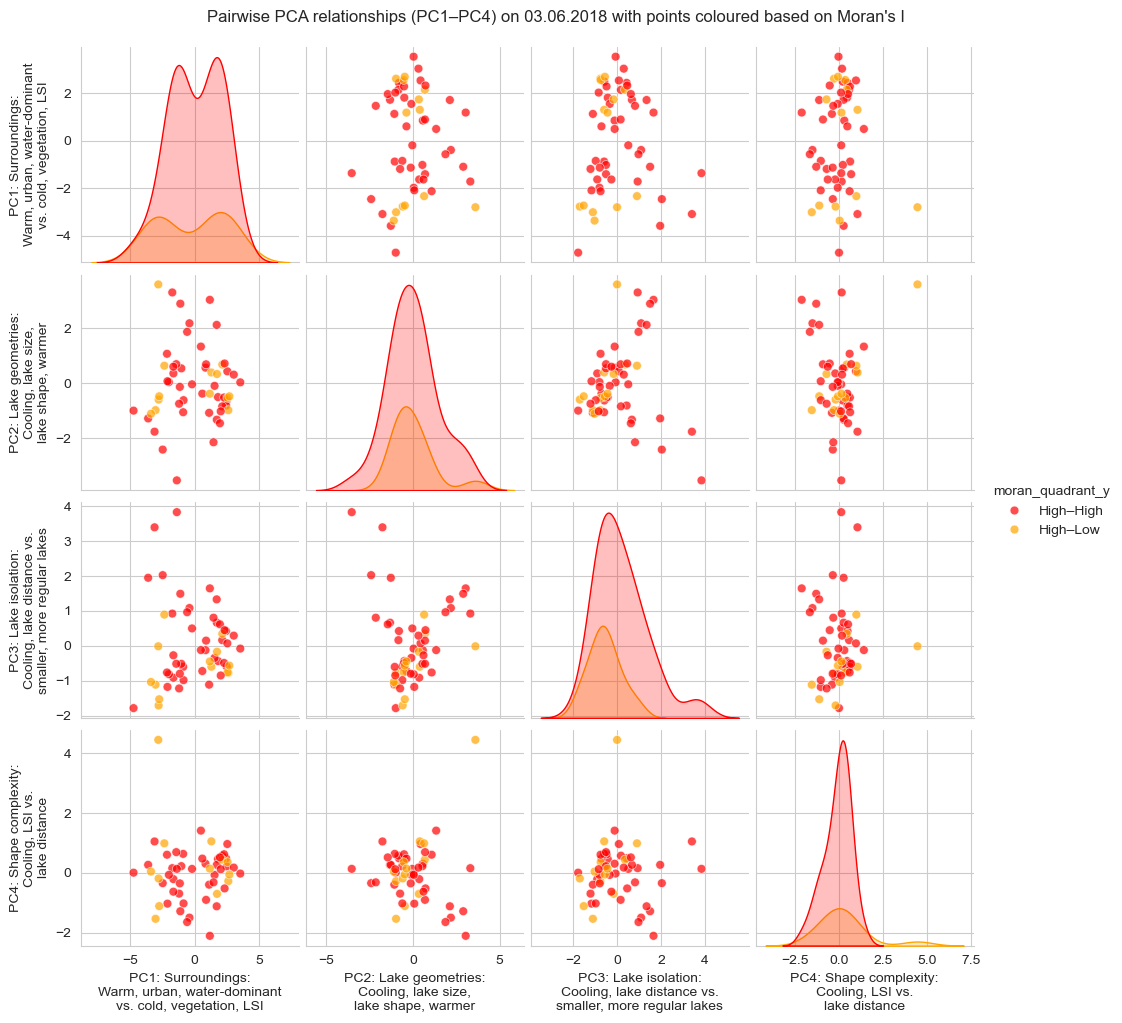

     obs_zone_y  obs_cooldif_y   area_ha  perimeter       LSI  \
PC1   -0.113279      -0.184772 -0.127754  -0.283836 -0.272822   
PC2    0.482386       0.340418 -0.408226  -0.432807 -0.141003   
PC3    0.377195      -0.015515  0.669652   0.295562 -0.439652   
PC4    0.052055       0.766533  0.114030   0.013862 -0.187396   

     nearest_waterbody_dist  mean_lst_400m  mean_mndwi_400m  mean_ndvi_400m  \
PC1                0.007352       0.401914         0.454352       -0.453960   
PC2                0.513391      -0.025451        -0.068557        0.049366   
PC3                0.334303       0.116600         0.016943       -0.024732   
PC4               -0.459094      -0.257738         0.184870       -0.196550   

     mean_imp_400m  
PC1       0.455639  
PC2      -0.078812  
PC3       0.046332  
PC4       0.106771  


In [60]:
# Principle components analysis on more cooling lakes 

vars_to_plot = [
    'obs_zone_y', #justified
    'obs_cooldif_y', #justified
    'area_ha', #justified
    'perimeter', #justified
    'LSI', # split pattern
    'nearest_waterbody_dist', #justified
    'mean_lst_400m', #justified
    'mean_mndwi_400m', 
    'mean_ndvi_400m',
    'mean_imp_400m' #,
    #'herbm2_400m',
    #'forestm2_400m'
]

quadrant_colors = {
    "High–High": "red",
    "Low–Low": "#62B6F6",
    "High–Low": "orange",
    "Low–High": "cyan"
}

# -------------------------
# PREPARE DATA
# -------------------------

# Select numeric columns for PCA, drop rows with missing values
df_pca = (lakes.loc[lakes["moran_quadrant_y"].isin(["High–High", "High–Low"]), vars_to_plot].dropna()
)

# Extract Moran quadrant for coloring
quadrant = lakes.loc[df_pca.index, "moran_quadrant_y"]
colors = quadrant.map(quadrant_colors)

# Standardize the data
X_scaled = StandardScaler().fit_transform(df_pca)

# -------------------------
# RUN PCA
# -------------------------

pca = PCA(n_components=4)  # decides number of principal components
X_pca = pca.fit_transform(X_scaled)

print("Explained variance by PCs:", pca.explained_variance_ratio_)

# -------------------------
# PLOT RESULTS
# -------------------------
# Create PCA score DataFrame
df_scores = pd.DataFrame(
    X_pca,
    columns=["PC1", "PC2", "PC3", "PC4"],
    index=df_pca.index
)

df_scores["moran_quadrant_y"] = quadrant.values

# Example: custom PC labels
custom_labels = {
    "PC1": "PC1: Surroundings:\nWarm, urban, water-dominant\nvs. cold, vegetation, LSI",
    "PC2": "PC2: Lake geometries:\nCooling, lake size,\nlake shape, warmer",
    "PC3": "PC3: Lake isolation:\nCooling, lake distance vs.\nsmaller, more regular lakes",
    "PC4": "PC4: Shape complexity:\nCooling, LSI vs.\nlake distance"
}

# Make a temporary copy of df_scores with renamed columns
df_plot = df_scores.rename(columns=custom_labels)

# -------------------------
# PAIRPLOT
# -------------------------

plt.close("all")
sns.set_style("whitegrid")

sns.pairplot(
    df_plot,
    vars=list(custom_labels.values()), #["PC1", "PC2", "PC3", "PC4"],
    hue="moran_quadrant_y",
    palette=quadrant_colors,
    plot_kws={"alpha": 0.7, "s": 40}
)

plt.suptitle("Pairwise PCA relationships (PC1–PC4) on 03.06.2018 with points coloured based on Moran's I", y=1.02)
plt.savefig(
    "20180603pca_result_graph.png",  # file name
    dpi=400,                       # resolution
    bbox_inches="tight",           # remove extra white space
    transparent=False               # set True if you want transparent background
)
plt.show()

loadings_all = pd.DataFrame(
    pca.components_,
    columns=vars_to_plot,  # <-- make sure this is the same list used in PCA
    index=[f'PC{i+1}' for i in range(4)]  # match n_components=4
)

print(loadings_all.loc[["PC1", "PC2", "PC3", "PC4"]])    


Explained variance by PCs: [0.37145693 0.21986434 0.14835141 0.10679837]


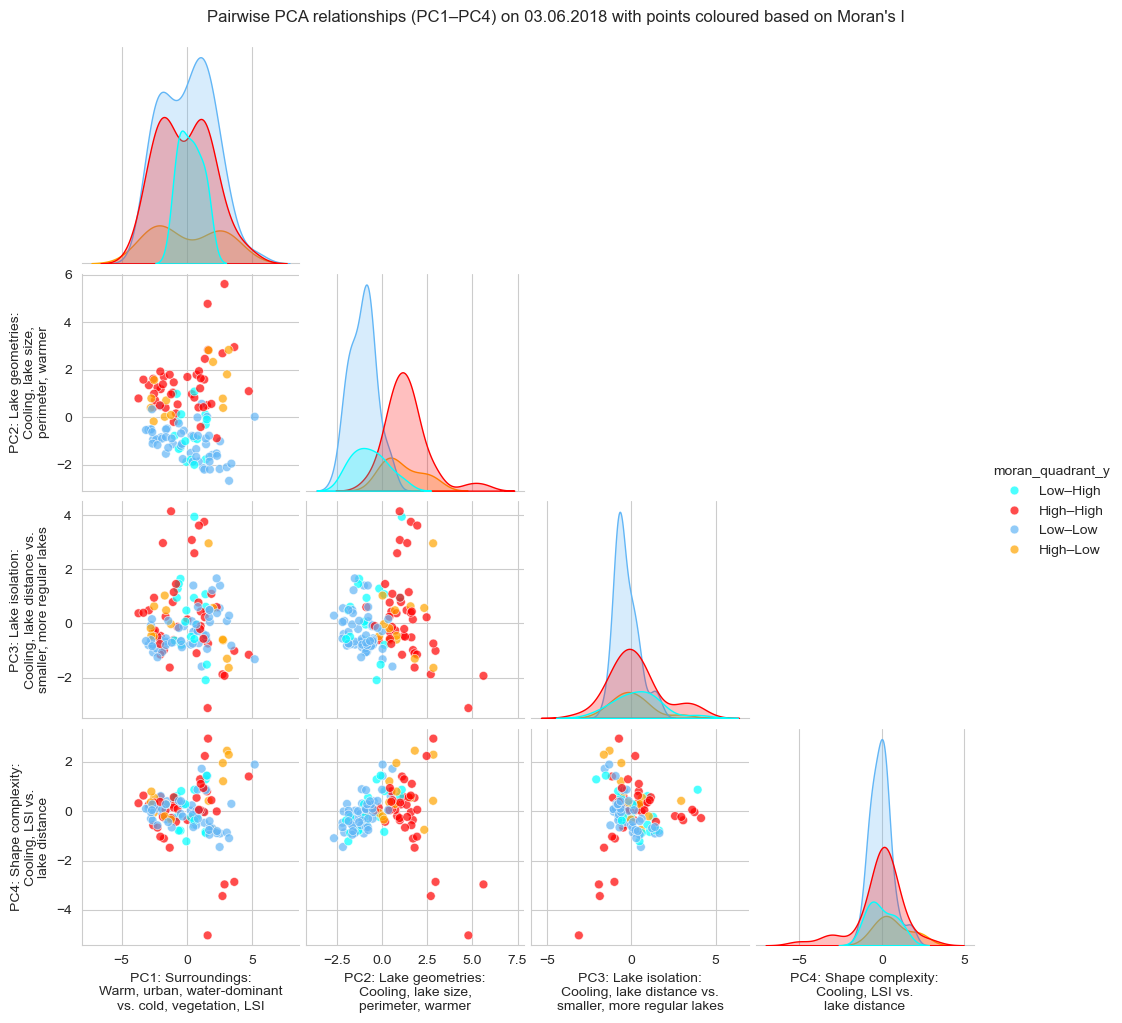

     obs_zone_y  obs_cooldif_y   area_ha  perimeter       LSI  \
PC1    0.011317       0.032575  0.106270   0.239314  0.228135   
PC2    0.517823       0.528915  0.400252   0.472280  0.126642   
PC3    0.410192       0.231135 -0.276171  -0.365708 -0.311667   
PC4    0.171736       0.146855 -0.649888  -0.035459  0.705994   

     nearest_waterbody_dist  mean_lst_400m  mean_mndwi_400m  mean_ndvi_400m  \
PC1                0.035131      -0.382071        -0.495391        0.500115   
PC2                0.033253       0.124288         0.108424       -0.092194   
PC3                0.662101       0.003936        -0.101240        0.094932   
PC4               -0.102689       0.116126         0.022086       -0.019003   

     mean_imp_400m  
PC1      -0.485244  
PC2       0.126535  
PC3      -0.116254  
PC4       0.044966  


In [62]:
# Principle components analysis 

vars_to_plot = [
    'obs_zone_y', #justified
    'obs_cooldif_y', #justified
    'area_ha', #justified
    'perimeter', #justified
    'LSI', # split pattern
    'nearest_waterbody_dist', #justified
    'mean_lst_400m', #justified
    'mean_mndwi_400m', 
    'mean_ndvi_400m',
    'mean_imp_400m' #,
    #'herbm2_400m',
    #'forestm2_400m'
]

quadrant_colors = {
    "High–High": "red",
    "Low–Low": "#62B6F6",
    "High–Low": "orange",
    "Low–High": "cyan"
}

# -------------------------
# PREPARE DATA
# -------------------------

# Select numeric columns for PCA, drop rows with missing values
df_pca = lakes[vars_to_plot].dropna()

# Extract Moran quadrant for coloring
quadrant = lakes.loc[df_pca.index, 'moran_quadrant_y']
colors = quadrant.map(quadrant_colors)

# Standardize the data
X_scaled = StandardScaler().fit_transform(df_pca)

# -------------------------
# RUN PCA
# -------------------------

pca = PCA(n_components=4)  # decides number of principal components
X_pca = pca.fit_transform(X_scaled)

print("Explained variance by PCs:", pca.explained_variance_ratio_)

# -------------------------
# PLOT RESULTS
# -------------------------
# Create PCA score DataFrame
df_scores = pd.DataFrame(
    X_pca,
    columns=["PC1", "PC2", "PC3", "PC4"],
    index=df_pca.index
)

df_scores["moran_quadrant_y"] = quadrant.values

# Example: custom PC labels
custom_labels = {
    "PC1": "PC1: Surroundings:\nWarm, urban, water-dominant\nvs. cold, vegetation, LSI",
    "PC2": "PC2: Lake geometries:\nCooling, lake size,\nperimeter, warmer",
    "PC3": "PC3: Lake isolation:\nCooling, lake distance vs.\nsmaller, more regular lakes",
    "PC4": "PC4: Shape complexity:\nCooling, LSI vs.\nlake distance"
}

# Make a temporary copy of df_scores with renamed columns
df_plot = df_scores.rename(columns=custom_labels)

# -------------------------
# PAIRPLOT
# -------------------------

plt.close("all")
sns.set_style("whitegrid")

sns.pairplot(
    df_plot,
    vars=list(custom_labels.values()), #["PC1", "PC2", "PC3", "PC4"],
    hue="moran_quadrant_y",
    palette=quadrant_colors,
    corner=True,
    plot_kws={"alpha": 0.7, "s": 40}
)

plt.suptitle("Pairwise PCA relationships (PC1–PC4) on 03.06.2018 with points coloured based on Moran's I", y=1.02)
plt.savefig(
    "20180603pca_result_graph.png",  # file name
    dpi=400,                       # resolution
    bbox_inches="tight",           # remove extra white space
    transparent=False               # set True if you want transparent background
)
plt.show()

loadings_all = pd.DataFrame(
    pca.components_,
    columns=vars_to_plot,  # <-- make sure this is the same list used in PCA
    index=[f'PC{i+1}' for i in range(4)]  # match n_components=4
)

print(loadings_all.loc[["PC1", "PC2", "PC3", "PC4"]])    




Explained variance by PCs: [0.32783526 0.2318668  0.15729696 0.14140873]


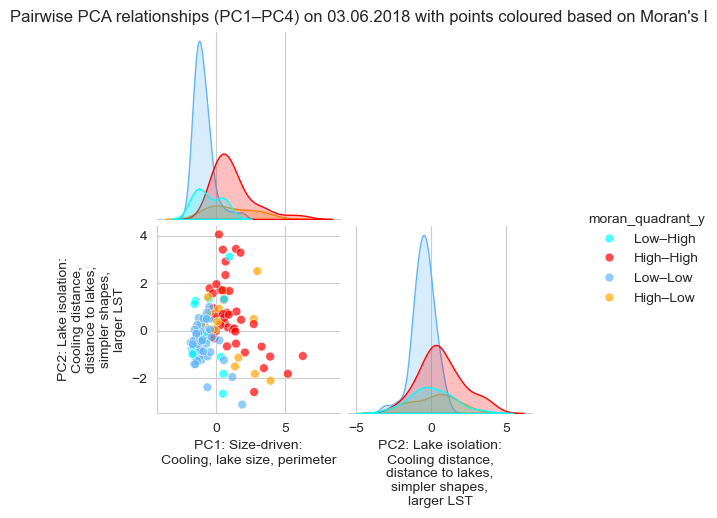

     obs_zone_y  obs_cooldif_y   area_ha  perimeter       LSI  \
PC1    0.442085       0.476906  0.424004   0.569668  0.254732   
PC2    0.488846       0.327146 -0.141755  -0.321736 -0.404337   
PC3   -0.168357      -0.108971  0.649298   0.065898 -0.617225   
PC4    0.103177       0.129935 -0.224016  -0.027897  0.289442   

     nearest_waterbody_dist  mean_lst_400m  
PC1                0.009604      -0.088541  
PC2                0.498031       0.344780  
PC3               -0.246828       0.303250  
PC4               -0.543332       0.736562  


In [24]:
# Principle components analysis 

vars_to_plot = [
    'obs_zone_y', #justified
    'obs_cooldif_y', #justified
    'area_ha', #justified
    'perimeter', #justified
    'LSI', # split pattern
    'nearest_waterbody_dist', #justified
    'mean_lst_400m', #justified
    #'mean_mndwi_400m', 
    #'mean_ndvi_400m',
    #'mean_imp_400m' #,
    #'herbm2_400m',
    #'forestm2_400m'
]

quadrant_colors = {
    "High–High": "red",
    "Low–Low": "#62B6F6",
    "High–Low": "orange",
    "Low–High": "cyan"
}

# -------------------------
# PREPARE DATA
# -------------------------

# Select numeric columns for PCA, drop rows with missing values
df_pca = lakes[vars_to_plot].dropna()

# Extract Moran quadrant for coloring
quadrant = lakes.loc[df_pca.index, 'moran_quadrant_y']
colors = quadrant.map(quadrant_colors)

# Standardize the data
X_scaled = StandardScaler().fit_transform(df_pca)

# -------------------------
# RUN PCA
# -------------------------

pca = PCA(n_components=4)  # decides number of principal components
X_pca = pca.fit_transform(X_scaled)

print("Explained variance by PCs:", pca.explained_variance_ratio_)

# -------------------------
# PLOT RESULTS
# -------------------------
# Create PCA score DataFrame
df_scores = pd.DataFrame(
    X_pca,
    columns=["PC1", "PC2", "PC3", "PC4"],
    index=df_pca.index
)

df_scores["moran_quadrant_y"] = quadrant.values

# Example: custom PC labels
custom_labels = {
    "PC1": "PC1: Size-driven:\nCooling, lake size, perimeter",
    "PC2": "PC2: Lake isolation:\nCooling distance,\ndistance to lakes,\nsimpler shapes,\nlarger LST" #,
    #"PC3": "PC3: Lake morphology\nindependent from cooling",
    #"PC4": "PC4: Thermal context\nindependent from cooling"
}

# Make a temporary copy of df_scores with renamed columns
df_plot = df_scores.rename(columns=custom_labels)

# -------------------------
# PAIRPLOT
# -------------------------

plt.close("all")
sns.set_style("whitegrid")

sns.pairplot(
    df_plot,
    vars=list(custom_labels.values()), #["PC1", "PC2", "PC3", "PC4"],
    hue="moran_quadrant_y",
    palette=quadrant_colors,
    corner=True,
    plot_kws={"alpha": 0.7, "s": 40}
)

plt.suptitle("Pairwise PCA relationships (PC1–PC4) on 03.06.2018 with points coloured based on Moran's I", y=1.02)
plt.savefig(
    "20180603pca_result_graph_small.png",  # file name
    dpi=400,                       # resolution
    bbox_inches="tight",           # remove extra white space
    transparent=False               # set True if you want transparent background
)
plt.show()

loadings_all = pd.DataFrame(
    pca.components_,
    columns=vars_to_plot,  # <-- make sure this is the same list used in PCA
    index=[f'PC{i+1}' for i in range(4)]  # match n_components=4
)

print(loadings_all.loc[["PC1", "PC2", "PC3", "PC4"]])    


In [63]:
import numpy as np
import statsmodels.api as sm

X = np.column_stack([
    np.log(lakes["area_ha"]),
    #lakes["perimeter"],
    #lakes["LSI"],
    #lakes["mean_lst_400m"],
    lakes["nearest_waterbody_dist"],
    lakes['obs_zone_y']
])

X = sm.add_constant(X)

y = lakes["obs_cooldif_y"]

model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:          obs_cooldif_y   R-squared:                       0.562
Model:                            OLS   Adj. R-squared:                  0.551
Method:                 Least Squares   F-statistic:                     52.62
Date:                Tue, 10 Feb 2026   Prob (F-statistic):           5.93e-22
Time:                        00:42:33   Log-Likelihood:                -213.97
No. Observations:                 127   AIC:                             435.9
Df Residuals:                     123   BIC:                             447.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.4020      0.290     -1.386      0.1

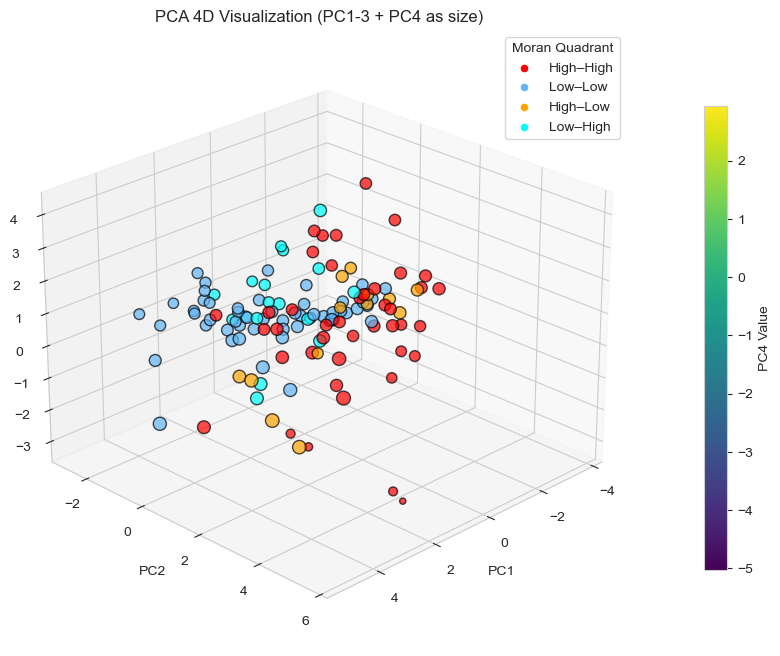

In [64]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d', elev=25, azim=45)

# Map PC4 to marker size (scaled for visibility)
pc4 = X_pca[:, 3]
pc4_scaled = 20 + (pc4 - pc4.min()) / (pc4.max() - pc4.min()) * 80  # size 20-100

scatter = ax.scatter(
    X_pca[:, 0], X_pca[:, 1], X_pca[:, 2],
    c=colors,
    s=pc4_scaled,
    alpha=0.7,
    edgecolor='k'
)

ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.set_title("PCA 4D Visualization (PC1-3 + PC4 as size)")

# Create legend for Moran quadrant colors
for quadrant_name, color in quadrant_colors.items():
    ax.scatter([], [], [], c=color, label=quadrant_name)
ax.legend(title="Moran Quadrant", loc='upper right')

# Add colorbar for PC4 sizes
mappable = plt.cm.ScalarMappable(cmap=plt.cm.viridis)
mappable.set_array(pc4)
cbar = plt.colorbar(mappable, ax=ax, fraction=0.03, pad=0.1)
cbar.set_label("PC4 Value")

plt.show()

Explained variance by PCs: [0.37145693 0.21986434 0.14835141]


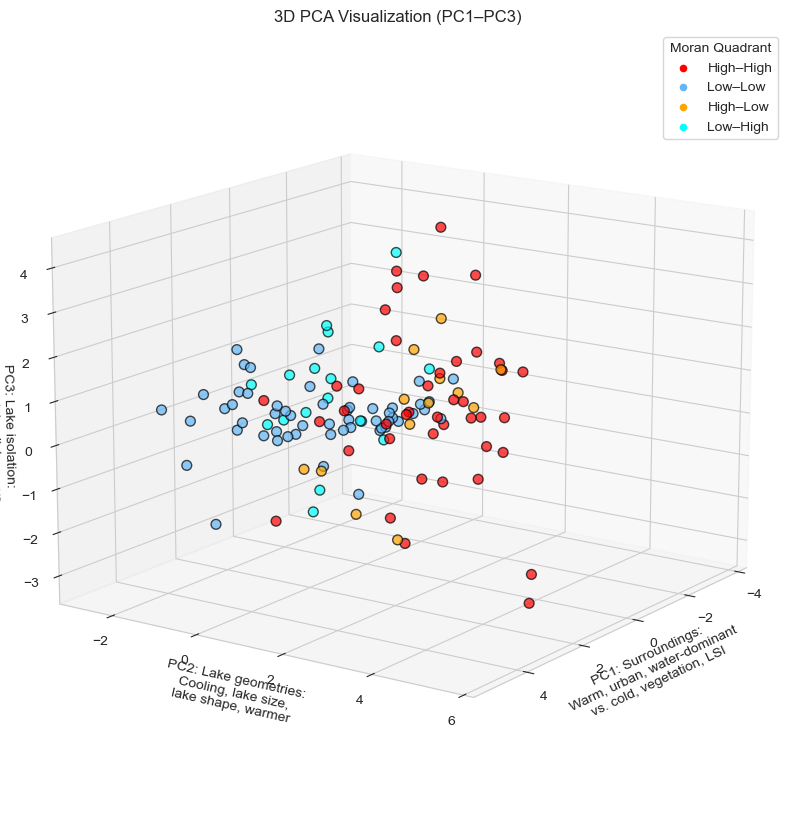

In [65]:
pca3 = PCA(n_components=3)  # only PC1-3
X_pca = pca3.fit_transform(X_scaled)
print("Explained variance by PCs:", pca3.explained_variance_ratio_)

fig = plt.figure(figsize=(10, 30))
ax = fig.add_subplot(111, projection='3d', elev=15, azim=35)

scatter = ax.scatter(
    X_pca[:, 0], X_pca[:, 1], X_pca[:, 2],
    c=colors,
    s=50,
    alpha=0.7,
    edgecolor='k'
)

ax.set_xlabel("PC1: Surroundings:\nWarm, urban, water-dominant\nvs. cold, vegetation, LSI")
ax.set_ylabel("PC2: Lake geometries:\nCooling, lake size,\nlake shape, warmer")
ax.set_zlabel("PC3: Lake isolation:\nCooling, lake distance vs.\nsmaller, more regular lakes")
ax.set_title("3D PCA Visualization (PC1–PC3)")

# Create legend for Moran quadrant colors
for quadrant_name, color in quadrant_colors.items():
    ax.scatter([], [], [], c=color, label=quadrant_name)
ax.legend(title="Moran Quadrant", loc='upper right')

plt.show()



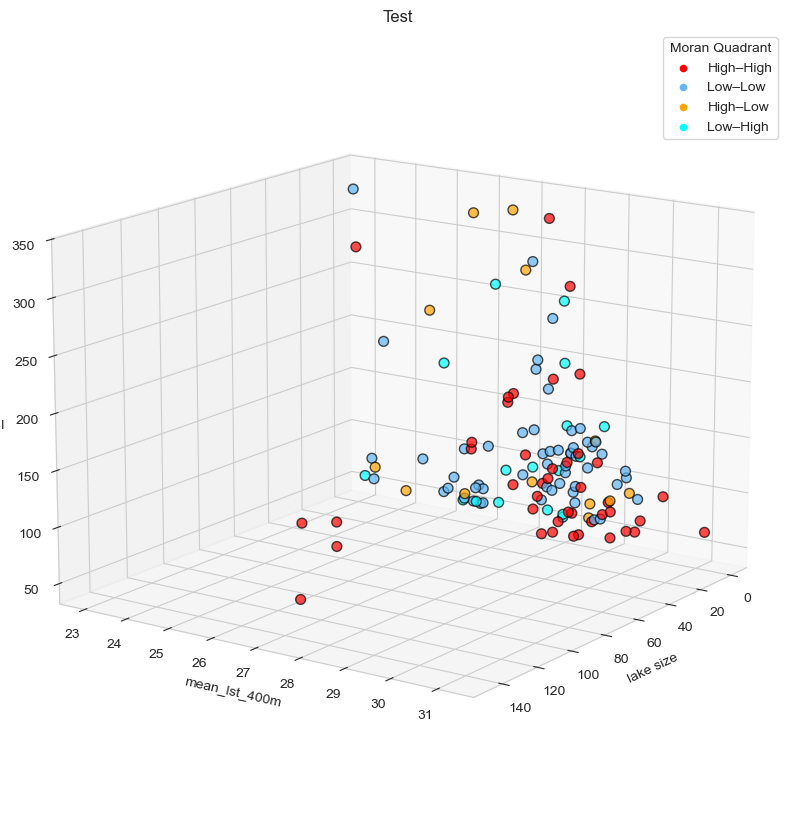

In [66]:
fig = plt.figure(figsize=(10, 30))
ax = fig.add_subplot(111, projection='3d', elev=15, azim=35)

scatter = ax.scatter(
    lakes['area_ha'], lakes['mean_lst_400m'], lakes['LSI'],
    c=colors,
    s=50,
    alpha=0.7,
    edgecolor='k'
)

ax.set_xlabel("lake size")
ax.set_ylabel("mean_lst_400m")
ax.set_zlabel("LSI")
ax.set_title("Test")

# Create legend for Moran quadrant colors
for quadrant_name, color in quadrant_colors.items():
    ax.scatter([], [], [], c=color, label=quadrant_name)
ax.legend(title="Moran Quadrant", loc='upper right')

plt.show()

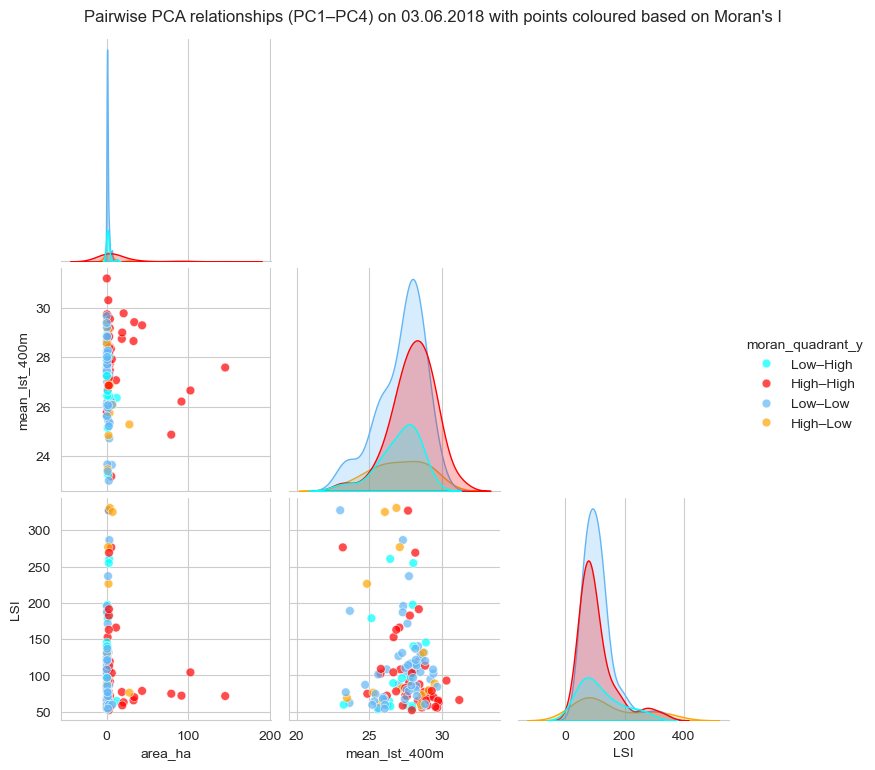

In [67]:
plt.close("all")
sns.set_style("whitegrid")

# Create PCA score DataFrame
df_lakes = pd.DataFrame(
    lakes,
    columns=['area_ha','mean_lst_400m','LSI'],
    index=df_pca.index
)

sns.pairplot(
    lakes,
    vars=['area_ha','mean_lst_400m','LSI'],
    hue="moran_quadrant_y",
    palette=quadrant_colors,
    corner=True,
    plot_kws={"alpha": 0.7, "s": 40}
)

plt.suptitle("Pairwise PCA relationships (PC1–PC4) on 03.06.2018 with points coloured based on Moran's I", y=1.02)
plt.savefig(
    "20180603pca_result_graph.png",  # file name
    dpi=400,                       # resolution
    bbox_inches="tight",           # remove extra white space
    transparent=False               # set True if you want transparent background
)
plt.show()


IndexError: index 3 is out of bounds for axis 1 with size 3

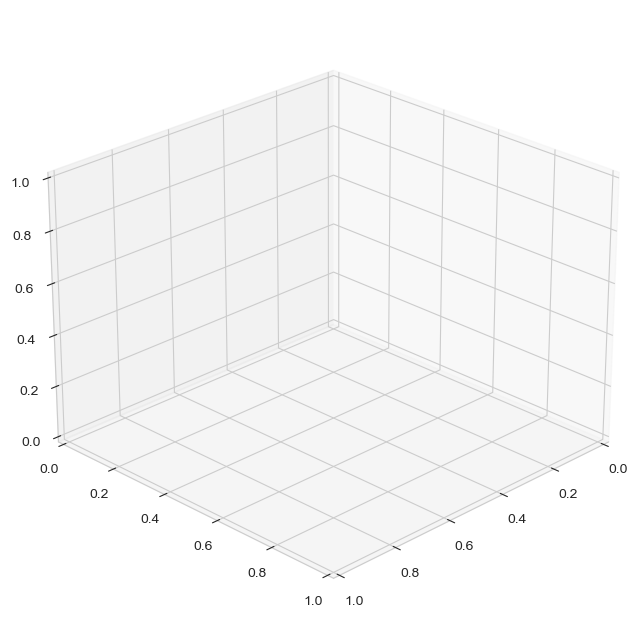

In [69]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d', elev=25, azim=45)

# Map PC4 to marker size (scaled for visibility)
pc4 = X_pca[:, 3]
pc4_scaled = 20 + (pc4 - pc4.min()) / (pc4.max() - pc4.min()) * 80  # size 20-100

scatter = ax.scatter(
    X_pca[:, 0], X_pca[:, 1], X_pca[:, 2],
    c=colors,
    s=pc4_scaled,
    alpha=0.7,
    edgecolor='k'
)

ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.set_title("PCA 4D Visualization (PC1-3 + PC4 as size)")

# Create legend for Moran quadrant colors
for quadrant_name, color in quadrant_colors.items():
    ax.scatter([], [], [], c=color, label=quadrant_name)
ax.legend(title="Moran Quadrant", loc='upper right')

# Add colorbar for PC4 sizes
mappable = plt.cm.ScalarMappable(cmap=plt.cm.viridis)
mappable.set_array(pc4)
cbar = plt.colorbar(mappable, ax=ax, fraction=0.03, pad=0.1)
cbar.set_label("PC4 Value")

plt.show()


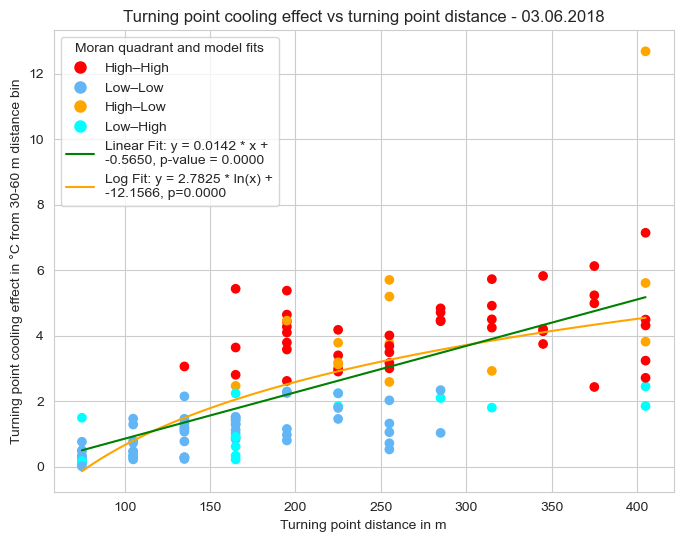

P-value for the logarithmic fit: 0.0000
R-value for the logarithmic fit: 0.6899
The logarithmic fit formula is: y = 2.7825 * ln(x) + -12.1566
P-value for the linear fit: 0.0000
R-value for the linear fit: 0.6928
The linear fit formula is: y = 0.0142 * x + -0.5650


In [71]:
### Graph 1: Turning point effect as a function of turning point distance to bin 30-60  
# Define distance bins (0-30, 30-60, ..., 390-420)
### Graph 1
### Analysis: Turning point distance to bin 30-60 as a function of lake size (only for lakes with cooling effect) 
# Define distance bins (0-30, 30-60, ..., 390-420)
### Graph 3
### Analysis: Cooling effect from bin 30-60 as a function of lake size 
# Define distance bins (0-30, 30-60, ..., 390-420)
bins = np.arange(30, 450, 30)  # Bins: [0, 30, 60, ..., 420]
bin_labels = bins[:-1] + 15  # Midpoints of each bin for plotting

# Filter lakes with area greater than or equal to 6 ha
lakes_filtered = lakes[lakes['area_ha'] >= 0]

# Get all unique lake IDs from the filtered lakes, ignoring NaNs
unique_ids = np.unique(lakes_source_near[~np.isnan(lakes_source_near)])

# Lists to store results
mean_LST_increases = []  # Mean increase in LST from bin 1 to turning point
turning_points = []
lake_quadrants = []

# Iterate through each unique lake ID from the filtered lakes
for lake_id in unique_ids:
    if lake_id not in lakes_filtered['id'].values:
        continue  # Skip if lake ID is not in the filtered lakes

    base_mask = (lakes_source_near == lake_id) & ~np.isnan(lake_dist) & ~np.isnan(lst) & (seas_case != 1) & (sea_dist > 195) #& (lake_dist < 400)

    if np.sum(base_mask) == 0:
        continue

    lst_at_30_60_mask = base_mask & (lake_dist >= 30) & (lake_dist < 60)
    lst_at_30_60 = np.mean(lst[lst_at_30_60_mask]) if np.any(lst_at_30_60_mask) else np.nan

    mask = base_mask & ~((lake_dist >= 30) & (lake_dist < 60))
    if np.sum(mask) == 0:
        continue

    raster1_vals = lake_dist[mask]
    raster2_vals = lst[mask]

    #values less than 30 has been assigned an index of 0 which here gets converted to -1 after subtracting 1
    # bin 0-30 is not part of this due to the bin start of 30 higher up in the code
    bin_indices = np.digitize(raster1_vals, bins, right=False) - 1  # Ensures 0-30m bin works correctly

    # Compute mean LST for each distance bin
    mean_lst_values = [np.mean(raster2_vals[bin_indices == i]) if np.any(bin_indices == i) else np.nan for i in range(len(bin_labels))]

    # Set ΔLST to zero for the 30-60 bin (reference)
    # For each bin, the ΔLST between bin and 30-60m-lst is calculated (plus if cooling; minus if not cooling)  
    delta_lst = [0 if bin_labels[i] == 45 else (val - lst_at_30_60 if not np.isnan(val) else np.nan) for i, val in enumerate(mean_lst_values)]

    turning_point_index = -1  # Default to -1 if no valid turning point is found
    turn_mean_lst_values = -9999 # Default to mark not existing 

    # Find indices for 45m (reference) and 75m bins
    try:
        index_45 = np.where(bin_labels == 45)[0][0]  # Extract scalar index 0
        index_75 = np.where(bin_labels == 75)[0][0]  # Extract scalar index 1

        # Compute the change in ΔLST between 45m and 75m bins
        if not np.isnan(lst_at_30_60) and not np.isnan(delta_lst[index_75]):
            if (delta_lst[index_75] > delta_lst[index_45]):
                turning_point_index = index_75
                turn_mean_lst_values =  delta_lst[1] #mean_lst_values[1] #take LST at bin 60-90m
                for i in range(1, len(delta_lst)): 
                    if np.isnan(delta_lst[i]):
                        break
                    if delta_lst[i] < delta_lst[i - 1]:  
                        break  
                    turning_point_index = i 
                    turn_mean_lst_values = delta_lst[i] #replace LST at bin 60-90m with larger (and thus real) turning point) 
        else:
            continue  # Skip plotting if NaN values exist
    except IndexError:
        continue  # Skip plotting if bins are missing

    if turning_point_index >= 0:
        turning_point_distance = bin_labels[turning_point_index]  
        turning_points.append(turning_point_distance)
        mean_LST_increases.append(turn_mean_lst_values)
        lake_quadrants.append(lakes_filtered.loc[lakes_filtered['id'] == lake_id, 'moran_quadrant_y'].values[0])

point_colors = [quadrant_colors[q] for q in lake_quadrants]

# Convert lists to numpy arrays
#lake_sizes = np.array(lake_sizes)
mean_LST_increases = np.array(mean_LST_increases)
#print(len(lake_sizes))
#print(len(mean_LST_increases))

# Apply logarithmic transformation on lake sizes
#log_lake_sizes = np.log(lake_sizes)

# Fit a logarithmic model: y = a * ln(x) + b
log_turning_points = np.log(np.array(turning_points))  # Logarithmic transformation
slope_log, intercept_log, r_value_log, p_value_log, std_err_log = stats.linregress(log_turning_points, mean_LST_increases)

# Fit a linear model: y = m * x + b
slope_linear, intercept_linear, r_value_linear, p_value_linear, std_err_linear = stats.linregress(turning_points, mean_LST_increases)

# Generate values for plotting the linear
x_vals_lin = np.linspace(min(turning_points), max(turning_points), 100)
y_vals_lin = slope_linear * x_vals_lin + intercept_linear

# Generate values for plotting the fitted curves
y_vals_log = slope_log * np.log(x_vals_lin) + intercept_log  # Logarithmic fit line

# Scatter plot of lake sizes vs mean LST increase
plt.figure(figsize=(8, 6))
plt.scatter(turning_points, mean_LST_increases, c=point_colors, marker='o', label="Observed Data")  # Red dots for data points

# Plot the logarithmic fit
line_log, = plt.plot(x_vals_lin, y_vals_log, color='orange', label=f"Log Fit: y = {slope_log:.4f} * ln(x) +\n{intercept_log:.4f}, p={p_value_log:.4f}")

# Plot the fitted linear trend
line_lin, = plt.plot(x_vals_lin, y_vals_lin, color='green', label=f"Linear Fit: y = {slope_linear:.4f} * x +\n{intercept_linear:.4f}, p-value = {p_value_linear:.4f}")

# Set axis labels and title
plt.xlabel("Turning point distance in m")
plt.ylabel("Turning point cooling effect in °C from 30-60 m distance bin")
plt.title("Turning point cooling effect vs turning point distance - 03.06.2018")

# Display grid and legend
plt.grid(True)

# Show the legend
quadrant_handles = [
    mlines.Line2D(
    [], [], 
    color=color, 
    marker='o',  # circle
    linestyle='None',  # no line
    markersize=8, 
    label=quad
    )
    for quad, color in quadrant_colors.items()
]
all_handles = quadrant_handles + [line_lin, line_log]
plt.legend(handles=all_handles, title="Moran quadrant and model fits")

plt.savefig("Plot20180603_turningPointCoolVSDist.png", dpi=400, bbox_inches="tight")

plt.show()

# Print results
print(f"P-value for the logarithmic fit: {p_value_log:.4f}")
print(f"R-value for the logarithmic fit: {r_value_log:.4f}")
print(f"The logarithmic fit formula is: y = {slope_log:.4f} * ln(x) + {intercept_log:.4f}")

print(f"P-value for the linear fit: {p_value_linear:.4f}")
print(f"R-value for the linear fit: {r_value_linear:.4f}")
print(f"The linear fit formula is: y = {slope_linear:.4f} * x + {intercept_linear:.4f}")


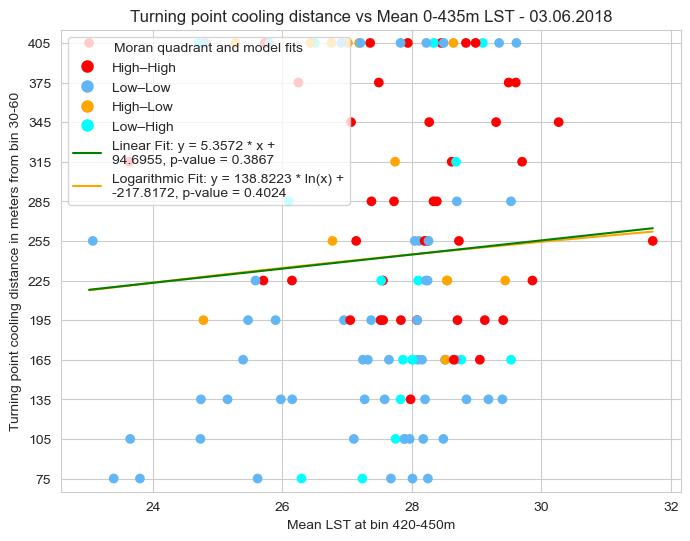

P-value for the logarithmic fit: 0.4024
R-value for the logarithmic fit: 0.0749
The logarithmic fit formula is: y = 138.8223 * ln(x) + -217.8172
P-value for the linear fit: 0.3867
R-value for the linear fit: 0.0775
The linear fit formula is: y = 5.3572 * x + 94.6955


In [72]:
### Graph 2: Analysis Turning point distance to bin 30-60 as a function of LST at bin 0-435m  
# Define distance bins (0-30, 30-60, ..., 390-420)
bins = np.arange(30, 450, 30)  # Bins: [0, 30, 60, ..., 420]
bin_labels = bins[:-1] + 15  # Midpoints of each bin for plotting

# Filter lakes with area greater than or equal to 6 ha (or adjust threshold as needed)
lakes_filtered = lakes[lakes['area_ha'] >= 0]

# Get all unique lake IDs from the filtered lakes, ignoring NaNs
unique_ids = np.unique(lakes_source_near[~np.isnan(lakes_source_near)])

# List to store turning points and corresponding lake sizes
turning_points = []
lst_lakes = []
lake_quadrants = []

# Initialize figure for plotting both fits
plt.figure(figsize=(8, 6))

# Iterate through each unique lake ID from the filtered lakes
for lake_id in unique_ids:
    if lake_id not in lakes_filtered['id'].values:
        continue  # Skip if lake ID is not in the filtered lakes

    base_mask = (lakes_source_near == lake_id) & ~np.isnan(lake_dist) & ~np.isnan(lst) & (seas_case != 1) & (sea_dist > 195) #& (lake_dist < 400) 

    if np.sum(base_mask) == 0:
        continue

    # Compute mean LST for `dist = 30-60` (used as reference)
    lst_at_30_60_mask = base_mask & (lake_dist >= 30) & (lake_dist < 60)
    lst_at_30_60 = np.mean(lst[lst_at_30_60_mask]) if np.any(lst_at_30_60_mask) else np.nan
    
    mask = base_mask & ~((lake_dist >= 30) & (lake_dist < 60))
    if np.sum(mask) == 0:
        continue

    raster1_vals = lake_dist[mask]
    raster2_vals = lst[mask]
    raster3_vals = lst[base_mask]

    #values less than 30 has been assigned an index of 0 which here gets converted to -1 after subtracting 1
    # bin 0-30 is not part of this due to the bin start of 30 higher up in the code
    bin_indices = np.digitize(raster1_vals, bins, right=False) - 1  # Ensures 0-30m bin works correctly

    # Compute mean LST for each distance bin
    mean_lst_values = [np.mean(raster2_vals[bin_indices == i]) if np.any(bin_indices == i) else np.nan for i in range(len(bin_labels))]

    # Set ΔLST to zero for the 30-60 bin (reference)
    # For each bin, the ΔLST between bin and 30-60m-lst is calculated (plus if cooling; minus if not cooling)  
    delta_lst = [0 if bin_labels[i] == 45 else (mean_lst_values[i] - lst_at_30_60 if not np.isnan(mean_lst_values[i]) else np.nan) for i in range(len(bin_labels))]
  
    # Compute mean LST for distance bin 420-450
    if raster3_vals.size > 0:
        mean_lst_value = np.nanmean(raster3_vals)  # ignores NaNs, safe for non-empty arrays
    else:
        mean_lst_value = np.nan  # skip empty arrays

    turning_point_index = -1  # Default to -1 if no valid turning point is found

    # Find indices for 45m (reference) and 75m bins
    try:
        index_45 = np.where(bin_labels == 45)[0][0]  # Extract scalar index 0
        index_75 = np.where(bin_labels == 75)[0][0]  # Extract scalar index 1

        # Compute the change in ΔLST between 45m and 75m bins
        if not np.isnan(delta_lst[index_45]) and not np.isnan(delta_lst[index_75]):
            if (delta_lst[index_75] > delta_lst[index_45]):
                turning_point_index = index_75
                for i in range(1, len(mean_lst_values)): 
                    if mean_lst_values[i] < mean_lst_values[i - 1]:  
                        break  
                    turning_point_index = i  
        else:
            continue  # Skip plotting if NaN values exist
    except IndexError:
        continue  # Skip plotting if bins are missing

    if turning_point_index >= 0 and not np.isnan(mean_lst_value):
        turning_point_distance = bin_labels[turning_point_index]  
        turning_points.append(turning_point_distance)
        lst_lakes.append(mean_lst_value)
        lake_quadrants.append(lakes_filtered.loc[lakes_filtered['id'] == lake_id, 'moran_quadrant_y'].values[0])

point_colors = [quadrant_colors[q] for q in lake_quadrants]

# Plot the turning points vs lake size as a scatter plot
plt.scatter(lst_lakes, turning_points, c=point_colors, marker='o', label="Observed data")

# Logarithmic Fit
log_lst_lakes = np.log(np.array(lst_lakes))  # Logarithmic transformation
slope_log, intercept_log, r_value_log, p_value_log, std_err_log = stats.linregress(log_lst_lakes, turning_points)

# Plot the fitted logarithmic curve
x_vals_log = np.linspace(min(log_lst_lakes), max(log_lst_lakes), 100)
y_vals_log = slope_log * x_vals_log + intercept_log  # Logarithmic fit line
line_log, = plt.plot(np.exp(x_vals_log), y_vals_log, color='orange', label=f"Logarithmic Fit: y = {slope_log:.4f} * ln(x) +\n{intercept_log:.4f}, p-value = {p_value_log:.4f}")

# Linear Fit
slope_lin, intercept_lin, r_value_lin, p_value_lin, std_err_lin = stats.linregress(lst_lakes, turning_points)

# Plot the fitted linear trend
x_vals_lin = np.linspace(min(lst_lakes), max(lst_lakes), 100)
y_vals_lin = slope_lin * x_vals_lin + intercept_lin
line_lin, = plt.plot(x_vals_lin, y_vals_lin, color='green', label=f"Linear Fit: y = {slope_lin:.4f} * x +\n{intercept_lin:.4f}, p-value = {p_value_lin:.4f}")

# Set axis labels and title
plt.xlabel("Mean LST at bin 420-450m")
plt.ylabel("Turning point cooling distance in meters from bin 30-60")
plt.title("Turning point cooling distance vs Mean 0-435m LST - 03.06.2018")

# Adjust y-axis
plt.ylim(min(turning_points) - 10, max(turning_points) + 10)  
plt.yticks(np.unique(turning_points))

# Show grid for better readability
plt.grid(True)

# Show the legend
quadrant_handles = [
    mlines.Line2D(
    [], [], 
    color=color, 
    marker='o',  # circle
    linestyle='None',  # no line
    markersize=8, 
    label=quad
    )
    for quad, color in quadrant_colors.items()
]
all_handles = quadrant_handles + [line_lin, line_log]
plt.legend(handles=all_handles, title="Moran quadrant and model fits")

plt.savefig("Plot20180603_turningPointDist30VSLST435m.png", dpi=400, bbox_inches="tight")

# Show the plot
plt.show()

# Print results for both fits
print(f"P-value for the logarithmic fit: {p_value_log:.4f}")
print(f"R-value for the logarithmic fit: {r_value_log:.4f}")
print(f"The logarithmic fit formula is: y = {slope_log:.4f} * ln(x) + {intercept_log:.4f}")

print(f"P-value for the linear fit: {p_value_lin:.4f}")
print(f"R-value for the linear fit: {r_value_lin:.4f}")
print(f"The linear fit formula is: y = {slope_lin:.4f} * x + {intercept_lin:.4f}")


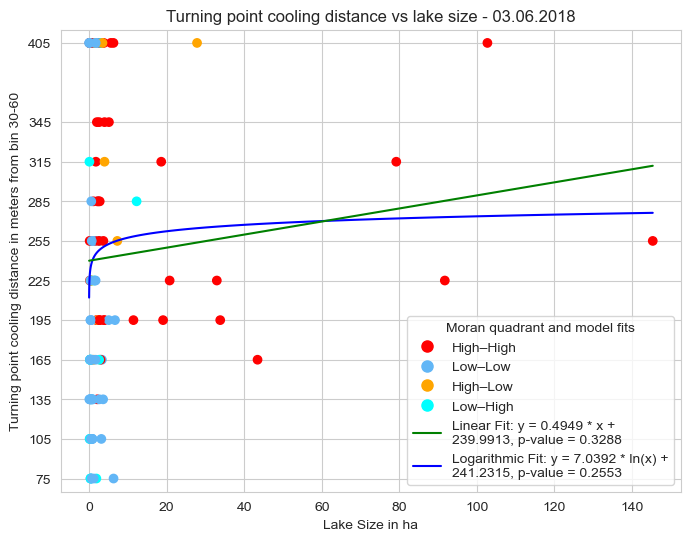

P-value for the logarithmic fit: 0.2553
R-value for the logarithmic fit: 0.1017
The logarithmic fit formula is: y = 7.0392 * ln(x) + 241.2315
P-value for the linear fit: 0.3288
R-value for the linear fit: 0.0874
The linear fit formula is: y = 0.4949 * x + 239.9913


In [73]:
### Graph 3: Turning point distance to bin 30-60 as a function of lake size (all lakes > 195m from sea) 
# Define distance bins (0-30, 30-60, ..., 390-420)
bins = np.arange(30, 450, 30)  # Bins: [0, 30, 60, ..., 420]
bin_labels = bins[:-1] + 15  # Midpoints of each bin for plotting

# Filter lakes with area greater than or equal to 6 ha (or adjust threshold as needed)
lakes_filtered = lakes[lakes['area_ha'] >= 0]

# Get all unique lake IDs from the filtered lakes, ignoring NaNs
unique_ids = np.unique(lakes_source_near[~np.isnan(lakes_source_near)])

# List to store turning points and corresponding lake sizes
turning_points = []
lake_sizes = []
lake_quadrants = []

# Initialize figure for plotting both fits
plt.figure(figsize=(8, 6))

# Iterate through each unique lake ID from the filtered lakes
for lake_id in unique_ids:
    if lake_id not in lakes_filtered['id'].values:
        continue  # Skip if lake ID is not in the filtered lakes

    base_mask = (lakes_source_near == lake_id) & (lake_dist < 400) & ~np.isnan(lake_dist) & ~np.isnan(lst) & (seas_case != 1) & (sea_dist > 195)

    if np.sum(base_mask) == 0:
        continue

    # Compute mean LST for `dist = 30-60` (used as reference)
    lst_at_30_60_mask = base_mask & (lake_dist >= 30) & (lake_dist < 60)
    lst_at_30_60 = np.mean(lst[lst_at_30_60_mask]) if np.any(lst_at_30_60_mask) else np.nan

    mask = base_mask & ~((lake_dist >= 30) & (lake_dist < 60))
    if np.sum(mask) == 0:
        continue

    raster1_vals = lake_dist[mask]
    raster2_vals = lst[mask]

    #digitize assigns each distance value to a bin number
    #values 30-60 has been assigned an index of 1 but this is changed to index 0 after subtracting 1
    #this is because dist values are not to be considered for 30-60m (now bin index=0)
    #bin 0-30 is not part of this due to the bin start of 30 higher up in the code
    bin_indices = np.digitize(raster1_vals, bins, right=False) - 1  # Ensures 0-30m bin works correctly

    # Compute mean LST for each distance bin i
    mean_lst_values = [np.mean(raster2_vals[bin_indices == i]) if np.any(bin_indices == i) else np.nan for i in range(len(bin_labels))]

    # Set ΔLST to zero for the 30-60 bin (reference)
    # For each bin, the ΔLST between bin and 30-60m-lst is calculated (plus if cooling; minus if not cooling)  
    delta_lst = [0 if bin_labels[i] == 45 else (mean_lst_values[i] - lst_at_30_60 if not np.isnan(mean_lst_values[i]) else np.nan) for i in range(len(bin_labels))]

    turning_point_index = -1  # Default to -1 if no valid turning point is found

    # Find indices for 45m (reference) and 75m bins
    try:
        index_45 = np.where(bin_labels == 45)[0][0]  # Extract scalar index 0
        index_75 = np.where(bin_labels == 75)[0][0]  # Extract scalar index 1

        # Compute the change in ΔLST between 45m and 75m bins
        if not np.isnan(delta_lst[index_45]) and not np.isnan(delta_lst[index_75]):
            if (delta_lst[index_75] > delta_lst[index_45]):
                turning_point_index = index_75
                for i in range(1, len(mean_lst_values)): 
                    if mean_lst_values[i] < mean_lst_values[i - 1]:  
                        break  
                    turning_point_index = i  
        else:
            continue  # Skip plotting if NaN values exist
    except IndexError:
        continue  # Skip plotting if bins are missing

    if turning_point_index >= 0:
        turning_point_distance = bin_labels[turning_point_index]  
        turning_points.append(turning_point_distance)
        lake_sizes.append(lakes_filtered.loc[lakes_filtered['id'] == lake_id, 'area_ha'].values[0])
        lake_quadrants.append(lakes_filtered.loc[lakes_filtered['id'] == lake_id, 'moran_quadrant_y'].values[0])

point_colors = [quadrant_colors[q] for q in lake_quadrants]

# Plot the turning points vs lake size as a scatter plot
plt.scatter(lake_sizes, turning_points, c=point_colors, marker='o', label="Observed data")

# Logarithmic Fit
log_lake_sizes = np.log(np.array(lake_sizes))  # Logarithmic transformation
slope_log, intercept_log, r_value_log, p_value_log, std_err_log = stats.linregress(log_lake_sizes, turning_points)

# Plot the fitted logarithmic curve
x_vals_log = np.linspace(min(log_lake_sizes), max(log_lake_sizes), 100)
y_vals_log = slope_log * x_vals_log + intercept_log  # Logarithmic fit line
line_log, = plt.plot(np.exp(x_vals_log), y_vals_log, color='blue', label=f"Logarithmic Fit: y = {slope_log:.4f} * ln(x) +\n{intercept_log:.4f}, p-value = {p_value_log:.4f}")

# Linear Fit
slope_lin, intercept_lin, r_value_lin, p_value_lin, std_err_lin = stats.linregress(lake_sizes, turning_points)

# Plot the fitted linear trend
x_vals_lin = np.linspace(min(lake_sizes), max(lake_sizes), 100)
y_vals_lin = slope_lin * x_vals_lin + intercept_lin
line_lin, = plt.plot(x_vals_lin, y_vals_lin, color='green', label=f"Linear Fit: y = {slope_lin:.4f} * x +\n{intercept_lin:.4f}, p-value = {p_value_lin:.4f}")

# Set axis labels and title
plt.xlabel("Lake Size in ha")
plt.ylabel("Turning point cooling distance in meters from bin 30-60")
plt.title("Turning point cooling distance vs lake size - 03.06.2018")

# Adjust y-axis
plt.ylim(min(turning_points) - 10, max(turning_points) + 10)  
plt.yticks(np.unique(turning_points))

# Show grid for better readability
plt.grid(True)

import matplotlib.lines as mlines

# Show the legend
quadrant_handles = [
    mlines.Line2D(
    [], [], 
    color=color, 
    marker='o',  # circle
    linestyle='None',  # no line
    markersize=8, 
    label=quad
    )
    for quad, color in quadrant_colors.items()
]
all_handles = quadrant_handles + [line_lin, line_log]
plt.legend(handles=all_handles, title="Moran quadrant and model fits")

plt.savefig("Plot20180603_turningPointDist45VSlakeSize.png", dpi=400, bbox_inches="tight")

# Show the plot
plt.show()

# Print results for both fits
print(f"P-value for the logarithmic fit: {p_value_log:.4f}")
print(f"R-value for the logarithmic fit: {r_value_log:.4f}")
print(f"The logarithmic fit formula is: y = {slope_log:.4f} * ln(x) + {intercept_log:.4f}")

print(f"P-value for the linear fit: {p_value_lin:.4f}")
print(f"R-value for the linear fit: {r_value_lin:.4f}")
print(f"The linear fit formula is: y = {slope_lin:.4f} * x + {intercept_lin:.4f}")

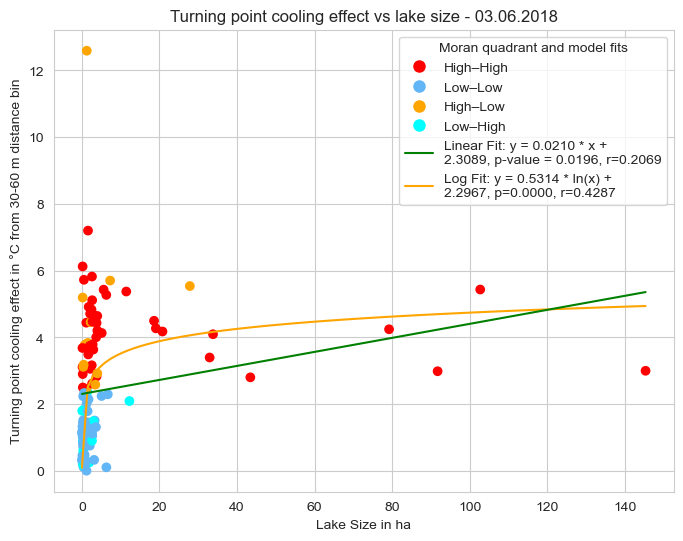

P-value for the logarithmic fit: 0.0000
R-value for the logarithmic fit: 0.4287
The logarithmic fit formula is: y = 0.5314 * ln(x) + 2.2967
P-value for the linear fit: 0.0196
R-value for the linear fit: 0.2069
The linear fit formula is: y = 0.0210 * x + 2.3089


In [74]:
### Graph 4: Analysis: Cooling effect from bin 30-60 as a function of lake size 
# Define distance bins (0-30, 30-60, ..., 390-420)
bins = np.arange(30, 450, 30)  # Bins: [0, 30, 60, ..., 420]
bin_labels = bins[:-1] + 15  # Midpoints of each bin for plotting

# Filter lakes with area greater than or equal to 6 ha
lakes_filtered = lakes[lakes['area_ha'] >= 0]

# Get all unique lake IDs from the filtered lakes, ignoring NaNs
unique_ids = np.unique(lakes_source_near[~np.isnan(lakes_source_near)])

# Lists to store results
mean_LST_increases = []  # Mean increase in LST from bin 1 to turning point
lake_sizes = []
lake_quadrants = []

# Iterate through each unique lake ID from the filtered lakes
for lake_id in unique_ids:
    if lake_id not in lakes_filtered['id'].values:
        continue  # Skip if lake ID is not in the filtered lakes

    base_mask = (lakes_source_near == lake_id) & (lake_dist < 400) & ~np.isnan(lake_dist) & ~np.isnan(lst) & (seas_case != 1) & (sea_dist > 195)

    if np.sum(base_mask) == 0:
        continue

    lst_at_30_60_mask = base_mask & (lake_dist >= 30) & (lake_dist < 60)
    lst_at_30_60 = np.mean(lst[lst_at_30_60_mask]) if np.any(lst_at_30_60_mask) else np.nan

    mask = base_mask & ~((lake_dist >= 30) & (lake_dist < 60))
    if np.sum(mask) == 0:
        continue

    raster1_vals = lake_dist[mask]
    raster2_vals = lst[mask]

    #values less than 30 has been assigned an index of 0 which here gets converted to -1 after subtracting 1
    # bin 0-30 is not part of this due to the bin start of 30 higher up in the code
    bin_indices = np.digitize(raster1_vals, bins, right=False) - 1  # Ensures 0-30m bin works correctly

    # Compute mean LST for each distance bin
    mean_lst_values = [np.mean(raster2_vals[bin_indices == i]) if np.any(bin_indices == i) else np.nan for i in range(len(bin_labels))]

    # Set ΔLST to zero for the 30-60 bin (reference)
    # For each bin, the ΔLST between bin and 30-60m-lst is calculated (plus if cooling; minus if not cooling)  
    delta_lst = [0 if bin_labels[i] == 45 else (val - lst_at_30_60 if not np.isnan(val) else np.nan) for i, val in enumerate(mean_lst_values)]

    turning_point_index = -1  # Default to -1 if no valid turning point is found
    turn_mean_lst_values = -9999 # Default to mark not existing 

    # Find indices for 45m (reference) and 75m bins
    try:
        index_45 = np.where(bin_labels == 45)[0][0]  # Extract scalar index 0
        index_75 = np.where(bin_labels == 75)[0][0]  # Extract scalar index 1

        # Compute the change in ΔLST between 45m and 75m bins
        if not np.isnan(lst_at_30_60) and not np.isnan(delta_lst[index_75]):
            if (delta_lst[index_75] > delta_lst[index_45]):
                turning_point_index = index_75
                turn_mean_lst_values =  delta_lst[1] #mean_lst_values[1] #take LST at bin 60-90m
                for i in range(1, len(delta_lst)): 
                    if np.isnan(delta_lst[i]):
                        break
                    if delta_lst[i] < delta_lst[i - 1]:  
                        break  
                    turning_point_index = i 
                    turn_mean_lst_values = delta_lst[i] #replace LST at bin 60-90m with larger (and thus real) turning point) 
        else:
            continue  # Skip plotting if NaN values exist
    except IndexError:
        continue  # Skip plotting if bins are missing

    if turning_point_index >= 0:
        mean_LST_increases.append(turn_mean_lst_values)
        lake_sizes.append(lakes_filtered.loc[lakes_filtered['id'] == lake_id, 'area_ha'].values[0])
        lake_quadrants.append(lakes_filtered.loc[lakes_filtered['id'] == lake_id, 'moran_quadrant_y'].values[0])

point_colors = [quadrant_colors[q] for q in lake_quadrants]

# Convert lists to numpy arrays
lake_sizes = np.array(lake_sizes)
mean_LST_increases = np.array(mean_LST_increases)
#print(len(lake_sizes))
#print(len(mean_LST_increases))

# Apply logarithmic transformation on lake sizes
#log_lake_sizes = np.log(lake_sizes)

# Fit a logarithmic model: y = a * ln(x) + b
log_lake_sizes = np.log(np.array(lake_sizes))  # Logarithmic transformation
slope_log, intercept_log, r_value_log, p_value_log, std_err_log = stats.linregress(log_lake_sizes, mean_LST_increases)

# Fit a linear model: y = m * x + b
slope_linear, intercept_linear, r_value_linear, p_value_linear, std_err_linear = stats.linregress(lake_sizes, mean_LST_increases)

# Generate values for plotting the linear
x_vals_lin = np.linspace(min(lake_sizes), max(lake_sizes), 100)
y_vals_lin = slope_linear * x_vals_lin + intercept_linear

# Generate values for plotting the fitted curves
y_vals_log = slope_log * np.log(x_vals_lin) + intercept_log  # Logarithmic fit line

# Scatter plot of lake sizes vs mean LST increase
plt.figure(figsize=(8, 6))
plt.scatter(lake_sizes, mean_LST_increases, c=point_colors, marker='o', label="Observed Data")  # Red dots for data points

# Plot the logarithmic fit
line_log, = plt.plot(x_vals_lin, y_vals_log, color='orange', label=f"Log Fit: y = {slope_log:.4f} * ln(x) +\n{intercept_log:.4f}, p={p_value_log:.4f}, r={r_value_log:.4f}")

# Plot the fitted linear trend
line_lin, = plt.plot(x_vals_lin, y_vals_lin, color='green', label=f"Linear Fit: y = {slope_linear:.4f} * x +\n{intercept_linear:.4f}, p-value = {p_value_linear:.4f}, r={r_value_linear:.4f}")

# Set axis labels and title
plt.xlabel("Lake Size in ha")
plt.ylabel("Turning point cooling effect in °C from 30-60 m distance bin")
plt.title("Turning point cooling effect vs lake size - 03.06.2018")

# Display grid and legend
plt.grid(True)

# Show the legend
quadrant_handles = [
    mlines.Line2D(
    [], [], 
    color=color, 
    marker='o',  # circle
    linestyle='None',  # no line
    markersize=8, 
    label=quad
    )
    for quad, color in quadrant_colors.items()
]
all_handles = quadrant_handles + [line_lin, line_log]
plt.legend(handles=all_handles, title="Moran quadrant and model fits")

plt.savefig("Plot20180603_turningPointCool30VSlakeSize.png", dpi=400, bbox_inches="tight")

plt.show()

# Print results
print(f"P-value for the logarithmic fit: {p_value_log:.4f}")
print(f"R-value for the logarithmic fit: {r_value_log:.4f}")
print(f"The logarithmic fit formula is: y = {slope_log:.4f} * ln(x) + {intercept_log:.4f}")

print(f"P-value for the linear fit: {p_value_linear:.4f}")
print(f"R-value for the linear fit: {r_value_linear:.4f}")
print(f"The linear fit formula is: y = {slope_linear:.4f} * x + {intercept_linear:.4f}")


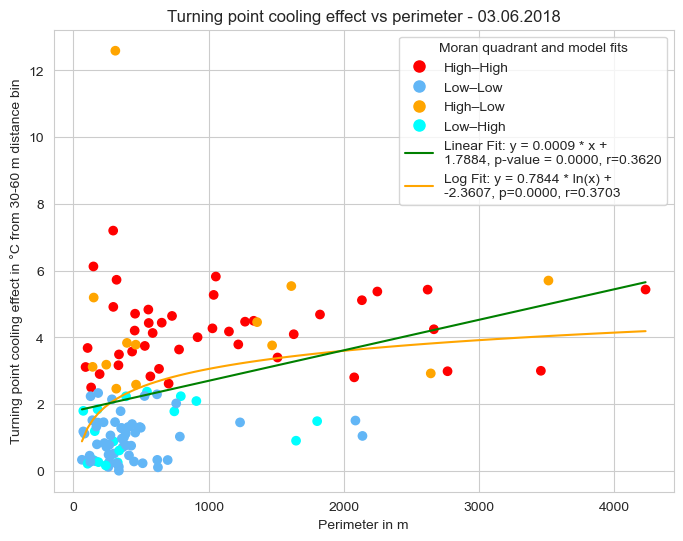

P-value for the logarithmic fit: 0.0000
R-value for the logarithmic fit: 0.3703
The logarithmic fit formula is: y = 0.7844 * ln(x) + -2.3607
P-value for the linear fit: 0.0000
R-value for the linear fit: 0.3620
The linear fit formula is: y = 0.0009 * x + 1.7884


In [75]:
### Graph: Analysis: Cooling effect from bin 30-60 as a function of perimeter 
# Define distance bins (0-30, 30-60, ..., 390-420)
bins = np.arange(30, 450, 30)  # Bins: [0, 30, 60, ..., 420]
bin_labels = bins[:-1] + 15  # Midpoints of each bin for plotting

# Filter lakes with area greater than or equal to 6 ha
lakes_filtered = lakes[lakes['area_ha'] >= 0]

# Get all unique lake IDs from the filtered lakes, ignoring NaNs
unique_ids = np.unique(lakes_source_near[~np.isnan(lakes_source_near)])

# Lists to store results
mean_LST_increases = []  # Mean increase in LST from bin 1 to turning point
lake_sizes = []
lake_quadrants = []

# Iterate through each unique lake ID from the filtered lakes
for lake_id in unique_ids:
    if lake_id not in lakes_filtered['id'].values:
        continue  # Skip if lake ID is not in the filtered lakes

    base_mask = (lakes_source_near == lake_id) & (lake_dist < 400) & ~np.isnan(lake_dist) & ~np.isnan(lst) & (seas_case != 1) & (sea_dist > 195)

    if np.sum(base_mask) == 0:
        continue

    lst_at_30_60_mask = base_mask & (lake_dist >= 30) & (lake_dist < 60)
    lst_at_30_60 = np.mean(lst[lst_at_30_60_mask]) if np.any(lst_at_30_60_mask) else np.nan

    mask = base_mask & ~((lake_dist >= 30) & (lake_dist < 60))
    if np.sum(mask) == 0:
        continue

    raster1_vals = lake_dist[mask]
    raster2_vals = lst[mask]

    #values less than 30 has been assigned an index of 0 which here gets converted to -1 after subtracting 1
    # bin 0-30 is not part of this due to the bin start of 30 higher up in the code
    bin_indices = np.digitize(raster1_vals, bins, right=False) - 1  # Ensures 0-30m bin works correctly

    # Compute mean LST for each distance bin
    mean_lst_values = [np.mean(raster2_vals[bin_indices == i]) if np.any(bin_indices == i) else np.nan for i in range(len(bin_labels))]

    # Set ΔLST to zero for the 30-60 bin (reference)
    # For each bin, the ΔLST between bin and 30-60m-lst is calculated (plus if cooling; minus if not cooling)  
    delta_lst = [0 if bin_labels[i] == 45 else (val - lst_at_30_60 if not np.isnan(val) else np.nan) for i, val in enumerate(mean_lst_values)]

    turning_point_index = -1  # Default to -1 if no valid turning point is found
    turn_mean_lst_values = -9999 # Default to mark not existing 

    # Find indices for 45m (reference) and 75m bins
    try:
        index_45 = np.where(bin_labels == 45)[0][0]  # Extract scalar index 0
        index_75 = np.where(bin_labels == 75)[0][0]  # Extract scalar index 1

        # Compute the change in ΔLST between 45m and 75m bins
        if not np.isnan(lst_at_30_60) and not np.isnan(delta_lst[index_75]):
            if (delta_lst[index_75] > delta_lst[index_45]):
                turning_point_index = index_75
                turn_mean_lst_values =  delta_lst[1] #mean_lst_values[1] #take LST at bin 60-90m
                for i in range(1, len(delta_lst)): 
                    if np.isnan(delta_lst[i]):
                        break
                    if delta_lst[i] < delta_lst[i - 1]:  
                        break  
                    turning_point_index = i 
                    turn_mean_lst_values = delta_lst[i] #replace LST at bin 60-90m with larger (and thus real) turning point) 
        else:
            continue  # Skip plotting if NaN values exist
    except IndexError:
        continue  # Skip plotting if bins are missing

    if turning_point_index >= 0:
        mean_LST_increases.append(turn_mean_lst_values)
        lake_sizes.append(lakes_filtered.loc[lakes_filtered['id'] == lake_id, 'perimeter'].values[0])
        lake_quadrants.append(lakes_filtered.loc[lakes_filtered['id'] == lake_id, 'moran_quadrant_y'].values[0])

point_colors = [quadrant_colors[q] for q in lake_quadrants]

# Convert lists to numpy arrays
lake_sizes = np.array(lake_sizes)
mean_LST_increases = np.array(mean_LST_increases)
#print(len(lake_sizes))
#print(len(mean_LST_increases))

# Apply logarithmic transformation on lake sizes
#log_lake_sizes = np.log(lake_sizes)

# Fit a logarithmic model: y = a * ln(x) + b
log_lake_sizes = np.log(np.array(lake_sizes))  # Logarithmic transformation
slope_log, intercept_log, r_value_log, p_value_log, std_err_log = stats.linregress(log_lake_sizes, mean_LST_increases)

# Fit a linear model: y = m * x + b
slope_linear, intercept_linear, r_value_linear, p_value_linear, std_err_linear = stats.linregress(lake_sizes, mean_LST_increases)

# Generate values for plotting the linear
x_vals_lin = np.linspace(min(lake_sizes), max(lake_sizes), 100)
y_vals_lin = slope_linear * x_vals_lin + intercept_linear

# Generate values for plotting the fitted curves
y_vals_log = slope_log * np.log(x_vals_lin) + intercept_log  # Logarithmic fit line

# Scatter plot of lake sizes vs mean LST increase
plt.figure(figsize=(8, 6))
plt.scatter(lake_sizes, mean_LST_increases, c=point_colors, marker='o', label="Observed Data")  # Red dots for data points

# Plot the logarithmic fit
line_log, = plt.plot(x_vals_lin, y_vals_log, color='orange', label=f"Log Fit: y = {slope_log:.4f} * ln(x) +\n{intercept_log:.4f}, p={p_value_log:.4f}, r={r_value_log:.4f}")

# Plot the fitted linear trend
line_lin, = plt.plot(x_vals_lin, y_vals_lin, color='green', label=f"Linear Fit: y = {slope_linear:.4f} * x +\n{intercept_linear:.4f}, p-value = {p_value_linear:.4f}, r={r_value_linear:.4f}")

# Set axis labels and title
plt.xlabel("Perimeter in m")
plt.ylabel("Turning point cooling effect in °C from 30-60 m distance bin")
plt.title("Turning point cooling effect vs perimeter - 03.06.2018")

# Display grid and legend
plt.grid(True)

# Show the legend
quadrant_handles = [
    mlines.Line2D(
    [], [], 
    color=color, 
    marker='o',  # circle
    linestyle='None',  # no line
    markersize=8, 
    label=quad
    )
    for quad, color in quadrant_colors.items()
]
all_handles = quadrant_handles + [line_lin, line_log]
plt.legend(handles=all_handles, title="Moran quadrant and model fits")

plt.savefig("Plot20180603_turningPointCool30VSperimeter.png", dpi=400, bbox_inches="tight")

plt.show()

# Print results
print(f"P-value for the logarithmic fit: {p_value_log:.4f}")
print(f"R-value for the logarithmic fit: {r_value_log:.4f}")
print(f"The logarithmic fit formula is: y = {slope_log:.4f} * ln(x) + {intercept_log:.4f}")

print(f"P-value for the linear fit: {p_value_linear:.4f}")
print(f"R-value for the linear fit: {r_value_linear:.4f}")
print(f"The linear fit formula is: y = {slope_linear:.4f} * x + {intercept_linear:.4f}")


In [76]:
#Threshold value of efficiency is defined to be y=x where x is lake size and y is cooling modelled by lake size

# if lake size = 2.86 ha
print((0.5314*np.log(2.86)+2.2967)/2.86) # 2.86!

# if lake size = 2.85 ha
print((0.5314*np.log(2.85)+2.2967)/2.85)



0.9982890249774818
1.0011387065125226


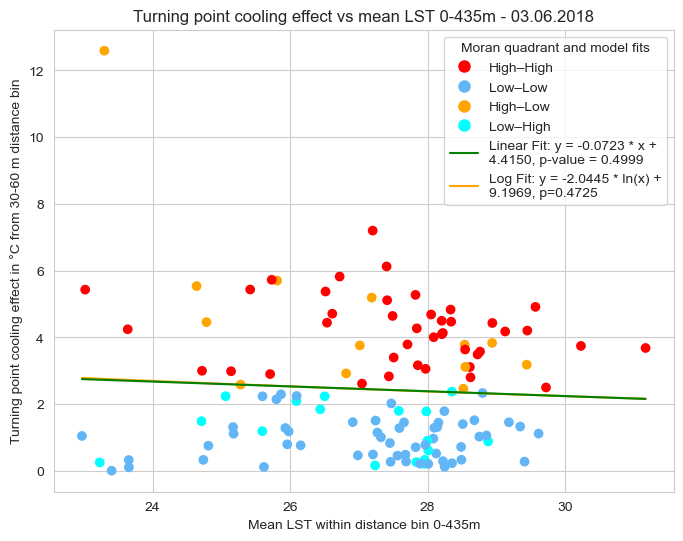

P-value for the logarithmic fit: 0.4725
R-value for the logarithmic fit: -0.0643
The logarithmic fit formula is: y = -2.0445 * ln(x) + 9.1969
P-value for the linear fit: 0.4999
R-value for the linear fit: -0.0604
The linear fit formula is: y = -0.0723 * x + 4.4150


In [77]:
### Graph 5: Analysis: Cooling effect from bin 30-60 as a function of mean LST at bin 0-435m
# Define distance bins (0-30, 30-60, ..., 390-420)
bins = np.arange(30, 450, 30)  # Bins: [0, 30, 60, ..., 420]
bin_labels = bins[:-1] + 15  # Midpoints of each bin for plotting

# Filter lakes with area greater than or equal to 6 ha
lakes_filtered = lakes[lakes['area_ha'] >= 0]

# Get all unique lake IDs from the filtered lakes, ignoring NaNs
unique_ids = np.unique(lakes_source_near[~np.isnan(lakes_source_near)])

# Lists to store results
mean_LST_increases = []  # Mean increase in LST from bin 1 to turning point
lake_sizes = []
lake_quadrants = []
mean_lst_list = []

# Iterate through each unique lake ID from the filtered lakes
for lake_id in unique_ids:
    if lake_id not in lakes_filtered['id'].values:
        continue  # Skip if lake ID is not in the filtered lakes

    base_mask = (lakes_source_near == lake_id) & (lake_dist < 400) & ~np.isnan(lake_dist) & ~np.isnan(lst) & (seas_case != 1) & (sea_dist > 195)

    if np.sum(base_mask) == 0:
        continue

    raster_lst_vals = lst[base_mask]

    lst_at_30_60_mask = base_mask & (lake_dist >= 30) & (lake_dist < 60)
    lst_at_30_60 = np.mean(lst[lst_at_30_60_mask]) if np.any(lst_at_30_60_mask) else np.nan

    mask = base_mask & ~((lake_dist >= 30) & (lake_dist < 60))
    if np.sum(mask) == 0:
        continue

    raster1_vals = lake_dist[mask]
    raster2_vals = lst[mask]

    #values less than 30 has been assigned an index of 0 which here gets converted to -1 after subtracting 1
    # bin 0-30 is not part of this due to the bin start of 30 higher up in the code
    bin_indices = np.digitize(raster1_vals, bins, right=False) - 1  # Ensures 0-30m bin works correctly

    # Compute mean LST for each distance bin
    mean_lst_values = [np.mean(raster2_vals[bin_indices == i]) if np.any(bin_indices == i) else np.nan for i in range(len(bin_labels))]

    # Set ΔLST to zero for the 30-60 bin (reference)
    # For each bin, the ΔLST between bin and 30-60m-lst is calculated (plus if cooling; minus if not cooling)  
    delta_lst = [0 if bin_labels[i] == 45 else (val - lst_at_30_60 if not np.isnan(val) else np.nan) for i, val in enumerate(mean_lst_values)]

    turning_point_index = -1  # Default to -1 if no valid turning point is found
    turn_mean_lst_values = -9999 # Default to mark not existing 

    # Compute mean LST for distance bin 420-450
    if raster_lst_vals.size > 0:
        mean_lst_value = np.nanmean(raster_lst_vals)  # ignores NaNs, safe for non-empty arrays
    else:
        mean_lst_value = np.nan  # skip empty arrays

    # Find indices for 45m (reference) and 75m bins
    try:
        index_45 = np.where(bin_labels == 45)[0][0]  # Extract scalar index 0
        index_75 = np.where(bin_labels == 75)[0][0]  # Extract scalar index 1

        # Compute the change in ΔLST between 45m and 75m bins
        if not np.isnan(lst_at_30_60) and not np.isnan(delta_lst[index_75]):
            if (delta_lst[index_75] > delta_lst[index_45]):
                turning_point_index = index_75
                turn_mean_lst_values =  delta_lst[1] #mean_lst_values[1] #take LST at bin 60-90m
                for i in range(1, len(delta_lst)): 
                    if np.isnan(delta_lst[i]):
                        break
                    if delta_lst[i] < delta_lst[i - 1]:  
                        break  
                    turning_point_index = i 
                    turn_mean_lst_values = delta_lst[i] #replace LST at bin 60-90m with larger (and thus real) turning point) 
        else:
            continue  # Skip plotting if NaN values exist
    except IndexError:
        continue  # Skip plotting if bins are missing

    if turning_point_index >= 0:
        mean_LST_increases.append(turn_mean_lst_values)
        lake_sizes.append(lakes_filtered.loc[lakes_filtered['id'] == lake_id, 'area_ha'].values[0])
        lake_quadrants.append(lakes_filtered.loc[lakes_filtered['id'] == lake_id, 'moran_quadrant_y'].values[0])
        mean_lst_list.append(mean_lst_value)

point_colors = [quadrant_colors[q] for q in lake_quadrants]

# Convert lists to numpy arrays
mean_lst_list = np.array(mean_lst_list)
mean_LST_increases = np.array(mean_LST_increases)
#print(len(lake_sizes))
#print(len(mean_LST_increases))

# Apply logarithmic transformation on lake sizes
#log_lake_sizes = np.log(lake_sizes)

# Fit a logarithmic model: y = a * ln(x) + b
log_mean_lst_list = np.log(np.array(mean_lst_list))  # Logarithmic transformation
slope_log, intercept_log, r_value_log, p_value_log, std_err_log = stats.linregress(log_mean_lst_list, mean_LST_increases)

# Fit a linear model: y = m * x + b
slope_linear, intercept_linear, r_value_linear, p_value_linear, std_err_linear = stats.linregress(mean_lst_list, mean_LST_increases)

# Generate values for plotting the linear
x_vals_lin = np.linspace(min(mean_lst_list), max(mean_lst_list), 100)
y_vals_lin = slope_linear * x_vals_lin + intercept_linear

# Generate values for plotting the fitted curves
y_vals_log = slope_log * np.log(x_vals_lin) + intercept_log  # Logarithmic fit line

# Scatter plot of lake sizes vs mean LST increase
plt.figure(figsize=(8, 6))
plt.scatter(mean_lst_list, mean_LST_increases, c=point_colors, marker='o', label="Observed Data")  # Red dots for data points

# Plot the logarithmic fit
line_log, = plt.plot(x_vals_lin, y_vals_log, color='orange', label=f"Log Fit: y = {slope_log:.4f} * ln(x) +\n{intercept_log:.4f}, p={p_value_log:.4f}")

# Plot the fitted linear trend
line_lin, = plt.plot(x_vals_lin, y_vals_lin, color='green', label=f"Linear Fit: y = {slope_linear:.4f} * x +\n{intercept_linear:.4f}, p-value = {p_value_linear:.4f}")

# Set axis labels and title
plt.xlabel("Mean LST within distance bin 0-435m")
plt.ylabel("Turning point cooling effect in °C from 30-60 m distance bin")
plt.title("Turning point cooling effect vs mean LST 0-435m - 03.06.2018")

# Display grid and legend
plt.grid(True)

# Show the legend
quadrant_handles = [
    mlines.Line2D(
    [], [], 
    color=color, 
    marker='o',  # circle
    linestyle='None',  # no line
    markersize=8, 
    label=quad
    )
    for quad, color in quadrant_colors.items()
]
all_handles = quadrant_handles + [line_lin, line_log]
plt.legend(handles=all_handles, title="Moran quadrant and model fits")

plt.savefig("Plot20180603_turningPointCool30VSmeanLST.png", dpi=400, bbox_inches="tight")

plt.show()

# Print results
print(f"P-value for the logarithmic fit: {p_value_log:.4f}")
print(f"R-value for the logarithmic fit: {r_value_log:.4f}")
print(f"The logarithmic fit formula is: y = {slope_log:.4f} * ln(x) + {intercept_log:.4f}")

print(f"P-value for the linear fit: {p_value_linear:.4f}")
print(f"R-value for the linear fit: {r_value_linear:.4f}")
print(f"The linear fit formula is: y = {slope_linear:.4f} * x + {intercept_linear:.4f}")


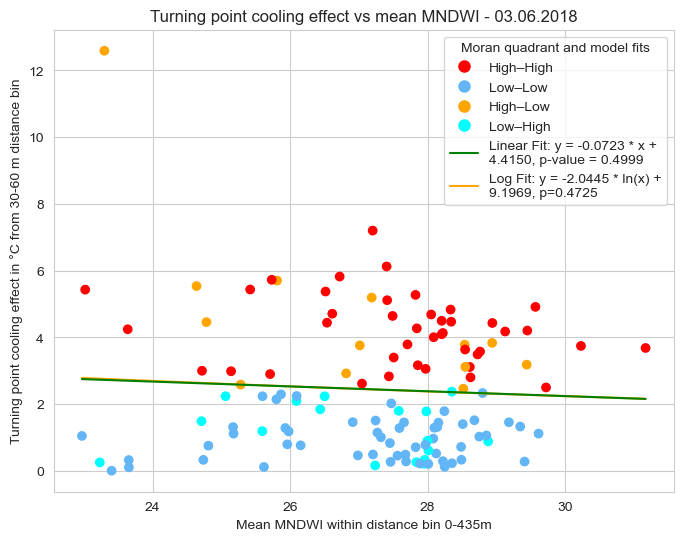

P-value for the logarithmic fit: 0.4725
R-value for the logarithmic fit: -0.0643
The logarithmic fit formula is: y = -2.0445 * ln(x) + 9.1969
P-value for the linear fit: 0.4999
R-value for the linear fit: -0.0604
The linear fit formula is: y = -0.0723 * x + 4.4150


In [78]:
### Graph 6: Analysis: Cooling effect from bin 30-60 as a function of mndwi
# Define distance bins (0-30, 30-60, ..., 390-420)
bins = np.arange(30, 450, 30)  # Bins: [0, 30, 60, ..., 420]
bin_labels = bins[:-1] + 15  # Midpoints of each bin for plotting

# Filter lakes with area greater than or equal to 6 ha
lakes_filtered = lakes[lakes['area_ha'] >= 0]

# Get all unique lake IDs from the filtered lakes, ignoring NaNs
unique_ids = np.unique(lakes_source_near[~np.isnan(lakes_source_near)])

# Lists to store results
mean_LST_increases = []  # Mean increase in LST from bin 1 to turning point
lake_sizes = []
lake_quadrants = []
mean_mndwi_list = [] #mean_mndwi_400m

# Iterate through each unique lake ID from the filtered lakes
for lake_id in unique_ids:
    if lake_id not in lakes_filtered['id'].values:
        continue  # Skip if lake ID is not in the filtered lakes

    base_mask = (lakes_source_near == lake_id) & (lake_dist < 400) & ~np.isnan(lake_dist) & ~np.isnan(lst) & (seas_case != 1) & (sea_dist > 195)

    if np.sum(base_mask) == 0:
        continue

    raster_mndwi_vals = mndwi[base_mask]

    lst_at_30_60_mask = base_mask & (lake_dist >= 30) & (lake_dist < 60)
    lst_at_30_60 = np.mean(lst[lst_at_30_60_mask]) if np.any(lst_at_30_60_mask) else np.nan

    mask = base_mask & ~((lake_dist >= 30) & (lake_dist < 60))
    if np.sum(mask) == 0:
        continue

    raster1_vals = lake_dist[mask]
    raster2_vals = lst[mask]

    #values less than 30 has been assigned an index of 0 which here gets converted to -1 after subtracting 1
    # bin 0-30 is not part of this due to the bin start of 30 higher up in the code
    bin_indices = np.digitize(raster1_vals, bins, right=False) - 1  # Ensures 0-30m bin works correctly

    # Compute mean LST for each distance bin
    mean_lst_values = [np.mean(raster2_vals[bin_indices == i]) if np.any(bin_indices == i) else np.nan for i in range(len(bin_labels))]

    # Set ΔLST to zero for the 30-60 bin (reference)
    # For each bin, the ΔLST between bin and 30-60m-lst is calculated (plus if cooling; minus if not cooling)  
    delta_lst = [0 if bin_labels[i] == 45 else (val - lst_at_30_60 if not np.isnan(val) else np.nan) for i, val in enumerate(mean_lst_values)]

    turning_point_index = -1  # Default to -1 if no valid turning point is found
    turn_mean_lst_values = -9999 # Default to mark not existing 

    # Compute mean LST for distance bin 420-450
    if raster_mndwi_vals.size > 0:
        mean_mndwi_value = np.nanmean(raster_mndwi_vals)  # ignores NaNs, safe for non-empty arrays
    else:
        mean_mndwi_value = np.nan  # skip empty arrays

    # Find indices for 45m (reference) and 75m bins
    try:
        index_45 = np.where(bin_labels == 45)[0][0]  # Extract scalar index 0
        index_75 = np.where(bin_labels == 75)[0][0]  # Extract scalar index 1

        # Compute the change in ΔLST between 45m and 75m bins
        if not np.isnan(lst_at_30_60) and not np.isnan(delta_lst[index_75]):
            if (delta_lst[index_75] > delta_lst[index_45]):
                turning_point_index = index_75
                turn_mean_lst_values =  delta_lst[1] #mean_lst_values[1] #take LST at bin 60-90m
                for i in range(1, len(delta_lst)): 
                    if np.isnan(delta_lst[i]):
                        break
                    if delta_lst[i] < delta_lst[i - 1]:  
                        break  
                    turning_point_index = i 
                    turn_mean_lst_values = delta_lst[i] #replace LST at bin 60-90m with larger (and thus real) turning point) 
        else:
            continue  # Skip plotting if NaN values exist
    except IndexError:
        continue  # Skip plotting if bins are missing

    if turning_point_index >= 0:
        mean_LST_increases.append(turn_mean_lst_values)
        lake_sizes.append(lakes_filtered.loc[lakes_filtered['id'] == lake_id, 'area_ha'].values[0])
        lake_quadrants.append(lakes_filtered.loc[lakes_filtered['id'] == lake_id, 'moran_quadrant_y'].values[0])
        mean_mndwi_list.append(mean_mndwi_value)

point_colors = [quadrant_colors[q] for q in lake_quadrants]

# Convert lists to numpy arrays
mean_mndwi_list = np.array(mean_lst_list)
mean_LST_increases = np.array(mean_LST_increases)
#print(len(lake_sizes))
#print(len(mean_LST_increases))

# Apply logarithmic transformation on lake sizes
#log_lake_sizes = np.log(lake_sizes)

# Fit a logarithmic model: y = a * ln(x) + b
log_mean_mndwi_list = np.log(np.array(mean_mndwi_list))  # Logarithmic transformation
slope_log, intercept_log, r_value_log, p_value_log, std_err_log = stats.linregress(log_mean_mndwi_list, mean_LST_increases)

# Fit a linear model: y = m * x + b
slope_linear, intercept_linear, r_value_linear, p_value_linear, std_err_linear = stats.linregress(mean_mndwi_list, mean_LST_increases)

# Generate values for plotting the linear
x_vals_lin = np.linspace(min(mean_mndwi_list), max(mean_mndwi_list), 100)
y_vals_lin = slope_linear * x_vals_lin + intercept_linear

# Generate values for plotting the fitted curves
y_vals_log = slope_log * np.log(x_vals_lin) + intercept_log  # Logarithmic fit line

# Scatter plot of lake sizes vs mean LST increase
plt.figure(figsize=(8, 6))
plt.scatter(mean_mndwi_list, mean_LST_increases, c=point_colors, marker='o', label="Observed Data")  # Red dots for data points

# Plot the logarithmic fit
line_log, = plt.plot(x_vals_lin, y_vals_log, color='orange', label=f"Log Fit: y = {slope_log:.4f} * ln(x) +\n{intercept_log:.4f}, p={p_value_log:.4f}")

# Plot the fitted linear trend
line_lin, = plt.plot(x_vals_lin, y_vals_lin, color='green', label=f"Linear Fit: y = {slope_linear:.4f} * x +\n{intercept_linear:.4f}, p-value = {p_value_linear:.4f}")

# Set axis labels and title
plt.xlabel("Mean MNDWI within distance bin 0-435m")
plt.ylabel("Turning point cooling effect in °C from 30-60 m distance bin")
plt.title("Turning point cooling effect vs mean MNDWI - 03.06.2018")

# Display grid and legend
plt.grid(True)

# Show the legend
quadrant_handles = [
    mlines.Line2D(
    [], [], 
    color=color, 
    marker='o',  # circle
    linestyle='None',  # no line
    markersize=8, 
    label=quad
    )
    for quad, color in quadrant_colors.items()
]
all_handles = quadrant_handles + [line_lin, line_log]
plt.legend(handles=all_handles, title="Moran quadrant and model fits")

plt.savefig("Plot20180603_turningPointCool30VSmeanMNDWI.png", dpi=400, bbox_inches="tight")

plt.show()

# Print results
print(f"P-value for the logarithmic fit: {p_value_log:.4f}")
print(f"R-value for the logarithmic fit: {r_value_log:.4f}")
print(f"The logarithmic fit formula is: y = {slope_log:.4f} * ln(x) + {intercept_log:.4f}")

print(f"P-value for the linear fit: {p_value_linear:.4f}")
print(f"R-value for the linear fit: {r_value_linear:.4f}")
print(f"The linear fit formula is: y = {slope_linear:.4f} * x + {intercept_linear:.4f}")


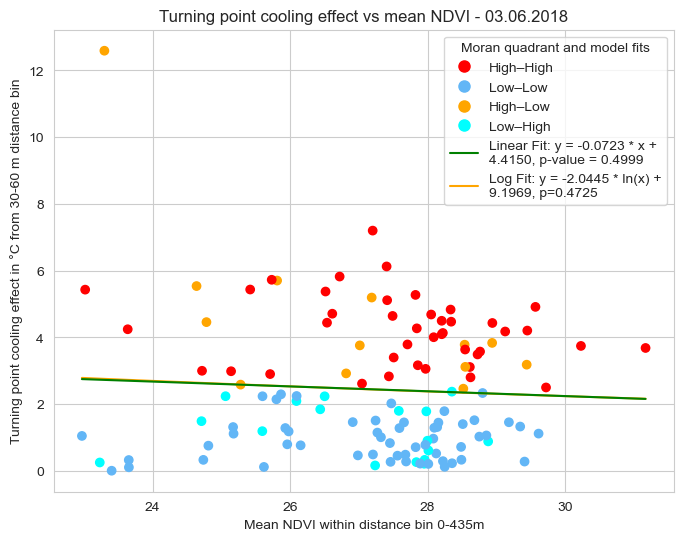

P-value for the logarithmic fit: 0.4725
R-value for the logarithmic fit: -0.0643
The logarithmic fit formula is: y = -2.0445 * ln(x) + 9.1969
P-value for the linear fit: 0.4999
R-value for the linear fit: -0.0604
The linear fit formula is: y = -0.0723 * x + 4.4150


In [79]:
### Graph 6: Analysis: Cooling effect from bin 30-60 as a function of ndvi
# Define distance bins (0-30, 30-60, ..., 390-420)
bins = np.arange(30, 450, 30)  # Bins: [0, 30, 60, ..., 420]
bin_labels = bins[:-1] + 15  # Midpoints of each bin for plotting

# Filter lakes with area greater than or equal to 6 ha
lakes_filtered = lakes[lakes['area_ha'] >= 0]

# Get all unique lake IDs from the filtered lakes, ignoring NaNs
unique_ids = np.unique(lakes_source_near[~np.isnan(lakes_source_near)])

# Lists to store results
mean_LST_increases = []  # Mean increase in LST from bin 1 to turning point
lake_sizes = []
lake_quadrants = []
mean_ndvi_list = [] #mean_mndwi_400m

# Iterate through each unique lake ID from the filtered lakes
for lake_id in unique_ids:
    if lake_id not in lakes_filtered['id'].values:
        continue  # Skip if lake ID is not in the filtered lakes

    base_mask = (lakes_source_near == lake_id) & (lake_dist < 400) & ~np.isnan(lake_dist) & ~np.isnan(lst) & (seas_case != 1) & (sea_dist > 195)
    
    if np.sum(base_mask) == 0:
        continue

    ndvi_mask = base_mask & (lake_dist >= 30)
    raster_ndvi_vals = ndvi[ndvi_mask]

    lst_at_30_60_mask = base_mask & (lake_dist >= 30) & (lake_dist < 60)
    lst_at_30_60 = np.mean(lst[lst_at_30_60_mask]) if np.any(lst_at_30_60_mask) else np.nan

    mask = base_mask & ~((lake_dist >= 30) & (lake_dist < 60))
    if np.sum(mask) == 0:
        continue

    raster1_vals = lake_dist[mask]
    raster2_vals = lst[mask]

    #values less than 30 has been assigned an index of 0 which here gets converted to -1 after subtracting 1
    # bin 0-30 is not part of this due to the bin start of 30 higher up in the code
    bin_indices = np.digitize(raster1_vals, bins, right=False) - 1  # Ensures 0-30m bin works correctly

    # Compute mean LST for each distance bin
    mean_lst_values = [np.mean(raster2_vals[bin_indices == i]) if np.any(bin_indices == i) else np.nan for i in range(len(bin_labels))]

    # Set ΔLST to zero for the 30-60 bin (reference)
    # For each bin, the ΔLST between bin and 30-60m-lst is calculated (plus if cooling; minus if not cooling)  
    delta_lst = [0 if bin_labels[i] == 45 else (val - lst_at_30_60 if not np.isnan(val) else np.nan) for i, val in enumerate(mean_lst_values)]

    turning_point_index = -1  # Default to -1 if no valid turning point is found
    turn_mean_lst_values = -9999 # Default to mark not existing 

    # Compute mean LST for distance bin 420-450
    if raster_ndvi_vals.size > 0:
        mean_ndvi_value = np.nanmean(raster_ndvi_vals)  # ignores NaNs, safe for non-empty arrays
    else:
        mean_ndvi_value = np.nan  # skip empty arrays

    # Find indices for 45m (reference) and 75m bins
    try:
        index_45 = np.where(bin_labels == 45)[0][0]  # Extract scalar index 0
        index_75 = np.where(bin_labels == 75)[0][0]  # Extract scalar index 1

        # Compute the change in ΔLST between 45m and 75m bins
        if not np.isnan(lst_at_30_60) and not np.isnan(delta_lst[index_75]):
            if (delta_lst[index_75] > delta_lst[index_45]):
                turning_point_index = index_75
                turn_mean_lst_values =  delta_lst[1] #mean_lst_values[1] #take LST at bin 60-90m
                for i in range(1, len(delta_lst)): 
                    if np.isnan(delta_lst[i]):
                        break
                    if delta_lst[i] < delta_lst[i - 1]:  
                        break  
                    turning_point_index = i 
                    turn_mean_lst_values = delta_lst[i] #replace LST at bin 60-90m with larger (and thus real) turning point) 
        else:
            continue  # Skip plotting if NaN values exist
    except IndexError:
        continue  # Skip plotting if bins are missing

    if turning_point_index >= 0:
        mean_LST_increases.append(turn_mean_lst_values)
        lake_sizes.append(lakes_filtered.loc[lakes_filtered['id'] == lake_id, 'area_ha'].values[0])
        lake_quadrants.append(lakes_filtered.loc[lakes_filtered['id'] == lake_id, 'moran_quadrant_y'].values[0])
        mean_ndvi_list.append(mean_ndvi_value)

point_colors = [quadrant_colors[q] for q in lake_quadrants]

# Convert lists to numpy arrays
mean_ndvi_list = np.array(mean_lst_list)
mean_LST_increases = np.array(mean_LST_increases)
#print(len(lake_sizes))
#print(len(mean_LST_increases))

# Apply logarithmic transformation on lake sizes
#log_lake_sizes = np.log(lake_sizes)

# Fit a logarithmic model: y = a * ln(x) + b
log_mean_ndvi_list = np.log(np.array(mean_ndvi_list))  # Logarithmic transformation
slope_log, intercept_log, r_value_log, p_value_log, std_err_log = stats.linregress(log_mean_ndvi_list, mean_LST_increases)

# Fit a linear model: y = m * x + b
slope_linear, intercept_linear, r_value_linear, p_value_linear, std_err_linear = stats.linregress(mean_ndvi_list, mean_LST_increases)

# Generate values for plotting the linear
x_vals_lin = np.linspace(min(mean_ndvi_list), max(mean_ndvi_list), 100)
y_vals_lin = slope_linear * x_vals_lin + intercept_linear

# Generate values for plotting the fitted curves
y_vals_log = slope_log * np.log(x_vals_lin) + intercept_log  # Logarithmic fit line

# Scatter plot of lake sizes vs mean LST increase
plt.figure(figsize=(8, 6))
plt.scatter(mean_ndvi_list, mean_LST_increases, c=point_colors, marker='o', label="Observed Data")  # Red dots for data points

# Plot the logarithmic fit
line_log, = plt.plot(x_vals_lin, y_vals_log, color='orange', label=f"Log Fit: y = {slope_log:.4f} * ln(x) +\n{intercept_log:.4f}, p={p_value_log:.4f}")

# Plot the fitted linear trend
line_lin, = plt.plot(x_vals_lin, y_vals_lin, color='green', label=f"Linear Fit: y = {slope_linear:.4f} * x +\n{intercept_linear:.4f}, p-value = {p_value_linear:.4f}")

# Set axis labels and title
plt.xlabel("Mean NDVI within distance bin 0-435m")
plt.ylabel("Turning point cooling effect in °C from 30-60 m distance bin")
plt.title("Turning point cooling effect vs mean NDVI - 03.06.2018")

# Display grid and legend
plt.grid(True)

# Show the legend
quadrant_handles = [
    mlines.Line2D(
    [], [], 
    color=color, 
    marker='o',  # circle
    linestyle='None',  # no line
    markersize=8, 
    label=quad
    )
    for quad, color in quadrant_colors.items()
]
all_handles = quadrant_handles + [line_lin, line_log]
plt.legend(handles=all_handles, title="Moran quadrant and model fits")

plt.savefig("Plot20180603_turningPointCool30VSmeanNDVI.png", dpi=400, bbox_inches="tight")

plt.show()

# Print results
print(f"P-value for the logarithmic fit: {p_value_log:.4f}")
print(f"R-value for the logarithmic fit: {r_value_log:.4f}")
print(f"The logarithmic fit formula is: y = {slope_log:.4f} * ln(x) + {intercept_log:.4f}")

print(f"P-value for the linear fit: {p_value_linear:.4f}")
print(f"R-value for the linear fit: {r_value_linear:.4f}")
print(f"The linear fit formula is: y = {slope_linear:.4f} * x + {intercept_linear:.4f}")


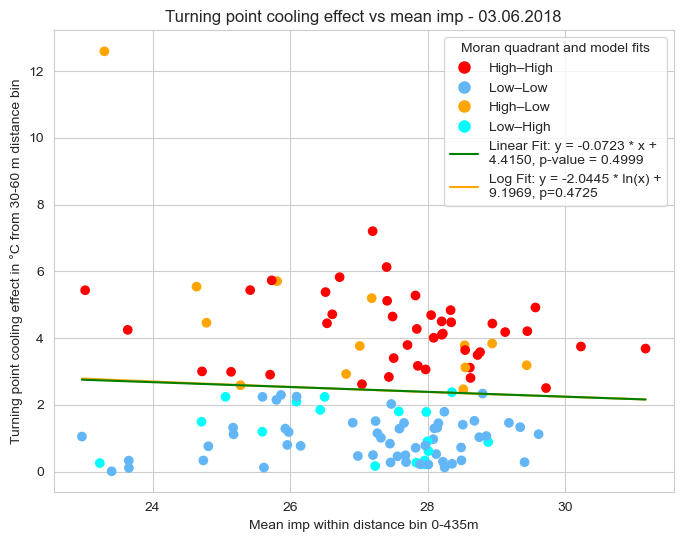

P-value for the logarithmic fit: 0.4725
R-value for the logarithmic fit: -0.0643
The logarithmic fit formula is: y = -2.0445 * ln(x) + 9.1969
P-value for the linear fit: 0.4999
R-value for the linear fit: -0.0604
The linear fit formula is: y = -0.0723 * x + 4.4150


In [80]:
### Graph 6: Analysis: Cooling effect from bin 30-60 as a function of imp
# Define distance bins (0-30, 30-60, ..., 390-420)
bins = np.arange(30, 450, 30)  # Bins: [0, 30, 60, ..., 420]
bin_labels = bins[:-1] + 15  # Midpoints of each bin for plotting

# Filter lakes with area greater than or equal to 6 ha
lakes_filtered = lakes[lakes['area_ha'] >= 0]

# Get all unique lake IDs from the filtered lakes, ignoring NaNs
unique_ids = np.unique(lakes_source_near[~np.isnan(lakes_source_near)])

# Lists to store results
mean_LST_increases = []  # Mean increase in LST from bin 1 to turning point
lake_sizes = []
lake_quadrants = []
mean_imp_list = [] #mean_mndwi_400m

# Iterate through each unique lake ID from the filtered lakes
for lake_id in unique_ids:
    if lake_id not in lakes_filtered['id'].values:
        continue  # Skip if lake ID is not in the filtered lakes

    base_mask = (lakes_source_near == lake_id) & (lake_dist < 400) & ~np.isnan(lake_dist) & ~np.isnan(lst) & (seas_case != 1) & (sea_dist > 195)
    
    if np.sum(base_mask) == 0:
        continue

    imp_mask = base_mask & (lake_dist >= 30)
    raster_imp_vals = imp[imp_mask]

    lst_at_30_60_mask = base_mask & (lake_dist >= 30) & (lake_dist < 60)
    lst_at_30_60 = np.mean(lst[lst_at_30_60_mask]) if np.any(lst_at_30_60_mask) else np.nan

    mask = base_mask & ~((lake_dist >= 30) & (lake_dist < 60))
    if np.sum(mask) == 0:
        continue

    raster1_vals = lake_dist[mask]
    raster2_vals = lst[mask]

    #values less than 30 has been assigned an index of 0 which here gets converted to -1 after subtracting 1
    # bin 0-30 is not part of this due to the bin start of 30 higher up in the code
    bin_indices = np.digitize(raster1_vals, bins, right=False) - 1  # Ensures 0-30m bin works correctly

    # Compute mean LST for each distance bin
    mean_lst_values = [np.mean(raster2_vals[bin_indices == i]) if np.any(bin_indices == i) else np.nan for i in range(len(bin_labels))]

    # Set ΔLST to zero for the 30-60 bin (reference)
    # For each bin, the ΔLST between bin and 30-60m-lst is calculated (plus if cooling; minus if not cooling)  
    delta_lst = [0 if bin_labels[i] == 45 else (val - lst_at_30_60 if not np.isnan(val) else np.nan) for i, val in enumerate(mean_lst_values)]

    turning_point_index = -1  # Default to -1 if no valid turning point is found
    turn_mean_lst_values = -9999 # Default to mark not existing 

    # Compute mean LST for distance bin 420-450
    if raster_imp_vals.size > 0:
        mean_imp_value = np.nanmean(raster_imp_vals)  # ignores NaNs, safe for non-empty arrays
    else:
        mean_imp_value = np.nan  # skip empty arrays

    # Find indices for 45m (reference) and 75m bins
    try:
        index_45 = np.where(bin_labels == 45)[0][0]  # Extract scalar index 0
        index_75 = np.where(bin_labels == 75)[0][0]  # Extract scalar index 1

        # Compute the change in ΔLST between 45m and 75m bins
        if not np.isnan(lst_at_30_60) and not np.isnan(delta_lst[index_75]):
            if (delta_lst[index_75] > delta_lst[index_45]):
                turning_point_index = index_75
                turn_mean_lst_values =  delta_lst[1] #mean_lst_values[1] #take LST at bin 60-90m
                for i in range(1, len(delta_lst)): 
                    if np.isnan(delta_lst[i]):
                        break
                    if delta_lst[i] < delta_lst[i - 1]:  
                        break  
                    turning_point_index = i 
                    turn_mean_lst_values = delta_lst[i] #replace LST at bin 60-90m with larger (and thus real) turning point) 
        else:
            continue  # Skip plotting if NaN values exist
    except IndexError:
        continue  # Skip plotting if bins are missing

    if turning_point_index >= 0:
        mean_LST_increases.append(turn_mean_lst_values)
        lake_sizes.append(lakes_filtered.loc[lakes_filtered['id'] == lake_id, 'area_ha'].values[0])
        lake_quadrants.append(lakes_filtered.loc[lakes_filtered['id'] == lake_id, 'moran_quadrant_y'].values[0])
        mean_imp_list.append(mean_imp_value)

point_colors = [quadrant_colors[q] for q in lake_quadrants]

# Convert lists to numpy arrays
mean_imp_list = np.array(mean_lst_list)
mean_LST_increases = np.array(mean_LST_increases)
#print(len(lake_sizes))
#print(len(mean_LST_increases))

# Apply logarithmic transformation on lake sizes
#log_lake_sizes = np.log(lake_sizes)

# Fit a logarithmic model: y = a * ln(x) + b
log_mean_imp_list = np.log(np.array(mean_imp_list))  # Logarithmic transformation
slope_log, intercept_log, r_value_log, p_value_log, std_err_log = stats.linregress(log_mean_imp_list, mean_LST_increases)

# Fit a linear model: y = m * x + b
slope_linear, intercept_linear, r_value_linear, p_value_linear, std_err_linear = stats.linregress(mean_imp_list, mean_LST_increases)

# Generate values for plotting the linear
x_vals_lin = np.linspace(min(mean_imp_list), max(mean_imp_list), 100)
y_vals_lin = slope_linear * x_vals_lin + intercept_linear

# Generate values for plotting the fitted curves
y_vals_log = slope_log * np.log(x_vals_lin) + intercept_log  # Logarithmic fit line

# Scatter plot of lake sizes vs mean LST increase
plt.figure(figsize=(8, 6))
plt.scatter(mean_imp_list, mean_LST_increases, c=point_colors, marker='o', label="Observed Data")  # Red dots for data points

# Plot the logarithmic fit
line_log, = plt.plot(x_vals_lin, y_vals_log, color='orange', label=f"Log Fit: y = {slope_log:.4f} * ln(x) +\n{intercept_log:.4f}, p={p_value_log:.4f}")

# Plot the fitted linear trend
line_lin, = plt.plot(x_vals_lin, y_vals_lin, color='green', label=f"Linear Fit: y = {slope_linear:.4f} * x +\n{intercept_linear:.4f}, p-value = {p_value_linear:.4f}")

# Set axis labels and title
plt.xlabel("Mean imp within distance bin 0-435m")
plt.ylabel("Turning point cooling effect in °C from 30-60 m distance bin")
plt.title("Turning point cooling effect vs mean imp - 03.06.2018")

# Display grid and legend
plt.grid(True)

# Show the legend
quadrant_handles = [
    mlines.Line2D(
    [], [], 
    color=color, 
    marker='o',  # circle
    linestyle='None',  # no line
    markersize=8, 
    label=quad
    )
    for quad, color in quadrant_colors.items()
]
all_handles = quadrant_handles + [line_lin, line_log]
plt.legend(handles=all_handles, title="Moran quadrant and model fits")

plt.savefig("Plot20180603_turningPointCool30VSmeanimp.png", dpi=400, bbox_inches="tight")

plt.show()

# Print results
print(f"P-value for the logarithmic fit: {p_value_log:.4f}")
print(f"R-value for the logarithmic fit: {r_value_log:.4f}")
print(f"The logarithmic fit formula is: y = {slope_log:.4f} * ln(x) + {intercept_log:.4f}")

print(f"P-value for the linear fit: {p_value_linear:.4f}")
print(f"R-value for the linear fit: {r_value_linear:.4f}")
print(f"The linear fit formula is: y = {slope_linear:.4f} * x + {intercept_linear:.4f}")

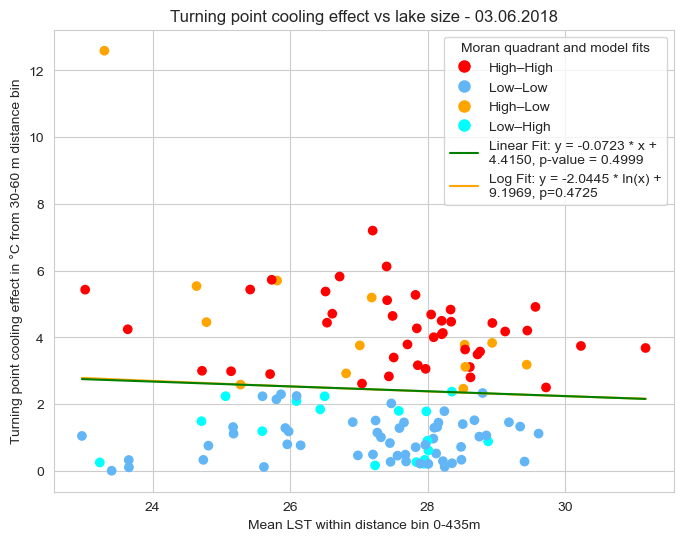

P-value for the logarithmic fit: 0.4725
R-value for the logarithmic fit: -0.0643
The logarithmic fit formula is: y = -2.0445 * ln(x) + 9.1969
P-value for the linear fit: 0.4999
R-value for the linear fit: -0.0604
The linear fit formula is: y = -0.0723 * x + 4.4150


In [81]:
### Graph 5: Analysis: Cooling effect from bin 30-60 as a function of mean LST at bin 0-435m
# Define distance bins (0-30, 30-60, ..., 390-420)
bins = np.arange(30, 450, 30)  # Bins: [0, 30, 60, ..., 420]
bin_labels = bins[:-1] + 15  # Midpoints of each bin for plotting

# Filter lakes with area greater than or equal to 6 ha
lakes_filtered = lakes[lakes['area_ha'] >= 0]

# Get all unique lake IDs from the filtered lakes, ignoring NaNs
unique_ids = np.unique(lakes_source_near[~np.isnan(lakes_source_near)])

# Lists to store results
mean_LST_increases = []  # Mean increase in LST from bin 1 to turning point
lake_sizes = []
lake_quadrants = []
mean_lst_list = []

# Iterate through each unique lake ID from the filtered lakes
for lake_id in unique_ids:
    if lake_id not in lakes_filtered['id'].values:
        continue  # Skip if lake ID is not in the filtered lakes

    base_mask = (lakes_source_near == lake_id) & (lake_dist < 400) & ~np.isnan(lake_dist) & ~np.isnan(lst) & (seas_case != 1) & (sea_dist > 195)

    if np.sum(base_mask) == 0:
        continue

    raster_lst_vals = lst[base_mask]

    lst_at_30_60_mask = base_mask & (lake_dist >= 30) & (lake_dist < 60)
    lst_at_30_60 = np.mean(lst[lst_at_30_60_mask]) if np.any(lst_at_30_60_mask) else np.nan

    mask = base_mask & ~((lake_dist >= 30) & (lake_dist < 60))
    if np.sum(mask) == 0:
        continue

    raster1_vals = lake_dist[mask]
    raster2_vals = lst[mask]

    #values less than 30 has been assigned an index of 0 which here gets converted to -1 after subtracting 1
    # bin 0-30 is not part of this due to the bin start of 30 higher up in the code
    bin_indices = np.digitize(raster1_vals, bins, right=False) - 1  # Ensures 0-30m bin works correctly

    # Compute mean LST for each distance bin
    mean_lst_values = [np.mean(raster2_vals[bin_indices == i]) if np.any(bin_indices == i) else np.nan for i in range(len(bin_labels))]

    # Set ΔLST to zero for the 30-60 bin (reference)
    # For each bin, the ΔLST between bin and 30-60m-lst is calculated (plus if cooling; minus if not cooling)  
    delta_lst = [0 if bin_labels[i] == 45 else (val - lst_at_30_60 if not np.isnan(val) else np.nan) for i, val in enumerate(mean_lst_values)]

    turning_point_index = -1  # Default to -1 if no valid turning point is found
    turn_mean_lst_values = -9999 # Default to mark not existing 

    # Compute mean LST for distance bin 420-450
    if raster_lst_vals.size > 0:
        mean_lst_value = np.nanmean(raster_lst_vals)  # ignores NaNs, safe for non-empty arrays
    else:
        mean_lst_value = np.nan  # skip empty arrays

    # Find indices for 45m (reference) and 75m bins
    try:
        index_45 = np.where(bin_labels == 45)[0][0]  # Extract scalar index 0
        index_75 = np.where(bin_labels == 75)[0][0]  # Extract scalar index 1

        # Compute the change in ΔLST between 45m and 75m bins
        if not np.isnan(lst_at_30_60) and not np.isnan(delta_lst[index_75]):
            if (delta_lst[index_75] > delta_lst[index_45]):
                turning_point_index = index_75
                turn_mean_lst_values =  delta_lst[1] #mean_lst_values[1] #take LST at bin 60-90m
                for i in range(1, len(delta_lst)): 
                    if np.isnan(delta_lst[i]):
                        break
                    if delta_lst[i] < delta_lst[i - 1]:  
                        break  
                    turning_point_index = i 
                    turn_mean_lst_values = delta_lst[i] #replace LST at bin 60-90m with larger (and thus real) turning point) 
        else:
            continue  # Skip plotting if NaN values exist
    except IndexError:
        continue  # Skip plotting if bins are missing

    if turning_point_index >= 0:
        mean_LST_increases.append(turn_mean_lst_values)
        lake_sizes.append(lakes_filtered.loc[lakes_filtered['id'] == lake_id, 'area_ha'].values[0])
        lake_quadrants.append(lakes_filtered.loc[lakes_filtered['id'] == lake_id, 'moran_quadrant_y'].values[0])
        mean_lst_list.append(mean_lst_value)

point_colors = [quadrant_colors[q] for q in lake_quadrants]

# Convert lists to numpy arrays
mean_lst_list = np.array(mean_lst_list)
mean_LST_increases = np.array(mean_LST_increases)
#print(len(lake_sizes))
#print(len(mean_LST_increases))

# Apply logarithmic transformation on lake sizes
#log_lake_sizes = np.log(lake_sizes)

# Fit a logarithmic model: y = a * ln(x) + b
log_mean_lst_list = np.log(np.array(mean_lst_list))  # Logarithmic transformation
slope_log, intercept_log, r_value_log, p_value_log, std_err_log = stats.linregress(log_mean_lst_list, mean_LST_increases)

# Fit a linear model: y = m * x + b
slope_linear, intercept_linear, r_value_linear, p_value_linear, std_err_linear = stats.linregress(mean_lst_list, mean_LST_increases)

# Generate values for plotting the linear
x_vals_lin = np.linspace(min(mean_lst_list), max(mean_lst_list), 100)
y_vals_lin = slope_linear * x_vals_lin + intercept_linear

# Generate values for plotting the fitted curves
y_vals_log = slope_log * np.log(x_vals_lin) + intercept_log  # Logarithmic fit line

# Scatter plot of lake sizes vs mean LST increase
plt.figure(figsize=(8, 6))
plt.scatter(mean_lst_list, mean_LST_increases, c=point_colors, marker='o', label="Observed Data")  # Red dots for data points

# Plot the logarithmic fit
line_log, = plt.plot(x_vals_lin, y_vals_log, color='orange', label=f"Log Fit: y = {slope_log:.4f} * ln(x) +\n{intercept_log:.4f}, p={p_value_log:.4f}")

# Plot the fitted linear trend
line_lin, = plt.plot(x_vals_lin, y_vals_lin, color='green', label=f"Linear Fit: y = {slope_linear:.4f} * x +\n{intercept_linear:.4f}, p-value = {p_value_linear:.4f}")

# Set axis labels and title
plt.xlabel("Mean LST within distance bin 0-435m")
plt.ylabel("Turning point cooling effect in °C from 30-60 m distance bin")
plt.title("Turning point cooling effect vs lake size - 03.06.2018")

# Display grid and legend
plt.grid(True)

# Show the legend
quadrant_handles = [
    mlines.Line2D(
    [], [], 
    color=color, 
    marker='o',  # circle
    linestyle='None',  # no line
    markersize=8, 
    label=quad
    )
    for quad, color in quadrant_colors.items()
]
all_handles = quadrant_handles + [line_lin, line_log]
plt.legend(handles=all_handles, title="Moran quadrant and model fits")

plt.savefig("Plot20180603_turningPointCool30VSmeanLST.png", dpi=400, bbox_inches="tight")

plt.show()

# Print results
print(f"P-value for the logarithmic fit: {p_value_log:.4f}")
print(f"R-value for the logarithmic fit: {r_value_log:.4f}")
print(f"The logarithmic fit formula is: y = {slope_log:.4f} * ln(x) + {intercept_log:.4f}")

print(f"P-value for the linear fit: {p_value_linear:.4f}")
print(f"R-value for the linear fit: {r_value_linear:.4f}")
print(f"The linear fit formula is: y = {slope_linear:.4f} * x + {intercept_linear:.4f}")


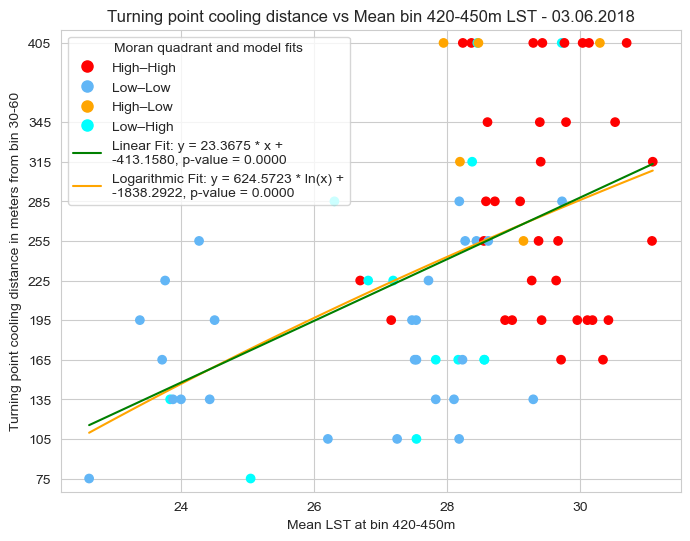

P-value for the logarithmic fit: 0.0000
R-value for the logarithmic fit: 0.4820
The logarithmic fit formula is: y = 624.5723 * ln(x) + -1838.2922
P-value for the linear fit: 0.0000
R-value for the linear fit: 0.4851
The linear fit formula is: y = 23.3675 * x + -413.1580


In [82]:
### EXTRA: Analysis Turning point distance to bin 30-60 as a function of LST at bin 420-450  
# Define distance bins (0-30, 30-60, ..., 390-420)
bins = np.arange(30, 450, 30)  # Bins: [0, 30, 60, ..., 420]
bin_labels = bins[:-1] + 15  # Midpoints of each bin for plotting

# Filter lakes with area greater than or equal to 6 ha (or adjust threshold as needed)
lakes_filtered = lakes[lakes['area_ha'] >= 0]

# Get all unique lake IDs from the filtered lakes, ignoring NaNs
unique_ids = np.unique(lakes_source_near[~np.isnan(lakes_source_near)])

# List to store turning points and corresponding lake sizes
turning_points = []
lst_435_lakes = []
lake_quadrants = []

# Initialize figure for plotting both fits
plt.figure(figsize=(8, 6))

# Iterate through each unique lake ID from the filtered lakes
for lake_id in unique_ids:
    if lake_id not in lakes_filtered['id'].values:
        continue  # Skip if lake ID is not in the filtered lakes

    base_mask = (lakes_source_near == lake_id) & (lake_dist < 400) & ~np.isnan(lake_dist) & ~np.isnan(lst) & (seas_case != 1) & (sea_dist > 195)
    
    lst_435_mask = (lakes_source_near == lake_id) & (lake_dist >= 420) & (lake_dist < 450) & ~np.isnan(lake_dist) & ~np.isnan(lst) & (seas_case != 1) & (sea_dist > 195)

    if np.sum(base_mask) == 0:
        continue

    # Compute mean LST for `dist = 30-60` (used as reference)
    lst_at_30_60_mask = base_mask & (lake_dist >= 30) & (lake_dist < 60)
    lst_at_30_60 = np.mean(lst[lst_at_30_60_mask]) if np.any(lst_at_30_60_mask) else np.nan
    
    mask = base_mask & ~((lake_dist >= 30) & (lake_dist < 60))
    if np.sum(mask) == 0:
        continue

    raster1_vals = lake_dist[mask]
    raster2_vals = lst[mask]
    raster3_vals = lst[lst_435_mask]

    #values less than 30 has been assigned an index of 0 which here gets converted to -1 after subtracting 1
    # bin 0-30 is not part of this due to the bin start of 30 higher up in the code
    bin_indices = np.digitize(raster1_vals, bins, right=False) - 1  # Ensures 0-30m bin works correctly

    # Compute mean LST for each distance bin
    mean_lst_values = [np.mean(raster2_vals[bin_indices == i]) if np.any(bin_indices == i) else np.nan for i in range(len(bin_labels))]

    # Set ΔLST to zero for the 30-60 bin (reference)
    # For each bin, the ΔLST between bin and 30-60m-lst is calculated (plus if cooling; minus if not cooling)  
    delta_lst = [0 if bin_labels[i] == 45 else (mean_lst_values[i] - lst_at_30_60 if not np.isnan(mean_lst_values[i]) else np.nan) for i in range(len(bin_labels))]
  
    # Compute mean LST for distance bin 420-450
    if raster3_vals.size > 0:
        mean_lst435_value = np.nanmean(raster3_vals)  # ignores NaNs, safe for non-empty arrays
    else:
        mean_lst435_value = np.nan  # skip empty arrays

    turning_point_index = -1  # Default to -1 if no valid turning point is found

    # Find indices for 45m (reference) and 75m bins
    try:
        index_45 = np.where(bin_labels == 45)[0][0]  # Extract scalar index 0
        index_75 = np.where(bin_labels == 75)[0][0]  # Extract scalar index 1

        # Compute the change in ΔLST between 45m and 75m bins
        if not np.isnan(delta_lst[index_45]) and not np.isnan(delta_lst[index_75]):
            if (delta_lst[index_75] > delta_lst[index_45]):
                turning_point_index = index_75
                for i in range(1, len(mean_lst_values)): 
                    if mean_lst_values[i] < mean_lst_values[i - 1]:  
                        break  
                    turning_point_index = i  
        else:
            continue  # Skip plotting if NaN values exist
    except IndexError:
        continue  # Skip plotting if bins are missing

    if turning_point_index >= 0 and not np.isnan(mean_lst435_value):
        turning_point_distance = bin_labels[turning_point_index]  
        turning_points.append(turning_point_distance)
        lst_435_lakes.append(mean_lst435_value)
        lake_quadrants.append(lakes_filtered.loc[lakes_filtered['id'] == lake_id, 'moran_quadrant_y'].values[0])

point_colors = [quadrant_colors[q] for q in lake_quadrants]

# Plot the turning points vs lake size as a scatter plot
plt.scatter(lst_435_lakes, turning_points, c=point_colors, marker='o', label="Observed data")

# Logarithmic Fit
log_lst_435_lakes = np.log(np.array(lst_435_lakes))  # Logarithmic transformation
slope_log, intercept_log, r_value_log, p_value_log, std_err_log = stats.linregress(log_lst_435_lakes, turning_points)

# Plot the fitted logarithmic curve
x_vals_log = np.linspace(min(log_lst_435_lakes), max(log_lst_435_lakes), 100)
y_vals_log = slope_log * x_vals_log + intercept_log  # Logarithmic fit line
line_log, = plt.plot(np.exp(x_vals_log), y_vals_log, color='orange', label=f"Logarithmic Fit: y = {slope_log:.4f} * ln(x) +\n{intercept_log:.4f}, p-value = {p_value_log:.4f}")

# Linear Fit
slope_lin, intercept_lin, r_value_lin, p_value_lin, std_err_lin = stats.linregress(lst_435_lakes, turning_points)

# Plot the fitted linear trend
x_vals_lin = np.linspace(min(lst_435_lakes), max(lst_435_lakes), 100)
y_vals_lin = slope_lin * x_vals_lin + intercept_lin
line_lin, = plt.plot(x_vals_lin, y_vals_lin, color='green', label=f"Linear Fit: y = {slope_lin:.4f} * x +\n{intercept_lin:.4f}, p-value = {p_value_lin:.4f}")

# Set axis labels and title
plt.xlabel("Mean LST at bin 420-450m")
plt.ylabel("Turning point cooling distance in meters from bin 30-60")
plt.title("Turning point cooling distance vs Mean bin 420-450m LST - 03.06.2018")

# Adjust y-axis
plt.ylim(min(turning_points) - 10, max(turning_points) + 10)  
plt.yticks(np.unique(turning_points))

# Show grid for better readability
plt.grid(True)

import matplotlib.lines as mlines

# Show the legend
quadrant_handles = [
    mlines.Line2D(
    [], [], 
    color=color, 
    marker='o',  # circle
    linestyle='None',  # no line
    markersize=8, 
    label=quad
    )
    for quad, color in quadrant_colors.items()
]
all_handles = quadrant_handles + [line_lin, line_log]
plt.legend(handles=all_handles, title="Moran quadrant and model fits")

plt.savefig("Plot20180603_turningPointDist30VSLST435m.png", dpi=400, bbox_inches="tight")

# Show the plot
plt.show()

# Print results for both fits
print(f"P-value for the logarithmic fit: {p_value_log:.4f}")
print(f"R-value for the logarithmic fit: {r_value_log:.4f}")
print(f"The logarithmic fit formula is: y = {slope_log:.4f} * ln(x) + {intercept_log:.4f}")

print(f"P-value for the linear fit: {p_value_lin:.4f}")
print(f"R-value for the linear fit: {r_value_lin:.4f}")
print(f"The linear fit formula is: y = {slope_lin:.4f} * x + {intercept_lin:.4f}")


<Figure size 800x600 with 0 Axes>

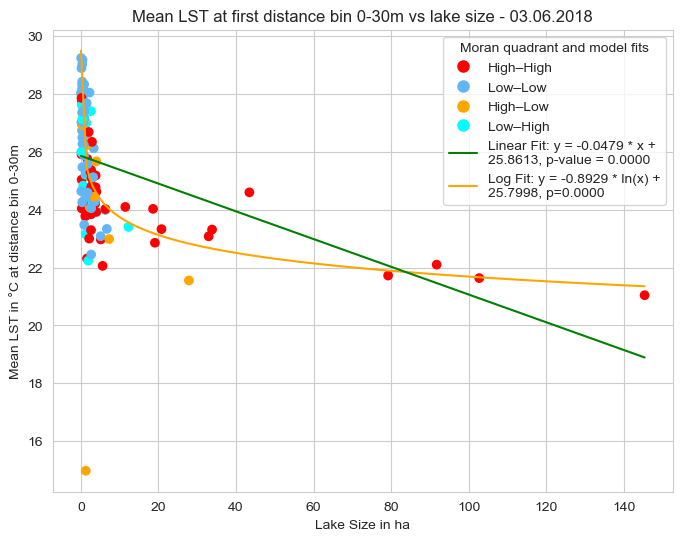

P-value for the logarithmic fit: 0.0000
R-value for the logarithmic fit: -0.6554
The logarithmic fit formula is: y = -0.8929 * ln(x) + 25.7998
P-value for the linear fit: 0.0000
R-value for the linear fit: -0.4299
The linear fit formula is: y = -0.0479 * x + 25.8613


In [83]:
### Graph EXTRA: Analysis of mean LST at bin 0-30 as a function of lake size 
# Define distance bins (0-30, 30-60, ..., 390-420)
bins = np.arange(30, 450, 30)  # Bins: [0, 30, 60, ..., 420]
bin_labels = bins[:-1] + 15  # Midpoints of each bin for plotting

# Filter lakes with area greater than or equal to 6 ha
lakes_filtered = lakes[lakes['area_ha'] >= 0]

# Get all unique lake IDs from the filtered lakes, ignoring NaNs
unique_ids = np.unique(lakes_source_near[~np.isnan(lakes_source_near)])

# Lists to store results
lst_15_lakes = []  # Mean LST at first bin (30-60m)
lake_sizes = []
lake_quadrants = []

plt.figure(figsize=(8, 6))  # Initialize figure

# Iterate through each unique lake ID from the filtered lakes
for lake_id in unique_ids:
    if lake_id not in lakes_filtered['id'].values:
        continue  # Skip if lake ID is not in the filtered lakes

    mask_15 = (lakes_source_near == lake_id) & ((lake_dist >= 0) & (lake_dist < 30)) & ~np.isnan(lake_dist) & ~np.isnan(lst) & (seas_case != 1) & (sea_dist > 195)

    if np.sum(mask_15) == 0:
        continue

    raster1_vals = lst[mask_15]

    # Compute mean LST for distance bin 0-30
    if raster1_vals.size > 0:
        mean_lst_value = np.nanmean(raster1_vals)  # ignores NaNs, safe for non-empty arrays
    else:
        mean_lst_value = np.nan  # skip empty arrays

    if not np.isnan(mean_lst_value):
        lake_sizes.append(lakes_filtered.loc[lakes_filtered['id'] == lake_id, 'area_ha'].values[0])
        lst_15_lakes.append(mean_lst_value)
        lake_quadrants.append(lakes_filtered.loc[lakes_filtered['id'] == lake_id, 'moran_quadrant_y'].values[0])

point_colors = [quadrant_colors[q] for q in lake_quadrants]

# Apply logarithmic transformation on lake sizes
log_lake_sizes = np.log(lake_sizes)

# Fit a logarithmic model: y = a * ln(x) + b
log_lake_sizes = np.log(np.array(lake_sizes))  # Logarithmic transformation
slope_log, intercept_log, r_value_log, p_value_log, std_err_log = stats.linregress(log_lake_sizes, lst_15_lakes)

# Fit a linear model: y = m * x + b
slope_linear, intercept_linear, r_value_linear, p_value_linear, std_err_linear = stats.linregress(lake_sizes, lst_15_lakes)

# Generate values for plotting the linear
x_vals_lin = np.linspace(min(lake_sizes), max(lake_sizes), 100)
y_vals_lin = slope_linear * x_vals_lin + intercept_linear

# Generate values for plotting the fitted curves
y_vals_log = slope_log * np.log(x_vals_lin) + intercept_log  # Logarithmic fit line

# Scatter plot of lake sizes vs mean LST increase
plt.figure(figsize=(8, 6))
plt.scatter(lake_sizes, lst_15_lakes, c=point_colors, marker='o', label="Observed Data")  # Red dots for data points

# Plot the logarithmic fit
line_log, = plt.plot(x_vals_lin, y_vals_log, color='orange', label=f"Log Fit: y = {slope_log:.4f} * ln(x) +\n{intercept_log:.4f}, p={p_value_log:.4f}")

# Plot the fitted linear trend
line_lin, = plt.plot(x_vals_lin, y_vals_lin, color='green', label=f"Linear Fit: y = {slope_linear:.4f} * x +\n{intercept_linear:.4f}, p-value = {p_value_linear:.4f}")

# Set axis labels and title
plt.xlabel("Lake Size in ha")
plt.ylabel("Mean LST in °C at distance bin 0-30m")
plt.title("Mean LST at first distance bin 0-30m vs lake size - 03.06.2018")

# Display grid and legend
plt.grid(True)

# Show the legend
quadrant_handles = [
    mlines.Line2D(
    [], [], 
    color=color, 
    marker='o',  # circle
    linestyle='None',  # no line
    markersize=8, 
    label=quad
    )
    for quad, color in quadrant_colors.items()
]
all_handles = quadrant_handles + [line_lin, line_log]
plt.legend(handles=all_handles, title="Moran quadrant and model fits")

plt.savefig("Plot20180603_LSTatLakeVSlakeSize.png", dpi=400, bbox_inches="tight")

plt.show()

# Print results
print(f"P-value for the logarithmic fit: {p_value_log:.4f}")
print(f"R-value for the logarithmic fit: {r_value_log:.4f}")
print(f"The logarithmic fit formula is: y = {slope_log:.4f} * ln(x) + {intercept_log:.4f}")

print(f"P-value for the linear fit: {p_value_linear:.4f}")
print(f"R-value for the linear fit: {r_value_linear:.4f}")
print(f"The linear fit formula is: y = {slope_linear:.4f} * x + {intercept_linear:.4f}")


In [441]:
lakes['obs_cooldif_y']

0      1.802206
1      4.007508
2      0.111329
3      0.770523
4      4.134559
         ...   
122    1.118871
123    0.009272
124    2.297541
125    2.147600
126    0.784526
Name: obs_cooldif_y, Length: 127, dtype: float64

In [96]:
# Get r2 values for individual parameters describing cooling zone
from scipy.stats import linregress

lakes_subset = lakes[lakes['obs_zone_y'].notna()]
y = lakes_subset['obs_zone_y']

x_vars = [
    'area_ha',
    'perimeter',
    'LSI',
    'nearest_waterbody_dist',
    'mean_lst_400m',
    'mean_mndwi_400m',
    'mean_ndvi_400m',
    'mean_imp_400m'
]

results = []

for x in x_vars:
    df = lakes_subset[[x, 'obs_zone_y']].dropna()
    res = linregress(df[x], df['obs_zone_y'])

    results.append({
        'variable': x,
        'r2': res.rvalue**2,
        'slope': res.slope,
        'p_value': res.pvalue
    })

r2_table = pd.DataFrame(results).sort_values('r2', ascending=False)
print(r2_table)

                 variable        r2      slope   p_value
3  nearest_waterbody_dist  0.109359   0.166177  0.000146
1               perimeter  0.073915   0.033826  0.001988
0                 area_ha  0.033616   0.916398  0.039082
4           mean_lst_400m  0.024811   9.587512  0.076959
2                     LSI  0.005124   0.105501  0.423873
7           mean_imp_400m  0.003207   0.203462  0.527139
5         mean_mndwi_400m  0.000549  25.591004  0.793807
6          mean_ndvi_400m  0.000109 -10.357473  0.907429


In [97]:
# Get r2 values for individual parameters describing cooling effect
y = lakes['obs_cooldif_y']  # replace with your y attribute # 'obs_zone_y'

x_vars = [
    'obs_zone_y'
]

results = []

for x in x_vars:
    df = lakes[[x, 'obs_cooldif_y']].dropna()
    res = linregress(df[x], df['obs_cooldif_y'])

    results.append({
        'variable': x,
        'r2': res.rvalue**2,
        'slope': res.slope,
        'p_value': res.pvalue
    })

r2_table = pd.DataFrame(results).sort_values('r2', ascending=False)
print(r2_table)  # replace with your y attribute # 'obs_zone_y'



     variable        r2     slope       p_value
0  obs_zone_y  0.485653  0.014146  9.107702e-20


In [98]:
# Get r2 values for individual parameters describing cooling effect
# Get r2 values for individual parameters describing cooling effect
lakes_subset = lakes[lakes['obs_cooldif_y'].notna()]
y = lakes_subset['obs_cooldif_y']

x_vars = [
    'obs_zone_y',
    'area_ha',
    'perimeter',
    'LSI',
    'nearest_waterbody_dist',
    'mean_lst_400m',
    'mean_mndwi_400m',
    'mean_ndvi_400m',
    'mean_imp_400m'
]

results = []

for x in x_vars:
    df = lakes_subset[[x, 'obs_cooldif_y']].dropna()
    res = linregress(df[x], df['obs_cooldif_y'])

    results.append({
        'variable': x,
        'r2': res.rvalue**2,
        'slope': res.slope,
        'p_value': res.pvalue
    })

r2_table = pd.DataFrame(results).sort_values('r2', ascending=False)
print(r2_table)  # replace with your y attribute # 'obs_zone_y'


                 variable        r2     slope       p_value
0              obs_zone_y  0.485653  0.014146  9.107702e-20
2               perimeter  0.131025  0.000914  2.894574e-05
1                 area_ha  0.042807  0.020991  1.960136e-02
4  nearest_waterbody_dist  0.004186  0.000660  4.698871e-01
3                     LSI  0.003486  0.001766  5.096547e-01
6         mean_mndwi_400m  0.001918  0.971404  6.248809e-01
7          mean_ndvi_400m  0.000480 -0.442188  8.067704e-01
8           mean_imp_400m  0.000467  0.001576  8.094120e-01
5           mean_lst_400m  0.000003  0.002163  9.844132e-01


In [99]:
# Get r2 values for individual parameters describing cooling effect
# Get r2 values for individual parameters describing cooling effect
lakes_subset = lakes[lakes['obs_cooldif_y'].notna()]
y = lakes_subset['obs_cooldif_y']

x_vars = [
    'obs_zone_y',
    'area_ha',
    'perimeter',
    'LSI',
    'nearest_waterbody_dist',
    'mean_lst_400m',
    'mean_mndwi_400m',
    'mean_ndvi_400m',
    'mean_imp_400m'
]

results = []

for x in x_vars:
    df = lakes_subset[[x, 'obs_cooldif_y']].dropna()
    res = linregress(df[x], df['obs_cooldif_y'])

    results.append({
        'variable': x,
        'r2': res.rvalue**2,
        'slope': res.slope,
        'p_value': res.pvalue
    })

r2_table = pd.DataFrame(results).sort_values('r2', ascending=False)
print(r2_table)  # replace with your y attribute # 'obs_zone_y'


                 variable        r2     slope       p_value
0              obs_zone_y  0.485653  0.014146  9.107702e-20
2               perimeter  0.131025  0.000914  2.894574e-05
1                 area_ha  0.042807  0.020991  1.960136e-02
4  nearest_waterbody_dist  0.004186  0.000660  4.698871e-01
3                     LSI  0.003486  0.001766  5.096547e-01
6         mean_mndwi_400m  0.001918  0.971404  6.248809e-01
7          mean_ndvi_400m  0.000480 -0.442188  8.067704e-01
8           mean_imp_400m  0.000467  0.001576  8.094120e-01
5           mean_lst_400m  0.000003  0.002163  9.844132e-01


In [93]:
print("mean distance bin (not the same as the one average turning point trend across all lakes applied as turning point in the code):")
print(np.nanmean(lakes['obs_zone_y']))
print("mean cooling effect (not the same as the average cooling effect trend across all lakes applied as cooling effect in the code):")
print(np.nanmean(lakes['obs_cooldif_y']))
print("mean LST from 0-400m averaged across all lakes:")
print(np.nanmean(lakes['mean_lst_400m']))
print("mean MNDWI from 0-400m averaged across all lakes:")
print(np.nanmean(lakes['mean_mndwi_400m']))
print("mean ndvi from 0-400m averaged across all lakes:")
print(np.nanmean(lakes['mean_ndvi_400m']))
print("mean imp from 0-400m averaged across all lakes:")
print(np.nanmean(lakes['mean_imp_400m']))
print("mean lake size:")
print(np.nanmean(lakes['area_ha']))
print("mean lake perimeter:")
print(np.nanmean(lakes['perimeter']))
print("mean LSI:")
print(np.nanmean(lakes['LSI']))
print("mean nearest waterbody distance:")
print(np.nanmean(lakes['nearest_waterbody_dist']))


# Definition of turning point that I use: 
# Averages delta-LST in each distance bin across all lakes - find slope of the average curve 
# Answers: At what distance does the average cooling effect across all lakes stop increasing?
# One turning point for the entire population
# Smooth (noise is reduced by averaging)
# Dominated by large / strong lakes
# Sensitive to binning and weighting
# This is a population-level physical signal

# Alternative method: 
# Compute individual turning points for each lake and average them 
# What is the average distance at which individual lakes reach their maximum cooling effect?
# Each lake counts equally 
# Very sensitive to noise in individual profiles
# Small lakes and weak signals matter just as much
# Distribution can be skewed or multi-modal


mean distance bin (not the same as the one average turning point trend across all lakes applied as turning point in the code):
212.24409448818898
mean cooling effect (not the same as the average cooling effect trend across all lakes applied as cooling effect in the code):
2.444468602426227
mean LST from 0-400m averaged across all lakes:
27.422569587110022
mean MNDWI from 0-400m averaged across all lakes:
-0.22259778074847725
mean ndvi from 0-400m averaged across all lakes:
0.24074017481401447
mean imp from 0-400m averaged across all lakes:
51.404749255696274
mean lake size:
6.460850889266132
mean lake perimeter:
717.6614173228346
mean LSI:
113.02909755454452
mean nearest waterbody distance:
106.33942207721111
